# 중구 '명동거리' - 한식음식점 모델링 (생존율)

In [1]:
import warnings
warnings.filterwarnings(action='ignore') 

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 폰트 설정 방법 2
import matplotlib as plt
plt.rcParams["font.family"] = 'Haansoft Dotum'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
# 브라우저에서 바로 이미지를 그린다.

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

import time
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics import mean_squared_error

## 1. 데이터 불러오기

In [2]:
# 전처리 된 일반의류 데이터

# df = pd.read_csv('./myungdong_kfood_after.csv', encoding = 'cp949')

In [3]:
# 결과 확인

df.head()

,Unnamed: 0,기준_년_코드,기준_분기_코드,서비스_업종_코드,점포_수,유사_업종_점포_수,개업_율,개업_점포_수,폐업_률,폐업_점포_수,...,시간대_건수~21_매출_건수,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수
0,0,2015,1,CS100001,0.94,0.85,0.29,0.25,3,0.46,...,0.82,0.76,0.66,0.67,0.68,0.76,0.78,0.68,0.45,0.21
1,1,2015,2,CS100001,0.67,0.62,0.14,0.19,5,0.85,...,0.77,0.74,0.65,0.71,0.71,0.77,0.85,0.68,0.46,0.23
2,2,2015,3,CS100001,0.56,0.50,0.29,0.19,4,0.62,...,0.85,0.74,0.73,0.79,0.80,0.87,0.88,0.80,0.53,0.27
3,3,2015,4,CS100001,0.67,0.65,0.57,0.50,3,0.46,...,0.91,0.90,0.82,0.81,0.99,0.89,0.91,0.88,0.62,0.31
4,4,2016,1,CS100001,1.00,1.00,1.00,1.00,4,0.69,...,1.00,1.00,0.91,0.90,0.92,1.00,1.00,0.98,0.70,0.38


In [4]:
# 결과 확인

df.shape

(22, 82)

In [5]:
# 결측치 확인

df.isnull().sum()

Unnamed: 0         0
기준_년_코드            0
기준_분기_코드           0
서비스_업종_코드          0
점포_수               0
                  ..
연령대_20_매출_건수       0
연령대_30_매출_건수       0
연령대_40_매출_건수       0
연령대_50_매출_건수       0
연령대_60_이상_매출_건수    0
Length: 82, dtype: int64

In [6]:
# 전체 결측치 확인

all_null = df.isnull().sum()
all_null.sum()

0

In [7]:
# 모든 column 출력

df.columns

Index(['Unnamed: 0', '기준_년_코드', '기준_분기_코드', '서비스_업종_코드', '점포_수', '유사_업종_점포_수',
       '개업_율', '개업_점포_수', '폐업_률', '폐업_점포_수', '프랜차이즈_점포_수', '당월_매출_금액',
       '당월_매출_건수', '주중_매출_비율', '주말_매출_비율', '월요일_매출_비율', '화요일_매출_비율',
       '수요일_매출_비율', '목요일_매출_비율', '금요일_매출_비율', '토요일_매출_비율', '일요일_매출_비율',
       '시간대_00~06_매출_비율', '시간대_06~11_매출_비율', '시간대_11~14_매출_비율',
       '시간대_14~17_매출_비율', '시간대_17~21_매출_비율', '시간대_21~24_매출_비율', '남성_매출_비율',
       '여성_매출_비율', '연령대_10_매출_비율', '연령대_20_매출_비율', '연령대_30_매출_비율',
       '연령대_40_매출_비율', '연령대_50_매출_비율', '연령대_60_이상_매출_비율', '주중_매출_금액',
       '주말_매출_금액', '월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액',
       '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액', '시간대_00~06_매출_금액',
       '시간대_06~11_매출_금액', '시간대_11~14_매출_금액', '시간대_14~17_매출_금액',
       '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액', '여성_매출_금액',
       '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액',
       '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수', '주말_매출_건수', '월요일_매출_건수',
       '화요일_매

## 2. 모델링 - 남녀별 매출
### (1) 전처리

In [8]:
# 필요한 column 추출

df_new = df[['기준_년_코드', '기준_분기_코드', '서비스_업종_코드', '남성_매출_비율', '여성_매출_비율', '폐업_률']]
df_new

,기준_년_코드,기준_분기_코드,서비스_업종_코드,남성_매출_비율,여성_매출_비율,폐업_률
0,2015,1,CS100001,0.40,0.60,3
1,2015,2,CS100001,0.20,0.80,5
2,2015,3,CS100001,0.20,0.80,4
3,2015,4,CS100001,0.20,0.80,3
4,2016,1,CS100001,0.40,0.60,4
5,2016,2,CS100001,0.20,0.80,5
6,2016,3,CS100001,0.20,0.80,6
7,2016,4,CS100001,0.20,0.80,2
8,2017,1,CS100001,0.60,0.60,2
9,2017,2,CS100001,0.40,0.60,4


In [9]:
# dataframe 행 순서 조정

a = df_new.iloc[20]
df_new = df_new.drop(20)
df_new = df_new.append(a)
df_new = df_new.reset_index(drop = True)
df_new

,기준_년_코드,기준_분기_코드,서비스_업종_코드,남성_매출_비율,여성_매출_비율,폐업_률
0,2015,1,CS100001,0.40,0.60,3
1,2015,2,CS100001,0.20,0.80,5
2,2015,3,CS100001,0.20,0.80,4
3,2015,4,CS100001,0.20,0.80,3
4,2016,1,CS100001,0.40,0.60,4
5,2016,2,CS100001,0.20,0.80,5
6,2016,3,CS100001,0.20,0.80,6
7,2016,4,CS100001,0.20,0.80,2
8,2017,1,CS100001,0.60,0.60,2
9,2017,2,CS100001,0.40,0.60,4


In [10]:
# 폐업률 추출

y = df_new[['기준_년_코드', '기준_분기_코드', '폐업_률']]
y

,기준_년_코드,기준_분기_코드,폐업_률
0,2015,1,3
1,2015,2,5
2,2015,3,4
3,2015,4,3
4,2016,1,4
5,2016,2,5
6,2016,3,6
7,2016,4,2
8,2017,1,2
9,2017,2,4


In [11]:
# 폐업률 데이터를 헷갈리지 않도록 직전 분기로 변경해줌

y = y.drop(0).reset_index(drop = True)

y_new = pd.DataFrame(columns = y.columns)

for i in range(len(y)):
    row = y.iloc[i]
    if row['기준_분기_코드'] != 1:
        row['기준_분기_코드'] -= 1
        y_new = y_new.append(row)
    else:
        row['기준_년_코드'] -= 1
        row['기준_분기_코드'] = 4
        y_new = y_new.append(row)
        
y_new

,기준_년_코드,기준_분기_코드,폐업_률
0,2015,1,5
1,2015,2,4
2,2015,3,3
3,2015,4,4
4,2016,1,5
5,2016,2,6
6,2016,3,2
7,2016,4,2
8,2017,1,4
9,2017,2,3


In [12]:
# 2020-3분기 예측에 사용되는 'X_predict' 데이터 추출

x_predict = pd.DataFrame(columns = df_new.columns)
x_predict = x_predict.append(df_new.iloc[21,:])
x_predict = x_predict.drop(['기준_년_코드', '기준_분기_코드', '서비스_업종_코드', '폐업_률'], axis = 1)
x_predict

,남성_매출_비율,여성_매출_비율
21,1.00,0.00


In [13]:
# 인풋 데이터 추출

x = df_new.drop('폐업_률', axis = 1).drop(21).reset_index(drop = True)
x

,기준_년_코드,기준_분기_코드,서비스_업종_코드,남성_매출_비율,여성_매출_비율
0,2015,1,CS100001,0.40,0.60
1,2015,2,CS100001,0.20,0.80
2,2015,3,CS100001,0.20,0.80
3,2015,4,CS100001,0.20,0.80
4,2016,1,CS100001,0.40,0.60
5,2016,2,CS100001,0.20,0.80
6,2016,3,CS100001,0.20,0.80
7,2016,4,CS100001,0.20,0.80
8,2017,1,CS100001,0.60,0.60
9,2017,2,CS100001,0.40,0.60


In [14]:
# x와 y를 하나로 merge

xy_train = pd.merge(x, y_new, how = 'left', on = ['기준_년_코드', '기준_분기_코드'])
xy_train

,기준_년_코드,기준_분기_코드,서비스_업종_코드,남성_매출_비율,여성_매출_비율,폐업_률
0,2015,1,CS100001,0.40,0.60,5
1,2015,2,CS100001,0.20,0.80,4
2,2015,3,CS100001,0.20,0.80,3
3,2015,4,CS100001,0.20,0.80,4
4,2016,1,CS100001,0.40,0.60,5
5,2016,2,CS100001,0.20,0.80,6
6,2016,3,CS100001,0.20,0.80,2
7,2016,4,CS100001,0.20,0.80,2
8,2017,1,CS100001,0.60,0.60,4
9,2017,2,CS100001,0.40,0.60,3


In [15]:
# 불필요한 column 삭제

xy_train_new = xy_train.drop(['기준_년_코드', '기준_분기_코드', '서비스_업종_코드'], axis = 1)
xy_train_new

,남성_매출_비율,여성_매출_비율,폐업_률
0,0.40,0.60,5
1,0.20,0.80,4
2,0.20,0.80,3
3,0.20,0.80,4
4,0.40,0.60,5
5,0.20,0.80,6
6,0.20,0.80,2
7,0.20,0.80,2
8,0.60,0.60,4
9,0.40,0.60,3


### (2) 모델링

In [16]:
start = time.time()  # 시작 시간 저장

x_in = xy_train_new.drop('폐업_률', axis = 1)
x_out = xy_train_new['폐업_률']

# 생존율로 변환
total = 100
x_out = total - x_out

# train, test 데이터 
X_train, X_test, y_train, y_test= train_test_split(x_in, x_out, test_size=0.2, random_state=42)

In [17]:
# xgboost 학습

model = XGBRegressor(booster="gbtree", objective ='reg:squarederror', n_estimators=12000, learning_rate=0.001 ,
                      max_depth=12, n_jobs = -1,subsample=0.75, reg_lambda=1, colsample_bytree=1, gamma=0, )

eval_set = [(X_test, y_test)]

model.fit(X_train,y_train, eval_set=eval_set, verbose=True)

pred_y = model.predict(X_test)

#predictions = [round(value) for value in xgb_5000_명동_pred ]
# evaluate predictions

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

[0]	validation_0-rmse:95.41333
[1]	validation_0-rmse:95.32425
[2]	validation_0-rmse:95.23433
[3]	validation_0-rmse:95.14635
[4]	validation_0-rmse:95.05764
[5]	validation_0-rmse:94.96960
[6]	validation_0-rmse:94.88163
[7]	validation_0-rmse:94.79261
[8]	validation_0-rmse:94.70481
[9]	validation_0-rmse:94.61733
[10]	validation_0-rmse:94.52843
[11]	validation_0-rmse:94.44160
[12]	validation_0-rmse:94.35287
[13]	validation_0-rmse:94.26580
[14]	validation_0-rmse:94.17675
[15]	validation_0-rmse:94.08759
[16]	validation_0-rmse:94.00330
[17]	validation_0-rmse:93.91869
[18]	validation_0-rmse:93.83185
[19]	validation_0-rmse:93.74526
[20]	validation_0-rmse:93.65803
[21]	validation_0-rmse:93.56967
[22]	validation_0-rmse:93.48299
[23]	validation_0-rmse:93.39593
[24]	validation_0-rmse:93.30871
[25]	validation_0-rmse:93.22276
[26]	validation_0-rmse:93.13528
[27]	validation_0-rmse:93.04817
[28]	validation_0-rmse:92.96413
[29]	validation_0-rmse:92.87724
[30]	validation_0-rmse:92.79022
[31]	validation_0-

[252]	validation_0-rmse:75.53378
[253]	validation_0-rmse:75.46500
[254]	validation_0-rmse:75.39438
[255]	validation_0-rmse:75.32368
[256]	validation_0-rmse:75.25472
[257]	validation_0-rmse:75.18604
[258]	validation_0-rmse:75.11733
[259]	validation_0-rmse:75.04695
[260]	validation_0-rmse:74.97745
[261]	validation_0-rmse:74.90747
[262]	validation_0-rmse:74.83763
[263]	validation_0-rmse:74.76751
[264]	validation_0-rmse:74.69686
[265]	validation_0-rmse:74.62781
[266]	validation_0-rmse:74.55757
[267]	validation_0-rmse:74.48805
[268]	validation_0-rmse:74.41804
[269]	validation_0-rmse:74.34888
[270]	validation_0-rmse:74.27863
[271]	validation_0-rmse:74.20888
[272]	validation_0-rmse:74.14189
[273]	validation_0-rmse:74.07386
[274]	validation_0-rmse:74.00398
[275]	validation_0-rmse:73.93459
[276]	validation_0-rmse:73.86665
[277]	validation_0-rmse:73.79793
[278]	validation_0-rmse:73.72890
[279]	validation_0-rmse:73.65975
[280]	validation_0-rmse:73.59140
[281]	validation_0-rmse:73.52438
[282]	vali

[501]	validation_0-rmse:59.92656
[502]	validation_0-rmse:59.87048
[503]	validation_0-rmse:59.81387
[504]	validation_0-rmse:59.75868
[505]	validation_0-rmse:59.70409
[506]	validation_0-rmse:59.64784
[507]	validation_0-rmse:59.59210
[508]	validation_0-rmse:59.53679
[509]	validation_0-rmse:59.48122
[510]	validation_0-rmse:59.42578
[511]	validation_0-rmse:59.37132
[512]	validation_0-rmse:59.31648
[513]	validation_0-rmse:59.26056
[514]	validation_0-rmse:59.20518
[515]	validation_0-rmse:59.14971
[516]	validation_0-rmse:59.09370
[517]	validation_0-rmse:59.03782
[518]	validation_0-rmse:58.98219
[519]	validation_0-rmse:58.92766
[520]	validation_0-rmse:58.87332
[521]	validation_0-rmse:58.81953
[522]	validation_0-rmse:58.76471
[523]	validation_0-rmse:58.70985
[524]	validation_0-rmse:58.65536
[525]	validation_0-rmse:58.60159
[526]	validation_0-rmse:58.54617
[527]	validation_0-rmse:58.49231
[528]	validation_0-rmse:58.43862
[529]	validation_0-rmse:58.38399
[530]	validation_0-rmse:58.32914
[531]	vali

[750]	validation_0-rmse:47.52972
[751]	validation_0-rmse:47.48460
[752]	validation_0-rmse:47.43956
[753]	validation_0-rmse:47.39508
[754]	validation_0-rmse:47.35051
[755]	validation_0-rmse:47.30612
[756]	validation_0-rmse:47.26154
[757]	validation_0-rmse:47.21744
[758]	validation_0-rmse:47.17408
[759]	validation_0-rmse:47.12965
[760]	validation_0-rmse:47.08506
[761]	validation_0-rmse:47.04183
[762]	validation_0-rmse:46.99825
[763]	validation_0-rmse:46.95373
[764]	validation_0-rmse:46.91019
[765]	validation_0-rmse:46.86589
[766]	validation_0-rmse:46.82179
[767]	validation_0-rmse:46.77741
[768]	validation_0-rmse:46.73342
[769]	validation_0-rmse:46.68992
[770]	validation_0-rmse:46.64705
[771]	validation_0-rmse:46.60292
[772]	validation_0-rmse:46.55930
[773]	validation_0-rmse:46.51604
[774]	validation_0-rmse:46.47265
[775]	validation_0-rmse:46.42995
[776]	validation_0-rmse:46.38685
[777]	validation_0-rmse:46.34365
[778]	validation_0-rmse:46.30060
[779]	validation_0-rmse:46.25702
[780]	vali

[999]	validation_0-rmse:37.65702
[1000]	validation_0-rmse:37.62196
[1001]	validation_0-rmse:37.58625
[1002]	validation_0-rmse:37.55139
[1003]	validation_0-rmse:37.51613
[1004]	validation_0-rmse:37.48179
[1005]	validation_0-rmse:37.44648
[1006]	validation_0-rmse:37.41130
[1007]	validation_0-rmse:37.37765
[1008]	validation_0-rmse:37.34352
[1009]	validation_0-rmse:37.30790
[1010]	validation_0-rmse:37.27261
[1011]	validation_0-rmse:37.23908
[1012]	validation_0-rmse:37.20437
[1013]	validation_0-rmse:37.16953
[1014]	validation_0-rmse:37.13452
[1015]	validation_0-rmse:37.09967
[1016]	validation_0-rmse:37.06472
[1017]	validation_0-rmse:37.02967
[1018]	validation_0-rmse:36.99496
[1019]	validation_0-rmse:36.95998
[1020]	validation_0-rmse:36.92531
[1021]	validation_0-rmse:36.89061
[1022]	validation_0-rmse:36.85600
[1023]	validation_0-rmse:36.82156
[1024]	validation_0-rmse:36.78728
[1025]	validation_0-rmse:36.75230
[1026]	validation_0-rmse:36.71779
[1027]	validation_0-rmse:36.68356
[1028]	validati

[1240]	validation_0-rmse:30.04575
[1241]	validation_0-rmse:30.01763
[1242]	validation_0-rmse:29.98881
[1243]	validation_0-rmse:29.96003
[1244]	validation_0-rmse:29.93208
[1245]	validation_0-rmse:29.90516
[1246]	validation_0-rmse:29.87690
[1247]	validation_0-rmse:29.84919
[1248]	validation_0-rmse:29.82084
[1249]	validation_0-rmse:29.79247
[1250]	validation_0-rmse:29.76451
[1251]	validation_0-rmse:29.73764
[1252]	validation_0-rmse:29.71005
[1253]	validation_0-rmse:29.68260
[1254]	validation_0-rmse:29.65456
[1255]	validation_0-rmse:29.62689
[1256]	validation_0-rmse:29.59925
[1257]	validation_0-rmse:29.57125
[1258]	validation_0-rmse:29.54410
[1259]	validation_0-rmse:29.51645
[1260]	validation_0-rmse:29.48875
[1261]	validation_0-rmse:29.46081
[1262]	validation_0-rmse:29.43441
[1263]	validation_0-rmse:29.40641
[1264]	validation_0-rmse:29.38040
[1265]	validation_0-rmse:29.35298
[1266]	validation_0-rmse:29.32521
[1267]	validation_0-rmse:29.29802
[1268]	validation_0-rmse:29.27107
[1269]	validat

[1481]	validation_0-rmse:23.95690
[1482]	validation_0-rmse:23.93396
[1483]	validation_0-rmse:23.91111
[1484]	validation_0-rmse:23.88849
[1485]	validation_0-rmse:23.86623
[1486]	validation_0-rmse:23.84344
[1487]	validation_0-rmse:23.82110
[1488]	validation_0-rmse:23.79869
[1489]	validation_0-rmse:23.77617
[1490]	validation_0-rmse:23.75494
[1491]	validation_0-rmse:23.73317
[1492]	validation_0-rmse:23.71153
[1493]	validation_0-rmse:23.68953
[1494]	validation_0-rmse:23.66669
[1495]	validation_0-rmse:23.64408
[1496]	validation_0-rmse:23.62178
[1497]	validation_0-rmse:23.59943
[1498]	validation_0-rmse:23.57765
[1499]	validation_0-rmse:23.55506
[1500]	validation_0-rmse:23.53348
[1501]	validation_0-rmse:23.51184
[1502]	validation_0-rmse:23.48989
[1503]	validation_0-rmse:23.46773
[1504]	validation_0-rmse:23.44582
[1505]	validation_0-rmse:23.42366
[1506]	validation_0-rmse:23.40241
[1507]	validation_0-rmse:23.38028
[1508]	validation_0-rmse:23.35837
[1509]	validation_0-rmse:23.33638
[1510]	validat

[1722]	validation_0-rmse:19.07916
[1723]	validation_0-rmse:19.06110
[1724]	validation_0-rmse:19.04307
[1725]	validation_0-rmse:19.02476
[1726]	validation_0-rmse:19.00676
[1727]	validation_0-rmse:18.98869
[1728]	validation_0-rmse:18.97064
[1729]	validation_0-rmse:18.95219
[1730]	validation_0-rmse:18.93458
[1731]	validation_0-rmse:18.91701
[1732]	validation_0-rmse:18.89886
[1733]	validation_0-rmse:18.88040
[1734]	validation_0-rmse:18.86227
[1735]	validation_0-rmse:18.84431
[1736]	validation_0-rmse:18.82614
[1737]	validation_0-rmse:18.80895
[1738]	validation_0-rmse:18.79149
[1739]	validation_0-rmse:18.77327
[1740]	validation_0-rmse:18.75588
[1741]	validation_0-rmse:18.73788
[1742]	validation_0-rmse:18.71971
[1743]	validation_0-rmse:18.70157
[1744]	validation_0-rmse:18.68387
[1745]	validation_0-rmse:18.66618
[1746]	validation_0-rmse:18.64858
[1747]	validation_0-rmse:18.63069
[1748]	validation_0-rmse:18.61313
[1749]	validation_0-rmse:18.59550
[1750]	validation_0-rmse:18.57813
[1751]	validat

[1963]	validation_0-rmse:15.17118
[1964]	validation_0-rmse:15.15633
[1965]	validation_0-rmse:15.14144
[1966]	validation_0-rmse:15.12726
[1967]	validation_0-rmse:15.11281
[1968]	validation_0-rmse:15.09846
[1969]	validation_0-rmse:15.08430
[1970]	validation_0-rmse:15.07009
[1971]	validation_0-rmse:15.05628
[1972]	validation_0-rmse:15.04209
[1973]	validation_0-rmse:15.02772
[1974]	validation_0-rmse:15.01322
[1975]	validation_0-rmse:14.99885
[1976]	validation_0-rmse:14.98445
[1977]	validation_0-rmse:14.97006
[1978]	validation_0-rmse:14.95588
[1979]	validation_0-rmse:14.94159
[1980]	validation_0-rmse:14.92705
[1981]	validation_0-rmse:14.91279
[1982]	validation_0-rmse:14.89835
[1983]	validation_0-rmse:14.88447
[1984]	validation_0-rmse:14.87017
[1985]	validation_0-rmse:14.85601
[1986]	validation_0-rmse:14.84179
[1987]	validation_0-rmse:14.82754
[1988]	validation_0-rmse:14.81322
[1989]	validation_0-rmse:14.79907
[1990]	validation_0-rmse:14.78465
[1991]	validation_0-rmse:14.77054
[1992]	validat

[2204]	validation_0-rmse:12.04729
[2205]	validation_0-rmse:12.03528
[2206]	validation_0-rmse:12.02361
[2207]	validation_0-rmse:12.01162
[2208]	validation_0-rmse:11.99987
[2209]	validation_0-rmse:11.98844
[2210]	validation_0-rmse:11.97679
[2211]	validation_0-rmse:11.96478
[2212]	validation_0-rmse:11.95334
[2213]	validation_0-rmse:11.94182
[2214]	validation_0-rmse:11.93024
[2215]	validation_0-rmse:11.91869
[2216]	validation_0-rmse:11.90764
[2217]	validation_0-rmse:11.89609
[2218]	validation_0-rmse:11.88483
[2219]	validation_0-rmse:11.87368
[2220]	validation_0-rmse:11.86196
[2221]	validation_0-rmse:11.85039
[2222]	validation_0-rmse:11.83892
[2223]	validation_0-rmse:11.82767
[2224]	validation_0-rmse:11.81650
[2225]	validation_0-rmse:11.80553
[2226]	validation_0-rmse:11.79428
[2227]	validation_0-rmse:11.78314
[2228]	validation_0-rmse:11.77176
[2229]	validation_0-rmse:11.76039
[2230]	validation_0-rmse:11.74930
[2231]	validation_0-rmse:11.73793
[2232]	validation_0-rmse:11.72665
[2233]	validat

[2447]	validation_0-rmse:9.52309
[2448]	validation_0-rmse:9.51365
[2449]	validation_0-rmse:9.50421
[2450]	validation_0-rmse:9.49486
[2451]	validation_0-rmse:9.48536
[2452]	validation_0-rmse:9.47615
[2453]	validation_0-rmse:9.46703
[2454]	validation_0-rmse:9.45778
[2455]	validation_0-rmse:9.44848
[2456]	validation_0-rmse:9.43931
[2457]	validation_0-rmse:9.43020
[2458]	validation_0-rmse:9.42098
[2459]	validation_0-rmse:9.41176
[2460]	validation_0-rmse:9.40241
[2461]	validation_0-rmse:9.39308
[2462]	validation_0-rmse:9.38407
[2463]	validation_0-rmse:9.37511
[2464]	validation_0-rmse:9.36614
[2465]	validation_0-rmse:9.35727
[2466]	validation_0-rmse:9.34824
[2467]	validation_0-rmse:9.33919
[2468]	validation_0-rmse:9.33042
[2469]	validation_0-rmse:9.32166
[2470]	validation_0-rmse:9.31255
[2471]	validation_0-rmse:9.30330
[2472]	validation_0-rmse:9.29442
[2473]	validation_0-rmse:9.28519
[2474]	validation_0-rmse:9.27626
[2475]	validation_0-rmse:9.26704
[2476]	validation_0-rmse:9.25826
[2477]	val

[2696]	validation_0-rmse:7.46167
[2697]	validation_0-rmse:7.45428
[2698]	validation_0-rmse:7.44698
[2699]	validation_0-rmse:7.43987
[2700]	validation_0-rmse:7.43386
[2701]	validation_0-rmse:7.42651
[2702]	validation_0-rmse:7.41916
[2703]	validation_0-rmse:7.41137
[2704]	validation_0-rmse:7.40411
[2705]	validation_0-rmse:7.39709
[2706]	validation_0-rmse:7.39003
[2707]	validation_0-rmse:7.38246
[2708]	validation_0-rmse:7.37530
[2709]	validation_0-rmse:7.36800
[2710]	validation_0-rmse:7.36064
[2711]	validation_0-rmse:7.35364
[2712]	validation_0-rmse:7.34652
[2713]	validation_0-rmse:7.33971
[2714]	validation_0-rmse:7.33252
[2715]	validation_0-rmse:7.32526
[2716]	validation_0-rmse:7.31801
[2717]	validation_0-rmse:7.31102
[2718]	validation_0-rmse:7.30371
[2719]	validation_0-rmse:7.29663
[2720]	validation_0-rmse:7.28933
[2721]	validation_0-rmse:7.28240
[2722]	validation_0-rmse:7.27519
[2723]	validation_0-rmse:7.26807
[2724]	validation_0-rmse:7.26133
[2725]	validation_0-rmse:7.25414
[2726]	val

[2945]	validation_0-rmse:5.83037
[2946]	validation_0-rmse:5.82467
[2947]	validation_0-rmse:5.81897
[2948]	validation_0-rmse:5.81370
[2949]	validation_0-rmse:5.80811
[2950]	validation_0-rmse:5.80264
[2951]	validation_0-rmse:5.79662
[2952]	validation_0-rmse:5.79064
[2953]	validation_0-rmse:5.78460
[2954]	validation_0-rmse:5.77893
[2955]	validation_0-rmse:5.77313
[2956]	validation_0-rmse:5.76740
[2957]	validation_0-rmse:5.76187
[2958]	validation_0-rmse:5.75624
[2959]	validation_0-rmse:5.75047
[2960]	validation_0-rmse:5.74485
[2961]	validation_0-rmse:5.73896
[2962]	validation_0-rmse:5.73319
[2963]	validation_0-rmse:5.72786
[2964]	validation_0-rmse:5.72184
[2965]	validation_0-rmse:5.71609
[2966]	validation_0-rmse:5.71035
[2967]	validation_0-rmse:5.70429
[2968]	validation_0-rmse:5.69894
[2969]	validation_0-rmse:5.69315
[2970]	validation_0-rmse:5.68750
[2971]	validation_0-rmse:5.68143
[2972]	validation_0-rmse:5.67602
[2973]	validation_0-rmse:5.67012
[2974]	validation_0-rmse:5.66456
[2975]	val

[3194]	validation_0-rmse:4.56478
[3195]	validation_0-rmse:4.56079
[3196]	validation_0-rmse:4.55677
[3197]	validation_0-rmse:4.55214
[3198]	validation_0-rmse:4.54790
[3199]	validation_0-rmse:4.54350
[3200]	validation_0-rmse:4.53922
[3201]	validation_0-rmse:4.53494
[3202]	validation_0-rmse:4.53101
[3203]	validation_0-rmse:4.52706
[3204]	validation_0-rmse:4.52275
[3205]	validation_0-rmse:4.51867
[3206]	validation_0-rmse:4.51396
[3207]	validation_0-rmse:4.50988
[3208]	validation_0-rmse:4.50523
[3209]	validation_0-rmse:4.50137
[3210]	validation_0-rmse:4.49735
[3211]	validation_0-rmse:4.49278
[3212]	validation_0-rmse:4.48844
[3213]	validation_0-rmse:4.48459
[3214]	validation_0-rmse:4.47981
[3215]	validation_0-rmse:4.47570
[3216]	validation_0-rmse:4.47185
[3217]	validation_0-rmse:4.46780
[3218]	validation_0-rmse:4.46371
[3219]	validation_0-rmse:4.45956
[3220]	validation_0-rmse:4.45569
[3221]	validation_0-rmse:4.45184
[3222]	validation_0-rmse:4.44732
[3223]	validation_0-rmse:4.44332
[3224]	val

[3443]	validation_0-rmse:3.62166
[3444]	validation_0-rmse:3.61784
[3445]	validation_0-rmse:3.61478
[3446]	validation_0-rmse:3.61178
[3447]	validation_0-rmse:3.60849
[3448]	validation_0-rmse:3.60536
[3449]	validation_0-rmse:3.60164
[3450]	validation_0-rmse:3.59830
[3451]	validation_0-rmse:3.59519
[3452]	validation_0-rmse:3.59216
[3453]	validation_0-rmse:3.58898
[3454]	validation_0-rmse:3.58587
[3455]	validation_0-rmse:3.58269
[3456]	validation_0-rmse:3.57930
[3457]	validation_0-rmse:3.57601
[3458]	validation_0-rmse:3.57282
[3459]	validation_0-rmse:3.56972
[3460]	validation_0-rmse:3.56597
[3461]	validation_0-rmse:3.56279
[3462]	validation_0-rmse:3.55884
[3463]	validation_0-rmse:3.55557
[3464]	validation_0-rmse:3.55264
[3465]	validation_0-rmse:3.54898
[3466]	validation_0-rmse:3.54566
[3467]	validation_0-rmse:3.54230
[3468]	validation_0-rmse:3.53932
[3469]	validation_0-rmse:3.53619
[3470]	validation_0-rmse:3.53309
[3471]	validation_0-rmse:3.52988
[3472]	validation_0-rmse:3.52697
[3473]	val

[3692]	validation_0-rmse:2.88835
[3693]	validation_0-rmse:2.88593
[3694]	validation_0-rmse:2.88367
[3695]	validation_0-rmse:2.88109
[3696]	validation_0-rmse:2.87875
[3697]	validation_0-rmse:2.87640
[3698]	validation_0-rmse:2.87411
[3699]	validation_0-rmse:2.87165
[3700]	validation_0-rmse:2.86879
[3701]	validation_0-rmse:2.86561
[3702]	validation_0-rmse:2.86328
[3703]	validation_0-rmse:2.86085
[3704]	validation_0-rmse:2.85782
[3705]	validation_0-rmse:2.85561
[3706]	validation_0-rmse:2.85291
[3707]	validation_0-rmse:2.85030
[3708]	validation_0-rmse:2.84774
[3709]	validation_0-rmse:2.84552
[3710]	validation_0-rmse:2.84302
[3711]	validation_0-rmse:2.84017
[3712]	validation_0-rmse:2.83715
[3713]	validation_0-rmse:2.83481
[3714]	validation_0-rmse:2.83250
[3715]	validation_0-rmse:2.83014
[3716]	validation_0-rmse:2.82779
[3717]	validation_0-rmse:2.82516
[3718]	validation_0-rmse:2.82279
[3719]	validation_0-rmse:2.82049
[3720]	validation_0-rmse:2.81817
[3721]	validation_0-rmse:2.81573
[3722]	val

[3941]	validation_0-rmse:2.33257
[3942]	validation_0-rmse:2.33082
[3943]	validation_0-rmse:2.32919
[3944]	validation_0-rmse:2.32747
[3945]	validation_0-rmse:2.32561
[3946]	validation_0-rmse:2.32380
[3947]	validation_0-rmse:2.32206
[3948]	validation_0-rmse:2.32014
[3949]	validation_0-rmse:2.31835
[3950]	validation_0-rmse:2.31643
[3951]	validation_0-rmse:2.31465
[3952]	validation_0-rmse:2.31284
[3953]	validation_0-rmse:2.31097
[3954]	validation_0-rmse:2.30904
[3955]	validation_0-rmse:2.30712
[3956]	validation_0-rmse:2.30529
[3957]	validation_0-rmse:2.30359
[3958]	validation_0-rmse:2.30173
[3959]	validation_0-rmse:2.29995
[3960]	validation_0-rmse:2.29829
[3961]	validation_0-rmse:2.29634
[3962]	validation_0-rmse:2.29440
[3963]	validation_0-rmse:2.29237
[3964]	validation_0-rmse:2.29070
[3965]	validation_0-rmse:2.28837
[3966]	validation_0-rmse:2.28676
[3967]	validation_0-rmse:2.28509
[3968]	validation_0-rmse:2.28325
[3969]	validation_0-rmse:2.28113
[3970]	validation_0-rmse:2.27938
[3971]	val

[4190]	validation_0-rmse:1.92229
[4191]	validation_0-rmse:1.92085
[4192]	validation_0-rmse:1.91886
[4193]	validation_0-rmse:1.91761
[4194]	validation_0-rmse:1.91631
[4195]	validation_0-rmse:1.91477
[4196]	validation_0-rmse:1.91337
[4197]	validation_0-rmse:1.91220
[4198]	validation_0-rmse:1.91073
[4199]	validation_0-rmse:1.90921
[4200]	validation_0-rmse:1.90788
[4201]	validation_0-rmse:1.90660
[4202]	validation_0-rmse:1.90522
[4203]	validation_0-rmse:1.90393
[4204]	validation_0-rmse:1.90266
[4205]	validation_0-rmse:1.90119
[4206]	validation_0-rmse:1.89993
[4207]	validation_0-rmse:1.89873
[4208]	validation_0-rmse:1.89742
[4209]	validation_0-rmse:1.89556
[4210]	validation_0-rmse:1.89415
[4211]	validation_0-rmse:1.89250
[4212]	validation_0-rmse:1.89134
[4213]	validation_0-rmse:1.88918
[4214]	validation_0-rmse:1.88796
[4215]	validation_0-rmse:1.88621
[4216]	validation_0-rmse:1.88509
[4217]	validation_0-rmse:1.88362
[4218]	validation_0-rmse:1.88239
[4219]	validation_0-rmse:1.88114
[4220]	val

[4439]	validation_0-rmse:1.62707
[4440]	validation_0-rmse:1.62610
[4441]	validation_0-rmse:1.62482
[4442]	validation_0-rmse:1.62376
[4443]	validation_0-rmse:1.62276
[4444]	validation_0-rmse:1.62187
[4445]	validation_0-rmse:1.62107
[4446]	validation_0-rmse:1.62014
[4447]	validation_0-rmse:1.61906
[4448]	validation_0-rmse:1.61787
[4449]	validation_0-rmse:1.61696
[4450]	validation_0-rmse:1.61613
[4451]	validation_0-rmse:1.61595
[4452]	validation_0-rmse:1.61509
[4453]	validation_0-rmse:1.61415
[4454]	validation_0-rmse:1.61275
[4455]	validation_0-rmse:1.61139
[4456]	validation_0-rmse:1.61016
[4457]	validation_0-rmse:1.60915
[4458]	validation_0-rmse:1.60840
[4459]	validation_0-rmse:1.60797
[4460]	validation_0-rmse:1.60667
[4461]	validation_0-rmse:1.60578
[4462]	validation_0-rmse:1.60503
[4463]	validation_0-rmse:1.60392
[4464]	validation_0-rmse:1.60277
[4465]	validation_0-rmse:1.60125
[4466]	validation_0-rmse:1.60046
[4467]	validation_0-rmse:1.59960
[4468]	validation_0-rmse:1.59885
[4469]	val

[4688]	validation_0-rmse:1.42180
[4689]	validation_0-rmse:1.42114
[4690]	validation_0-rmse:1.42053
[4691]	validation_0-rmse:1.41943
[4692]	validation_0-rmse:1.41847
[4693]	validation_0-rmse:1.41752
[4694]	validation_0-rmse:1.41667
[4695]	validation_0-rmse:1.41616
[4696]	validation_0-rmse:1.41542
[4697]	validation_0-rmse:1.41485
[4698]	validation_0-rmse:1.41419
[4699]	validation_0-rmse:1.41363
[4700]	validation_0-rmse:1.41276
[4701]	validation_0-rmse:1.41225
[4702]	validation_0-rmse:1.41162
[4703]	validation_0-rmse:1.41125
[4704]	validation_0-rmse:1.41052
[4705]	validation_0-rmse:1.40998
[4706]	validation_0-rmse:1.40945
[4707]	validation_0-rmse:1.40888
[4708]	validation_0-rmse:1.40809
[4709]	validation_0-rmse:1.40751
[4710]	validation_0-rmse:1.40687
[4711]	validation_0-rmse:1.40612
[4712]	validation_0-rmse:1.40561
[4713]	validation_0-rmse:1.40506
[4714]	validation_0-rmse:1.40451
[4715]	validation_0-rmse:1.40375
[4716]	validation_0-rmse:1.40283
[4717]	validation_0-rmse:1.40236
[4718]	val

[4937]	validation_0-rmse:1.29517
[4938]	validation_0-rmse:1.29496
[4939]	validation_0-rmse:1.29455
[4940]	validation_0-rmse:1.29411
[4941]	validation_0-rmse:1.29366
[4942]	validation_0-rmse:1.29321
[4943]	validation_0-rmse:1.29302
[4944]	validation_0-rmse:1.29273
[4945]	validation_0-rmse:1.29219
[4946]	validation_0-rmse:1.29184
[4947]	validation_0-rmse:1.29154
[4948]	validation_0-rmse:1.29078
[4949]	validation_0-rmse:1.29052
[4950]	validation_0-rmse:1.29021
[4951]	validation_0-rmse:1.28994
[4952]	validation_0-rmse:1.28963
[4953]	validation_0-rmse:1.28927
[4954]	validation_0-rmse:1.28861
[4955]	validation_0-rmse:1.28815
[4956]	validation_0-rmse:1.28747
[4957]	validation_0-rmse:1.28707
[4958]	validation_0-rmse:1.28632
[4959]	validation_0-rmse:1.28599
[4960]	validation_0-rmse:1.28547
[4961]	validation_0-rmse:1.28519
[4962]	validation_0-rmse:1.28492
[4963]	validation_0-rmse:1.28458
[4964]	validation_0-rmse:1.28412
[4965]	validation_0-rmse:1.28385
[4966]	validation_0-rmse:1.28353
[4967]	val

[5186]	validation_0-rmse:1.21895
[5187]	validation_0-rmse:1.21859
[5188]	validation_0-rmse:1.21845
[5189]	validation_0-rmse:1.21816
[5190]	validation_0-rmse:1.21782
[5191]	validation_0-rmse:1.21750
[5192]	validation_0-rmse:1.21733
[5193]	validation_0-rmse:1.21705
[5194]	validation_0-rmse:1.21691
[5195]	validation_0-rmse:1.21650
[5196]	validation_0-rmse:1.21639
[5197]	validation_0-rmse:1.21623
[5198]	validation_0-rmse:1.21620
[5199]	validation_0-rmse:1.21605
[5200]	validation_0-rmse:1.21581
[5201]	validation_0-rmse:1.21567
[5202]	validation_0-rmse:1.21551
[5203]	validation_0-rmse:1.21534
[5204]	validation_0-rmse:1.21521
[5205]	validation_0-rmse:1.21507
[5206]	validation_0-rmse:1.21466
[5207]	validation_0-rmse:1.21425
[5208]	validation_0-rmse:1.21391
[5209]	validation_0-rmse:1.21356
[5210]	validation_0-rmse:1.21339
[5211]	validation_0-rmse:1.21307
[5212]	validation_0-rmse:1.21294
[5213]	validation_0-rmse:1.21277
[5214]	validation_0-rmse:1.21264
[5215]	validation_0-rmse:1.21245
[5216]	val

[5435]	validation_0-rmse:1.17599
[5436]	validation_0-rmse:1.17595
[5437]	validation_0-rmse:1.17591
[5438]	validation_0-rmse:1.17567
[5439]	validation_0-rmse:1.17564
[5440]	validation_0-rmse:1.17547
[5441]	validation_0-rmse:1.17534
[5442]	validation_0-rmse:1.17530
[5443]	validation_0-rmse:1.17516
[5444]	validation_0-rmse:1.17498
[5445]	validation_0-rmse:1.17494
[5446]	validation_0-rmse:1.17490
[5447]	validation_0-rmse:1.17486
[5448]	validation_0-rmse:1.17460
[5449]	validation_0-rmse:1.17427
[5450]	validation_0-rmse:1.17406
[5451]	validation_0-rmse:1.17401
[5452]	validation_0-rmse:1.17397
[5453]	validation_0-rmse:1.17394
[5454]	validation_0-rmse:1.17390
[5455]	validation_0-rmse:1.17367
[5456]	validation_0-rmse:1.17364
[5457]	validation_0-rmse:1.17356
[5458]	validation_0-rmse:1.17348
[5459]	validation_0-rmse:1.17344
[5460]	validation_0-rmse:1.17322
[5461]	validation_0-rmse:1.17307
[5462]	validation_0-rmse:1.17303
[5463]	validation_0-rmse:1.17291
[5464]	validation_0-rmse:1.17269
[5465]	val

[5684]	validation_0-rmse:1.15545
[5685]	validation_0-rmse:1.15545
[5686]	validation_0-rmse:1.15531
[5687]	validation_0-rmse:1.15536
[5688]	validation_0-rmse:1.15540
[5689]	validation_0-rmse:1.15527
[5690]	validation_0-rmse:1.15518
[5691]	validation_0-rmse:1.15501
[5692]	validation_0-rmse:1.15495
[5693]	validation_0-rmse:1.15486
[5694]	validation_0-rmse:1.15471
[5695]	validation_0-rmse:1.15464
[5696]	validation_0-rmse:1.15464
[5697]	validation_0-rmse:1.15467
[5698]	validation_0-rmse:1.15452
[5699]	validation_0-rmse:1.15440
[5700]	validation_0-rmse:1.15433
[5701]	validation_0-rmse:1.15436
[5702]	validation_0-rmse:1.15443
[5703]	validation_0-rmse:1.15431
[5704]	validation_0-rmse:1.15436
[5705]	validation_0-rmse:1.15418
[5706]	validation_0-rmse:1.15399
[5707]	validation_0-rmse:1.15403
[5708]	validation_0-rmse:1.15407
[5709]	validation_0-rmse:1.15402
[5710]	validation_0-rmse:1.15395
[5711]	validation_0-rmse:1.15386
[5712]	validation_0-rmse:1.15387
[5713]	validation_0-rmse:1.15390
[5714]	val

[5933]	validation_0-rmse:1.14885
[5934]	validation_0-rmse:1.14899
[5935]	validation_0-rmse:1.14895
[5936]	validation_0-rmse:1.14897
[5937]	validation_0-rmse:1.14891
[5938]	validation_0-rmse:1.14883
[5939]	validation_0-rmse:1.14886
[5940]	validation_0-rmse:1.14881
[5941]	validation_0-rmse:1.14875
[5942]	validation_0-rmse:1.14876
[5943]	validation_0-rmse:1.14870
[5944]	validation_0-rmse:1.14865
[5945]	validation_0-rmse:1.14853
[5946]	validation_0-rmse:1.14848
[5947]	validation_0-rmse:1.14851
[5948]	validation_0-rmse:1.14864
[5949]	validation_0-rmse:1.14871
[5950]	validation_0-rmse:1.14865
[5951]	validation_0-rmse:1.14868
[5952]	validation_0-rmse:1.14869
[5953]	validation_0-rmse:1.14872
[5954]	validation_0-rmse:1.14875
[5955]	validation_0-rmse:1.14871
[5956]	validation_0-rmse:1.14885
[5957]	validation_0-rmse:1.14894
[5958]	validation_0-rmse:1.14897
[5959]	validation_0-rmse:1.14894
[5960]	validation_0-rmse:1.14897
[5961]	validation_0-rmse:1.14906
[5962]	validation_0-rmse:1.14901
[5963]	val

[6182]	validation_0-rmse:1.15076
[6183]	validation_0-rmse:1.15084
[6184]	validation_0-rmse:1.15080
[6185]	validation_0-rmse:1.15085
[6186]	validation_0-rmse:1.15081
[6187]	validation_0-rmse:1.15085
[6188]	validation_0-rmse:1.15081
[6189]	validation_0-rmse:1.15086
[6190]	validation_0-rmse:1.15102
[6191]	validation_0-rmse:1.15106
[6192]	validation_0-rmse:1.15111
[6193]	validation_0-rmse:1.15107
[6194]	validation_0-rmse:1.15105
[6195]	validation_0-rmse:1.15111
[6196]	validation_0-rmse:1.15114
[6197]	validation_0-rmse:1.15114
[6198]	validation_0-rmse:1.15107
[6199]	validation_0-rmse:1.15117
[6200]	validation_0-rmse:1.15139
[6201]	validation_0-rmse:1.15146
[6202]	validation_0-rmse:1.15142
[6203]	validation_0-rmse:1.15152
[6204]	validation_0-rmse:1.15152
[6205]	validation_0-rmse:1.15161
[6206]	validation_0-rmse:1.15163
[6207]	validation_0-rmse:1.15166
[6208]	validation_0-rmse:1.15166
[6209]	validation_0-rmse:1.15155
[6210]	validation_0-rmse:1.15149
[6211]	validation_0-rmse:1.15146
[6212]	val

[6431]	validation_0-rmse:1.15516
[6432]	validation_0-rmse:1.15518
[6433]	validation_0-rmse:1.15517
[6434]	validation_0-rmse:1.15516
[6435]	validation_0-rmse:1.15522
[6436]	validation_0-rmse:1.15524
[6437]	validation_0-rmse:1.15528
[6438]	validation_0-rmse:1.15529
[6439]	validation_0-rmse:1.15517
[6440]	validation_0-rmse:1.15523
[6441]	validation_0-rmse:1.15527
[6442]	validation_0-rmse:1.15528
[6443]	validation_0-rmse:1.15534
[6444]	validation_0-rmse:1.15532
[6445]	validation_0-rmse:1.15529
[6446]	validation_0-rmse:1.15527
[6447]	validation_0-rmse:1.15531
[6448]	validation_0-rmse:1.15525
[6449]	validation_0-rmse:1.15543
[6450]	validation_0-rmse:1.15547
[6451]	validation_0-rmse:1.15552
[6452]	validation_0-rmse:1.15548
[6453]	validation_0-rmse:1.15556
[6454]	validation_0-rmse:1.15558
[6455]	validation_0-rmse:1.15557
[6456]	validation_0-rmse:1.15553
[6457]	validation_0-rmse:1.15556
[6458]	validation_0-rmse:1.15563
[6459]	validation_0-rmse:1.15552
[6460]	validation_0-rmse:1.15553
[6461]	val

[6680]	validation_0-rmse:1.16069
[6681]	validation_0-rmse:1.16080
[6682]	validation_0-rmse:1.16085
[6683]	validation_0-rmse:1.16081
[6684]	validation_0-rmse:1.16085
[6685]	validation_0-rmse:1.16087
[6686]	validation_0-rmse:1.16087
[6687]	validation_0-rmse:1.16096
[6688]	validation_0-rmse:1.16107
[6689]	validation_0-rmse:1.16115
[6690]	validation_0-rmse:1.16114
[6691]	validation_0-rmse:1.16116
[6692]	validation_0-rmse:1.16114
[6693]	validation_0-rmse:1.16119
[6694]	validation_0-rmse:1.16125
[6695]	validation_0-rmse:1.16131
[6696]	validation_0-rmse:1.16157
[6697]	validation_0-rmse:1.16153
[6698]	validation_0-rmse:1.16142
[6699]	validation_0-rmse:1.16146
[6700]	validation_0-rmse:1.16151
[6701]	validation_0-rmse:1.16155
[6702]	validation_0-rmse:1.16154
[6703]	validation_0-rmse:1.16162
[6704]	validation_0-rmse:1.16162
[6705]	validation_0-rmse:1.16175
[6706]	validation_0-rmse:1.16169
[6707]	validation_0-rmse:1.16175
[6708]	validation_0-rmse:1.16174
[6709]	validation_0-rmse:1.16182
[6710]	val

[6929]	validation_0-rmse:1.16832
[6930]	validation_0-rmse:1.16834
[6931]	validation_0-rmse:1.16841
[6932]	validation_0-rmse:1.16833
[6933]	validation_0-rmse:1.16839
[6934]	validation_0-rmse:1.16836
[6935]	validation_0-rmse:1.16823
[6936]	validation_0-rmse:1.16812
[6937]	validation_0-rmse:1.16810
[6938]	validation_0-rmse:1.16824
[6939]	validation_0-rmse:1.16835
[6940]	validation_0-rmse:1.16841
[6941]	validation_0-rmse:1.16864
[6942]	validation_0-rmse:1.16864
[6943]	validation_0-rmse:1.16869
[6944]	validation_0-rmse:1.16876
[6945]	validation_0-rmse:1.16878
[6946]	validation_0-rmse:1.16863
[6947]	validation_0-rmse:1.16870
[6948]	validation_0-rmse:1.16874
[6949]	validation_0-rmse:1.16877
[6950]	validation_0-rmse:1.16872
[6951]	validation_0-rmse:1.16869
[6952]	validation_0-rmse:1.16873
[6953]	validation_0-rmse:1.16875
[6954]	validation_0-rmse:1.16879
[6955]	validation_0-rmse:1.16885
[6956]	validation_0-rmse:1.16869
[6957]	validation_0-rmse:1.16881
[6958]	validation_0-rmse:1.16893
[6959]	val

[7178]	validation_0-rmse:1.17501
[7179]	validation_0-rmse:1.17507
[7180]	validation_0-rmse:1.17509
[7181]	validation_0-rmse:1.17517
[7182]	validation_0-rmse:1.17513
[7183]	validation_0-rmse:1.17502
[7184]	validation_0-rmse:1.17508
[7185]	validation_0-rmse:1.17507
[7186]	validation_0-rmse:1.17502
[7187]	validation_0-rmse:1.17506
[7188]	validation_0-rmse:1.17507
[7189]	validation_0-rmse:1.17510
[7190]	validation_0-rmse:1.17522
[7191]	validation_0-rmse:1.17518
[7192]	validation_0-rmse:1.17527
[7193]	validation_0-rmse:1.17513
[7194]	validation_0-rmse:1.17518
[7195]	validation_0-rmse:1.17537
[7196]	validation_0-rmse:1.17538
[7197]	validation_0-rmse:1.17544
[7198]	validation_0-rmse:1.17548
[7199]	validation_0-rmse:1.17555
[7200]	validation_0-rmse:1.17556
[7201]	validation_0-rmse:1.17558
[7202]	validation_0-rmse:1.17564
[7203]	validation_0-rmse:1.17574
[7204]	validation_0-rmse:1.17560
[7205]	validation_0-rmse:1.17563
[7206]	validation_0-rmse:1.17575
[7207]	validation_0-rmse:1.17573
[7208]	val

[7427]	validation_0-rmse:1.18092
[7428]	validation_0-rmse:1.18090
[7429]	validation_0-rmse:1.18093
[7430]	validation_0-rmse:1.18101
[7431]	validation_0-rmse:1.18107
[7432]	validation_0-rmse:1.18111
[7433]	validation_0-rmse:1.18115
[7434]	validation_0-rmse:1.18114
[7435]	validation_0-rmse:1.18098
[7436]	validation_0-rmse:1.18108
[7437]	validation_0-rmse:1.18096
[7438]	validation_0-rmse:1.18113
[7439]	validation_0-rmse:1.18115
[7440]	validation_0-rmse:1.18128
[7441]	validation_0-rmse:1.18140
[7442]	validation_0-rmse:1.18128
[7443]	validation_0-rmse:1.18129
[7444]	validation_0-rmse:1.18134
[7445]	validation_0-rmse:1.18139
[7446]	validation_0-rmse:1.18135
[7447]	validation_0-rmse:1.18139
[7448]	validation_0-rmse:1.18128
[7449]	validation_0-rmse:1.18132
[7450]	validation_0-rmse:1.18128
[7451]	validation_0-rmse:1.18130
[7452]	validation_0-rmse:1.18122
[7453]	validation_0-rmse:1.18129
[7454]	validation_0-rmse:1.18133
[7455]	validation_0-rmse:1.18129
[7456]	validation_0-rmse:1.18125
[7457]	val

[7676]	validation_0-rmse:1.18610
[7677]	validation_0-rmse:1.18601
[7678]	validation_0-rmse:1.18615
[7679]	validation_0-rmse:1.18600
[7680]	validation_0-rmse:1.18594
[7681]	validation_0-rmse:1.18593
[7682]	validation_0-rmse:1.18604
[7683]	validation_0-rmse:1.18618
[7684]	validation_0-rmse:1.18608
[7685]	validation_0-rmse:1.18606
[7686]	validation_0-rmse:1.18598
[7687]	validation_0-rmse:1.18620
[7688]	validation_0-rmse:1.18608
[7689]	validation_0-rmse:1.18618
[7690]	validation_0-rmse:1.18613
[7691]	validation_0-rmse:1.18629
[7692]	validation_0-rmse:1.18628
[7693]	validation_0-rmse:1.18630
[7694]	validation_0-rmse:1.18643
[7695]	validation_0-rmse:1.18622
[7696]	validation_0-rmse:1.18625
[7697]	validation_0-rmse:1.18610
[7698]	validation_0-rmse:1.18609
[7699]	validation_0-rmse:1.18614
[7700]	validation_0-rmse:1.18620
[7701]	validation_0-rmse:1.18622
[7702]	validation_0-rmse:1.18612
[7703]	validation_0-rmse:1.18615
[7704]	validation_0-rmse:1.18616
[7705]	validation_0-rmse:1.18614
[7706]	val

[7925]	validation_0-rmse:1.18925
[7926]	validation_0-rmse:1.18939
[7927]	validation_0-rmse:1.18944
[7928]	validation_0-rmse:1.18949
[7929]	validation_0-rmse:1.18953
[7930]	validation_0-rmse:1.18964
[7931]	validation_0-rmse:1.18971
[7932]	validation_0-rmse:1.18966
[7933]	validation_0-rmse:1.18967
[7934]	validation_0-rmse:1.18972
[7935]	validation_0-rmse:1.18970
[7936]	validation_0-rmse:1.18976
[7937]	validation_0-rmse:1.18981
[7938]	validation_0-rmse:1.18972
[7939]	validation_0-rmse:1.18977
[7940]	validation_0-rmse:1.18950
[7941]	validation_0-rmse:1.18933
[7942]	validation_0-rmse:1.18929
[7943]	validation_0-rmse:1.18928
[7944]	validation_0-rmse:1.18920
[7945]	validation_0-rmse:1.18916
[7946]	validation_0-rmse:1.18910
[7947]	validation_0-rmse:1.18927
[7948]	validation_0-rmse:1.18934
[7949]	validation_0-rmse:1.18947
[7950]	validation_0-rmse:1.18948
[7951]	validation_0-rmse:1.18945
[7952]	validation_0-rmse:1.18961
[7953]	validation_0-rmse:1.18964
[7954]	validation_0-rmse:1.18978
[7955]	val

[8174]	validation_0-rmse:1.19339
[8175]	validation_0-rmse:1.19328
[8176]	validation_0-rmse:1.19330
[8177]	validation_0-rmse:1.19349
[8178]	validation_0-rmse:1.19348
[8179]	validation_0-rmse:1.19352
[8180]	validation_0-rmse:1.19336
[8181]	validation_0-rmse:1.19335
[8182]	validation_0-rmse:1.19317
[8183]	validation_0-rmse:1.19330
[8184]	validation_0-rmse:1.19335
[8185]	validation_0-rmse:1.19332
[8186]	validation_0-rmse:1.19344
[8187]	validation_0-rmse:1.19349
[8188]	validation_0-rmse:1.19362
[8189]	validation_0-rmse:1.19354
[8190]	validation_0-rmse:1.19350
[8191]	validation_0-rmse:1.19339
[8192]	validation_0-rmse:1.19337
[8193]	validation_0-rmse:1.19345
[8194]	validation_0-rmse:1.19350
[8195]	validation_0-rmse:1.19343
[8196]	validation_0-rmse:1.19352
[8197]	validation_0-rmse:1.19369
[8198]	validation_0-rmse:1.19364
[8199]	validation_0-rmse:1.19362
[8200]	validation_0-rmse:1.19342
[8201]	validation_0-rmse:1.19345
[8202]	validation_0-rmse:1.19356
[8203]	validation_0-rmse:1.19357
[8204]	val

[8423]	validation_0-rmse:1.19708
[8424]	validation_0-rmse:1.19715
[8425]	validation_0-rmse:1.19725
[8426]	validation_0-rmse:1.19729
[8427]	validation_0-rmse:1.19736
[8428]	validation_0-rmse:1.19737
[8429]	validation_0-rmse:1.19745
[8430]	validation_0-rmse:1.19753
[8431]	validation_0-rmse:1.19760
[8432]	validation_0-rmse:1.19759
[8433]	validation_0-rmse:1.19766
[8434]	validation_0-rmse:1.19756
[8435]	validation_0-rmse:1.19758
[8436]	validation_0-rmse:1.19763
[8437]	validation_0-rmse:1.19745
[8438]	validation_0-rmse:1.19748
[8439]	validation_0-rmse:1.19771
[8440]	validation_0-rmse:1.19775
[8441]	validation_0-rmse:1.19775
[8442]	validation_0-rmse:1.19796
[8443]	validation_0-rmse:1.19805
[8444]	validation_0-rmse:1.19802
[8445]	validation_0-rmse:1.19802
[8446]	validation_0-rmse:1.19801
[8447]	validation_0-rmse:1.19811
[8448]	validation_0-rmse:1.19807
[8449]	validation_0-rmse:1.19816
[8450]	validation_0-rmse:1.19828
[8451]	validation_0-rmse:1.19831
[8452]	validation_0-rmse:1.19840
[8453]	val

[8672]	validation_0-rmse:1.19973
[8673]	validation_0-rmse:1.19977
[8674]	validation_0-rmse:1.19981
[8675]	validation_0-rmse:1.19981
[8676]	validation_0-rmse:1.19987
[8677]	validation_0-rmse:1.19980
[8678]	validation_0-rmse:1.19980
[8679]	validation_0-rmse:1.19988
[8680]	validation_0-rmse:1.20010
[8681]	validation_0-rmse:1.20002
[8682]	validation_0-rmse:1.20001
[8683]	validation_0-rmse:1.20009
[8684]	validation_0-rmse:1.20010
[8685]	validation_0-rmse:1.20007
[8686]	validation_0-rmse:1.20006
[8687]	validation_0-rmse:1.20018
[8688]	validation_0-rmse:1.20008
[8689]	validation_0-rmse:1.19999
[8690]	validation_0-rmse:1.19995
[8691]	validation_0-rmse:1.20027
[8692]	validation_0-rmse:1.20033
[8693]	validation_0-rmse:1.20021
[8694]	validation_0-rmse:1.20004
[8695]	validation_0-rmse:1.20005
[8696]	validation_0-rmse:1.20012
[8697]	validation_0-rmse:1.20013
[8698]	validation_0-rmse:1.20006
[8699]	validation_0-rmse:1.20024
[8700]	validation_0-rmse:1.20020
[8701]	validation_0-rmse:1.20026
[8702]	val

[8921]	validation_0-rmse:1.19993
[8922]	validation_0-rmse:1.20001
[8923]	validation_0-rmse:1.20003
[8924]	validation_0-rmse:1.20022
[8925]	validation_0-rmse:1.20021
[8926]	validation_0-rmse:1.19997
[8927]	validation_0-rmse:1.20013
[8928]	validation_0-rmse:1.20007
[8929]	validation_0-rmse:1.19986
[8930]	validation_0-rmse:1.19979
[8931]	validation_0-rmse:1.19972
[8932]	validation_0-rmse:1.19979
[8933]	validation_0-rmse:1.19967
[8934]	validation_0-rmse:1.19978
[8935]	validation_0-rmse:1.19989
[8936]	validation_0-rmse:1.19988
[8937]	validation_0-rmse:1.19994
[8938]	validation_0-rmse:1.19994
[8939]	validation_0-rmse:1.19997
[8940]	validation_0-rmse:1.20002
[8941]	validation_0-rmse:1.19979
[8942]	validation_0-rmse:1.20001
[8943]	validation_0-rmse:1.20016
[8944]	validation_0-rmse:1.20010
[8945]	validation_0-rmse:1.19990
[8946]	validation_0-rmse:1.19987
[8947]	validation_0-rmse:1.19986
[8948]	validation_0-rmse:1.19974
[8949]	validation_0-rmse:1.19964
[8950]	validation_0-rmse:1.19950
[8951]	val

[9170]	validation_0-rmse:1.19952
[9171]	validation_0-rmse:1.19973
[9172]	validation_0-rmse:1.19993
[9173]	validation_0-rmse:1.19992
[9174]	validation_0-rmse:1.19982
[9175]	validation_0-rmse:1.20002
[9176]	validation_0-rmse:1.20000
[9177]	validation_0-rmse:1.20001
[9178]	validation_0-rmse:1.20022
[9179]	validation_0-rmse:1.20033
[9180]	validation_0-rmse:1.20035
[9181]	validation_0-rmse:1.20041
[9182]	validation_0-rmse:1.20040
[9183]	validation_0-rmse:1.20020
[9184]	validation_0-rmse:1.20018
[9185]	validation_0-rmse:1.20025
[9186]	validation_0-rmse:1.20035
[9187]	validation_0-rmse:1.20035
[9188]	validation_0-rmse:1.20020
[9189]	validation_0-rmse:1.20044
[9190]	validation_0-rmse:1.20051
[9191]	validation_0-rmse:1.20059
[9192]	validation_0-rmse:1.20057
[9193]	validation_0-rmse:1.20037
[9194]	validation_0-rmse:1.20028
[9195]	validation_0-rmse:1.20035
[9196]	validation_0-rmse:1.20038
[9197]	validation_0-rmse:1.20049
[9198]	validation_0-rmse:1.20052
[9199]	validation_0-rmse:1.20058
[9200]	val

[9419]	validation_0-rmse:1.20098
[9420]	validation_0-rmse:1.20106
[9421]	validation_0-rmse:1.20098
[9422]	validation_0-rmse:1.20091
[9423]	validation_0-rmse:1.20094
[9424]	validation_0-rmse:1.20095
[9425]	validation_0-rmse:1.20094
[9426]	validation_0-rmse:1.20104
[9427]	validation_0-rmse:1.20105
[9428]	validation_0-rmse:1.20110
[9429]	validation_0-rmse:1.20105
[9430]	validation_0-rmse:1.20103
[9431]	validation_0-rmse:1.20101
[9432]	validation_0-rmse:1.20108
[9433]	validation_0-rmse:1.20107
[9434]	validation_0-rmse:1.20104
[9435]	validation_0-rmse:1.20105
[9436]	validation_0-rmse:1.20104
[9437]	validation_0-rmse:1.20090
[9438]	validation_0-rmse:1.20098
[9439]	validation_0-rmse:1.20101
[9440]	validation_0-rmse:1.20097
[9441]	validation_0-rmse:1.20094
[9442]	validation_0-rmse:1.20077
[9443]	validation_0-rmse:1.20100
[9444]	validation_0-rmse:1.20106
[9445]	validation_0-rmse:1.20126
[9446]	validation_0-rmse:1.20109
[9447]	validation_0-rmse:1.20110
[9448]	validation_0-rmse:1.20109
[9449]	val

[9668]	validation_0-rmse:1.20195
[9669]	validation_0-rmse:1.20167
[9670]	validation_0-rmse:1.20170
[9671]	validation_0-rmse:1.20183
[9672]	validation_0-rmse:1.20179
[9673]	validation_0-rmse:1.20174
[9674]	validation_0-rmse:1.20170
[9675]	validation_0-rmse:1.20180
[9676]	validation_0-rmse:1.20198
[9677]	validation_0-rmse:1.20199
[9678]	validation_0-rmse:1.20200
[9679]	validation_0-rmse:1.20201
[9680]	validation_0-rmse:1.20218
[9681]	validation_0-rmse:1.20223
[9682]	validation_0-rmse:1.20226
[9683]	validation_0-rmse:1.20223
[9684]	validation_0-rmse:1.20227
[9685]	validation_0-rmse:1.20221
[9686]	validation_0-rmse:1.20219
[9687]	validation_0-rmse:1.20198
[9688]	validation_0-rmse:1.20201
[9689]	validation_0-rmse:1.20203
[9690]	validation_0-rmse:1.20202
[9691]	validation_0-rmse:1.20207
[9692]	validation_0-rmse:1.20214
[9693]	validation_0-rmse:1.20212
[9694]	validation_0-rmse:1.20204
[9695]	validation_0-rmse:1.20197
[9696]	validation_0-rmse:1.20200
[9697]	validation_0-rmse:1.20193
[9698]	val

[9917]	validation_0-rmse:1.20303
[9918]	validation_0-rmse:1.20313
[9919]	validation_0-rmse:1.20327
[9920]	validation_0-rmse:1.20327
[9921]	validation_0-rmse:1.20330
[9922]	validation_0-rmse:1.20329
[9923]	validation_0-rmse:1.20314
[9924]	validation_0-rmse:1.20318
[9925]	validation_0-rmse:1.20323
[9926]	validation_0-rmse:1.20323
[9927]	validation_0-rmse:1.20322
[9928]	validation_0-rmse:1.20332
[9929]	validation_0-rmse:1.20325
[9930]	validation_0-rmse:1.20320
[9931]	validation_0-rmse:1.20312
[9932]	validation_0-rmse:1.20307
[9933]	validation_0-rmse:1.20299
[9934]	validation_0-rmse:1.20271
[9935]	validation_0-rmse:1.20259
[9936]	validation_0-rmse:1.20260
[9937]	validation_0-rmse:1.20251
[9938]	validation_0-rmse:1.20247
[9939]	validation_0-rmse:1.20242
[9940]	validation_0-rmse:1.20235
[9941]	validation_0-rmse:1.20216
[9942]	validation_0-rmse:1.20220
[9943]	validation_0-rmse:1.20226
[9944]	validation_0-rmse:1.20223
[9945]	validation_0-rmse:1.20226
[9946]	validation_0-rmse:1.20221
[9947]	val

[10161]	validation_0-rmse:1.20226
[10162]	validation_0-rmse:1.20239
[10163]	validation_0-rmse:1.20228
[10164]	validation_0-rmse:1.20232
[10165]	validation_0-rmse:1.20228
[10166]	validation_0-rmse:1.20235
[10167]	validation_0-rmse:1.20229
[10168]	validation_0-rmse:1.20225
[10169]	validation_0-rmse:1.20231
[10170]	validation_0-rmse:1.20234
[10171]	validation_0-rmse:1.20226
[10172]	validation_0-rmse:1.20225
[10173]	validation_0-rmse:1.20231
[10174]	validation_0-rmse:1.20234
[10175]	validation_0-rmse:1.20220
[10176]	validation_0-rmse:1.20239
[10177]	validation_0-rmse:1.20244
[10178]	validation_0-rmse:1.20226
[10179]	validation_0-rmse:1.20244
[10180]	validation_0-rmse:1.20246
[10181]	validation_0-rmse:1.20240
[10182]	validation_0-rmse:1.20243
[10183]	validation_0-rmse:1.20234
[10184]	validation_0-rmse:1.20233
[10185]	validation_0-rmse:1.20235
[10186]	validation_0-rmse:1.20240
[10187]	validation_0-rmse:1.20221
[10188]	validation_0-rmse:1.20222
[10189]	validation_0-rmse:1.20223
[10190]	valida

[10402]	validation_0-rmse:1.20274
[10403]	validation_0-rmse:1.20267
[10404]	validation_0-rmse:1.20266
[10405]	validation_0-rmse:1.20277
[10406]	validation_0-rmse:1.20287
[10407]	validation_0-rmse:1.20287
[10408]	validation_0-rmse:1.20297
[10409]	validation_0-rmse:1.20309
[10410]	validation_0-rmse:1.20298
[10411]	validation_0-rmse:1.20295
[10412]	validation_0-rmse:1.20300
[10413]	validation_0-rmse:1.20288
[10414]	validation_0-rmse:1.20287
[10415]	validation_0-rmse:1.20286
[10416]	validation_0-rmse:1.20288
[10417]	validation_0-rmse:1.20289
[10418]	validation_0-rmse:1.20290
[10419]	validation_0-rmse:1.20286
[10420]	validation_0-rmse:1.20289
[10421]	validation_0-rmse:1.20278
[10422]	validation_0-rmse:1.20272
[10423]	validation_0-rmse:1.20280
[10424]	validation_0-rmse:1.20277
[10425]	validation_0-rmse:1.20284
[10426]	validation_0-rmse:1.20292
[10427]	validation_0-rmse:1.20290
[10428]	validation_0-rmse:1.20279
[10429]	validation_0-rmse:1.20271
[10430]	validation_0-rmse:1.20271
[10431]	valida

[10643]	validation_0-rmse:1.20436
[10644]	validation_0-rmse:1.20427
[10645]	validation_0-rmse:1.20419
[10646]	validation_0-rmse:1.20417
[10647]	validation_0-rmse:1.20399
[10648]	validation_0-rmse:1.20410
[10649]	validation_0-rmse:1.20418
[10650]	validation_0-rmse:1.20432
[10651]	validation_0-rmse:1.20434
[10652]	validation_0-rmse:1.20428
[10653]	validation_0-rmse:1.20436
[10654]	validation_0-rmse:1.20437
[10655]	validation_0-rmse:1.20444
[10656]	validation_0-rmse:1.20463
[10657]	validation_0-rmse:1.20453
[10658]	validation_0-rmse:1.20440
[10659]	validation_0-rmse:1.20452
[10660]	validation_0-rmse:1.20448
[10661]	validation_0-rmse:1.20443
[10662]	validation_0-rmse:1.20438
[10663]	validation_0-rmse:1.20448
[10664]	validation_0-rmse:1.20453
[10665]	validation_0-rmse:1.20452
[10666]	validation_0-rmse:1.20446
[10667]	validation_0-rmse:1.20424
[10668]	validation_0-rmse:1.20423
[10669]	validation_0-rmse:1.20424
[10670]	validation_0-rmse:1.20435
[10671]	validation_0-rmse:1.20439
[10672]	valida

[10884]	validation_0-rmse:1.20798
[10885]	validation_0-rmse:1.20789
[10886]	validation_0-rmse:1.20796
[10887]	validation_0-rmse:1.20816
[10888]	validation_0-rmse:1.20809
[10889]	validation_0-rmse:1.20806
[10890]	validation_0-rmse:1.20788
[10891]	validation_0-rmse:1.20802
[10892]	validation_0-rmse:1.20804
[10893]	validation_0-rmse:1.20807
[10894]	validation_0-rmse:1.20812
[10895]	validation_0-rmse:1.20806
[10896]	validation_0-rmse:1.20804
[10897]	validation_0-rmse:1.20802
[10898]	validation_0-rmse:1.20800
[10899]	validation_0-rmse:1.20802
[10900]	validation_0-rmse:1.20808
[10901]	validation_0-rmse:1.20821
[10902]	validation_0-rmse:1.20824
[10903]	validation_0-rmse:1.20846
[10904]	validation_0-rmse:1.20847
[10905]	validation_0-rmse:1.20851
[10906]	validation_0-rmse:1.20858
[10907]	validation_0-rmse:1.20857
[10908]	validation_0-rmse:1.20857
[10909]	validation_0-rmse:1.20858
[10910]	validation_0-rmse:1.20851
[10911]	validation_0-rmse:1.20862
[10912]	validation_0-rmse:1.20856
[10913]	valida

[11125]	validation_0-rmse:1.20937
[11126]	validation_0-rmse:1.20934
[11127]	validation_0-rmse:1.20929
[11128]	validation_0-rmse:1.20928
[11129]	validation_0-rmse:1.20924
[11130]	validation_0-rmse:1.20926
[11131]	validation_0-rmse:1.20925
[11132]	validation_0-rmse:1.20929
[11133]	validation_0-rmse:1.20937
[11134]	validation_0-rmse:1.20955
[11135]	validation_0-rmse:1.20969
[11136]	validation_0-rmse:1.20974
[11137]	validation_0-rmse:1.20965
[11138]	validation_0-rmse:1.20975
[11139]	validation_0-rmse:1.20964
[11140]	validation_0-rmse:1.20963
[11141]	validation_0-rmse:1.20964
[11142]	validation_0-rmse:1.20949
[11143]	validation_0-rmse:1.20957
[11144]	validation_0-rmse:1.20967
[11145]	validation_0-rmse:1.20975
[11146]	validation_0-rmse:1.20975
[11147]	validation_0-rmse:1.20976
[11148]	validation_0-rmse:1.20979
[11149]	validation_0-rmse:1.20981
[11150]	validation_0-rmse:1.20979
[11151]	validation_0-rmse:1.20984
[11152]	validation_0-rmse:1.20975
[11153]	validation_0-rmse:1.20981
[11154]	valida

[11366]	validation_0-rmse:1.21044
[11367]	validation_0-rmse:1.21044
[11368]	validation_0-rmse:1.21043
[11369]	validation_0-rmse:1.21045
[11370]	validation_0-rmse:1.21056
[11371]	validation_0-rmse:1.21055
[11372]	validation_0-rmse:1.21055
[11373]	validation_0-rmse:1.21045
[11374]	validation_0-rmse:1.21034
[11375]	validation_0-rmse:1.21025
[11376]	validation_0-rmse:1.21022
[11377]	validation_0-rmse:1.21023
[11378]	validation_0-rmse:1.21020
[11379]	validation_0-rmse:1.21019
[11380]	validation_0-rmse:1.21034
[11381]	validation_0-rmse:1.21032
[11382]	validation_0-rmse:1.21023
[11383]	validation_0-rmse:1.21029
[11384]	validation_0-rmse:1.21036
[11385]	validation_0-rmse:1.21036
[11386]	validation_0-rmse:1.21031
[11387]	validation_0-rmse:1.21034
[11388]	validation_0-rmse:1.21020
[11389]	validation_0-rmse:1.21022
[11390]	validation_0-rmse:1.21016
[11391]	validation_0-rmse:1.21018
[11392]	validation_0-rmse:1.21023
[11393]	validation_0-rmse:1.21025
[11394]	validation_0-rmse:1.21044
[11395]	valida

[11607]	validation_0-rmse:1.21133
[11608]	validation_0-rmse:1.21133
[11609]	validation_0-rmse:1.21130
[11610]	validation_0-rmse:1.21129
[11611]	validation_0-rmse:1.21139
[11612]	validation_0-rmse:1.21134
[11613]	validation_0-rmse:1.21121
[11614]	validation_0-rmse:1.21121
[11615]	validation_0-rmse:1.21137
[11616]	validation_0-rmse:1.21134
[11617]	validation_0-rmse:1.21145
[11618]	validation_0-rmse:1.21140
[11619]	validation_0-rmse:1.21148
[11620]	validation_0-rmse:1.21155
[11621]	validation_0-rmse:1.21152
[11622]	validation_0-rmse:1.21153
[11623]	validation_0-rmse:1.21145
[11624]	validation_0-rmse:1.21138
[11625]	validation_0-rmse:1.21136
[11626]	validation_0-rmse:1.21139
[11627]	validation_0-rmse:1.21118
[11628]	validation_0-rmse:1.21122
[11629]	validation_0-rmse:1.21114
[11630]	validation_0-rmse:1.21119
[11631]	validation_0-rmse:1.21123
[11632]	validation_0-rmse:1.21115
[11633]	validation_0-rmse:1.21114
[11634]	validation_0-rmse:1.21118
[11635]	validation_0-rmse:1.21130
[11636]	valida

[11848]	validation_0-rmse:1.21111
[11849]	validation_0-rmse:1.21121
[11850]	validation_0-rmse:1.21126
[11851]	validation_0-rmse:1.21131
[11852]	validation_0-rmse:1.21121
[11853]	validation_0-rmse:1.21162
[11854]	validation_0-rmse:1.21172
[11855]	validation_0-rmse:1.21162
[11856]	validation_0-rmse:1.21162
[11857]	validation_0-rmse:1.21149
[11858]	validation_0-rmse:1.21142
[11859]	validation_0-rmse:1.21141
[11860]	validation_0-rmse:1.21160
[11861]	validation_0-rmse:1.21161
[11862]	validation_0-rmse:1.21148
[11863]	validation_0-rmse:1.21146
[11864]	validation_0-rmse:1.21134
[11865]	validation_0-rmse:1.21138
[11866]	validation_0-rmse:1.21136
[11867]	validation_0-rmse:1.21125
[11868]	validation_0-rmse:1.21148
[11869]	validation_0-rmse:1.21135
[11870]	validation_0-rmse:1.21136
[11871]	validation_0-rmse:1.21139
[11872]	validation_0-rmse:1.21128
[11873]	validation_0-rmse:1.21138
[11874]	validation_0-rmse:1.21135
[11875]	validation_0-rmse:1.21143
[11876]	validation_0-rmse:1.21153
[11877]	valida

### (3) Feature Importance

Text(0.5, 0, 'Score')

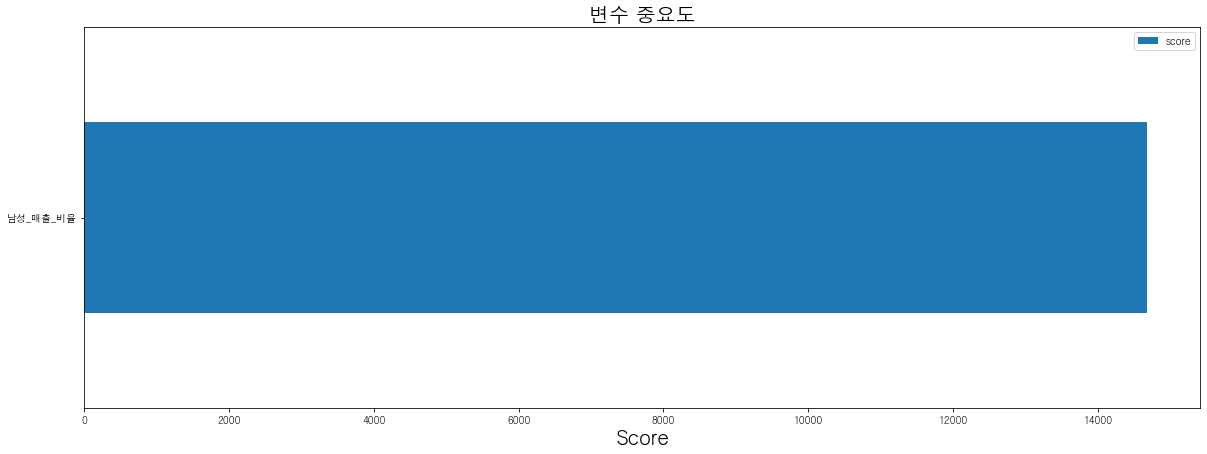

In [18]:
# 중요도 시각화

feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

fig, ax = plt.pyplot.subplots(figsize=(20,7))
data_50 = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_50[:10].plot(kind='barh', ax = ax, label = '')
ax.set_title('변수 중요도', size = 20)
ax.set_xlabel('Score', size = 20)

## 3. 모델링 - 연령대별
### (1) 전처리

In [19]:
df.columns

Index(['Unnamed: 0', '기준_년_코드', '기준_분기_코드', '서비스_업종_코드', '점포_수', '유사_업종_점포_수',
       '개업_율', '개업_점포_수', '폐업_률', '폐업_점포_수', '프랜차이즈_점포_수', '당월_매출_금액',
       '당월_매출_건수', '주중_매출_비율', '주말_매출_비율', '월요일_매출_비율', '화요일_매출_비율',
       '수요일_매출_비율', '목요일_매출_비율', '금요일_매출_비율', '토요일_매출_비율', '일요일_매출_비율',
       '시간대_00~06_매출_비율', '시간대_06~11_매출_비율', '시간대_11~14_매출_비율',
       '시간대_14~17_매출_비율', '시간대_17~21_매출_비율', '시간대_21~24_매출_비율', '남성_매출_비율',
       '여성_매출_비율', '연령대_10_매출_비율', '연령대_20_매출_비율', '연령대_30_매출_비율',
       '연령대_40_매출_비율', '연령대_50_매출_비율', '연령대_60_이상_매출_비율', '주중_매출_금액',
       '주말_매출_금액', '월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액',
       '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액', '시간대_00~06_매출_금액',
       '시간대_06~11_매출_금액', '시간대_11~14_매출_금액', '시간대_14~17_매출_금액',
       '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액', '여성_매출_금액',
       '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액',
       '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수', '주말_매출_건수', '월요일_매출_건수',
       '화요일_매

In [20]:
# 필요한 column 추출

df_new = df[['기준_년_코드', '기준_분기_코드', '서비스_업종_코드', '연령대_10_매출_비율', '연령대_20_매출_비율', '연령대_30_매출_비율',
       '연령대_40_매출_비율', '연령대_50_매출_비율', '연령대_60_이상_매출_비율', '폐업_률']]
df_new

,기준_년_코드,기준_분기_코드,서비스_업종_코드,연령대_10_매출_비율,연령대_20_매출_비율,연령대_30_매출_비율,연령대_40_매출_비율,연령대_50_매출_비율,연령대_60_이상_매출_비율,폐업_률
0,2015,1,CS100001,0.50,1.00,0.67,0.33,0.00,0.00,3
1,2015,2,CS100001,0.50,0.83,1.00,0.67,0.00,0.00,5
2,2015,3,CS100001,1.00,1.00,0.67,0.67,0.00,0.00,4
3,2015,4,CS100001,1.00,0.83,0.33,0.67,0.00,0.00,3
4,2016,1,CS100001,0.50,0.67,0.67,0.67,0.33,0.00,4
5,2016,2,CS100001,0.50,0.50,0.33,0.67,0.33,0.33,5
6,2016,3,CS100001,0.50,0.67,0.33,0.67,0.33,0.33,6
7,2016,4,CS100001,1.00,0.83,0.33,0.33,0.00,0.33,2
8,2017,1,CS100001,0.50,0.67,0.67,0.67,0.00,0.33,2
9,2017,2,CS100001,0.50,0.50,0.67,0.67,0.33,0.67,4


In [21]:
# dataframe 행 순서 조정

a = df_new.iloc[20]
df_new = df_new.drop(20)
df_new = df_new.append(a)
df_new = df_new.reset_index(drop = True)
df_new

,기준_년_코드,기준_분기_코드,서비스_업종_코드,연령대_10_매출_비율,연령대_20_매출_비율,연령대_30_매출_비율,연령대_40_매출_비율,연령대_50_매출_비율,연령대_60_이상_매출_비율,폐업_률
0,2015,1,CS100001,0.50,1.00,0.67,0.33,0.00,0.00,3
1,2015,2,CS100001,0.50,0.83,1.00,0.67,0.00,0.00,5
2,2015,3,CS100001,1.00,1.00,0.67,0.67,0.00,0.00,4
3,2015,4,CS100001,1.00,0.83,0.33,0.67,0.00,0.00,3
4,2016,1,CS100001,0.50,0.67,0.67,0.67,0.33,0.00,4
5,2016,2,CS100001,0.50,0.50,0.33,0.67,0.33,0.33,5
6,2016,3,CS100001,0.50,0.67,0.33,0.67,0.33,0.33,6
7,2016,4,CS100001,1.00,0.83,0.33,0.33,0.00,0.33,2
8,2017,1,CS100001,0.50,0.67,0.67,0.67,0.00,0.33,2
9,2017,2,CS100001,0.50,0.50,0.67,0.67,0.33,0.67,4


In [22]:
# 2020-3분기 예측에 사용되는 'X_predict' 데이터 추출

x_predict = pd.DataFrame(columns = df_new.columns)
x_predict = x_predict.append(df_new.iloc[21,:])
x_predict = x_predict.drop(['기준_년_코드', '기준_분기_코드', '서비스_업종_코드', '폐업_률'], axis = 1)
x_predict

,연령대_10_매출_비율,연령대_20_매출_비율,연령대_30_매출_비율,연령대_40_매출_비율,연령대_50_매출_비율,연령대_60_이상_매출_비율
21,0.00,0.00,1.00,1.00,1.00,0.33


In [23]:
# 인풋 데이터 추출

x = df_new.drop('폐업_률', axis = 1).drop(21).reset_index(drop = True)
x

,기준_년_코드,기준_분기_코드,서비스_업종_코드,연령대_10_매출_비율,연령대_20_매출_비율,연령대_30_매출_비율,연령대_40_매출_비율,연령대_50_매출_비율,연령대_60_이상_매출_비율
0,2015,1,CS100001,0.50,1.00,0.67,0.33,0.00,0.00
1,2015,2,CS100001,0.50,0.83,1.00,0.67,0.00,0.00
2,2015,3,CS100001,1.00,1.00,0.67,0.67,0.00,0.00
3,2015,4,CS100001,1.00,0.83,0.33,0.67,0.00,0.00
4,2016,1,CS100001,0.50,0.67,0.67,0.67,0.33,0.00
5,2016,2,CS100001,0.50,0.50,0.33,0.67,0.33,0.33
6,2016,3,CS100001,0.50,0.67,0.33,0.67,0.33,0.33
7,2016,4,CS100001,1.00,0.83,0.33,0.33,0.00,0.33
8,2017,1,CS100001,0.50,0.67,0.67,0.67,0.00,0.33
9,2017,2,CS100001,0.50,0.50,0.67,0.67,0.33,0.67


In [24]:
# x와 y를 하나로 merge

xy_train = pd.merge(x, y_new, how = 'left', on = ['기준_년_코드', '기준_분기_코드'])
xy_train

,기준_년_코드,기준_분기_코드,서비스_업종_코드,연령대_10_매출_비율,연령대_20_매출_비율,연령대_30_매출_비율,연령대_40_매출_비율,연령대_50_매출_비율,연령대_60_이상_매출_비율,폐업_률
0,2015,1,CS100001,0.50,1.00,0.67,0.33,0.00,0.00,5
1,2015,2,CS100001,0.50,0.83,1.00,0.67,0.00,0.00,4
2,2015,3,CS100001,1.00,1.00,0.67,0.67,0.00,0.00,3
3,2015,4,CS100001,1.00,0.83,0.33,0.67,0.00,0.00,4
4,2016,1,CS100001,0.50,0.67,0.67,0.67,0.33,0.00,5
5,2016,2,CS100001,0.50,0.50,0.33,0.67,0.33,0.33,6
6,2016,3,CS100001,0.50,0.67,0.33,0.67,0.33,0.33,2
7,2016,4,CS100001,1.00,0.83,0.33,0.33,0.00,0.33,2
8,2017,1,CS100001,0.50,0.67,0.67,0.67,0.00,0.33,4
9,2017,2,CS100001,0.50,0.50,0.67,0.67,0.33,0.67,3


In [25]:
# 불필요한 column 삭제

xy_train_new = xy_train.drop(['기준_년_코드', '기준_분기_코드', '서비스_업종_코드'], axis = 1)
xy_train_new

,연령대_10_매출_비율,연령대_20_매출_비율,연령대_30_매출_비율,연령대_40_매출_비율,연령대_50_매출_비율,연령대_60_이상_매출_비율,폐업_률
0,0.50,1.00,0.67,0.33,0.00,0.00,5
1,0.50,0.83,1.00,0.67,0.00,0.00,4
2,1.00,1.00,0.67,0.67,0.00,0.00,3
3,1.00,0.83,0.33,0.67,0.00,0.00,4
4,0.50,0.67,0.67,0.67,0.33,0.00,5
5,0.50,0.50,0.33,0.67,0.33,0.33,6
6,0.50,0.67,0.33,0.67,0.33,0.33,2
7,1.00,0.83,0.33,0.33,0.00,0.33,2
8,0.50,0.67,0.67,0.67,0.00,0.33,4
9,0.50,0.50,0.67,0.67,0.33,0.67,3


### (2) 모델링

In [26]:
start = time.time()  # 시작 시간 저장

x_in = xy_train_new.drop('폐업_률', axis = 1)
x_out = xy_train_new['폐업_률']

# 생존율로 변환
total = 100
x_out = total - x_out

# train, test 데이터 
X_train, X_test, y_train, y_test= train_test_split(x_in, x_out, test_size=0.2, random_state=42)

In [27]:
# xgboost 학습

model = XGBRegressor(booster="gbtree", objective ='reg:squarederror', n_estimators=12000, learning_rate=0.001 ,
                      max_depth=12, n_jobs = -1,subsample=0.75, reg_lambda=1, colsample_bytree=1, gamma=0, )

eval_set = [(X_test, y_test)]

model.fit(X_train,y_train, eval_set=eval_set, verbose=True)

pred_y = model.predict(X_test)

#predictions = [round(value) for value in xgb_5000_명동_pred ]
# evaluate predictions

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

[0]	validation_0-rmse:95.41333
[1]	validation_0-rmse:95.32425
[2]	validation_0-rmse:95.23433
[3]	validation_0-rmse:95.14635
[4]	validation_0-rmse:95.05764
[5]	validation_0-rmse:94.96960
[6]	validation_0-rmse:94.88163
[7]	validation_0-rmse:94.79261
[8]	validation_0-rmse:94.70481
[9]	validation_0-rmse:94.61733
[10]	validation_0-rmse:94.52843
[11]	validation_0-rmse:94.44160
[12]	validation_0-rmse:94.35287
[13]	validation_0-rmse:94.26580
[14]	validation_0-rmse:94.17675
[15]	validation_0-rmse:94.08759
[16]	validation_0-rmse:94.00330
[17]	validation_0-rmse:93.91869
[18]	validation_0-rmse:93.83185
[19]	validation_0-rmse:93.74526
[20]	validation_0-rmse:93.65803
[21]	validation_0-rmse:93.56967
[22]	validation_0-rmse:93.48299
[23]	validation_0-rmse:93.39593
[24]	validation_0-rmse:93.30871
[25]	validation_0-rmse:93.22276
[26]	validation_0-rmse:93.13528
[27]	validation_0-rmse:93.04817
[28]	validation_0-rmse:92.96413
[29]	validation_0-rmse:92.87724
[30]	validation_0-rmse:92.79022
[31]	validation_0-

[252]	validation_0-rmse:75.53378
[253]	validation_0-rmse:75.46500
[254]	validation_0-rmse:75.39438
[255]	validation_0-rmse:75.32368
[256]	validation_0-rmse:75.25472
[257]	validation_0-rmse:75.18604
[258]	validation_0-rmse:75.11733
[259]	validation_0-rmse:75.04695
[260]	validation_0-rmse:74.97745
[261]	validation_0-rmse:74.90747
[262]	validation_0-rmse:74.83763
[263]	validation_0-rmse:74.76751
[264]	validation_0-rmse:74.69686
[265]	validation_0-rmse:74.62781
[266]	validation_0-rmse:74.55757
[267]	validation_0-rmse:74.48805
[268]	validation_0-rmse:74.41804
[269]	validation_0-rmse:74.34888
[270]	validation_0-rmse:74.27863
[271]	validation_0-rmse:74.20888
[272]	validation_0-rmse:74.14189
[273]	validation_0-rmse:74.07386
[274]	validation_0-rmse:74.00398
[275]	validation_0-rmse:73.93459
[276]	validation_0-rmse:73.86665
[277]	validation_0-rmse:73.79793
[278]	validation_0-rmse:73.72890
[279]	validation_0-rmse:73.65975
[280]	validation_0-rmse:73.59140
[281]	validation_0-rmse:73.52438
[282]	vali

[501]	validation_0-rmse:59.92656
[502]	validation_0-rmse:59.87048
[503]	validation_0-rmse:59.81387
[504]	validation_0-rmse:59.75868
[505]	validation_0-rmse:59.70409
[506]	validation_0-rmse:59.64784
[507]	validation_0-rmse:59.59210
[508]	validation_0-rmse:59.53679
[509]	validation_0-rmse:59.48122
[510]	validation_0-rmse:59.42578
[511]	validation_0-rmse:59.37132
[512]	validation_0-rmse:59.31648
[513]	validation_0-rmse:59.26056
[514]	validation_0-rmse:59.20518
[515]	validation_0-rmse:59.14971
[516]	validation_0-rmse:59.09370
[517]	validation_0-rmse:59.03782
[518]	validation_0-rmse:58.98219
[519]	validation_0-rmse:58.92766
[520]	validation_0-rmse:58.87332
[521]	validation_0-rmse:58.81953
[522]	validation_0-rmse:58.76471
[523]	validation_0-rmse:58.70985
[524]	validation_0-rmse:58.65536
[525]	validation_0-rmse:58.60159
[526]	validation_0-rmse:58.54617
[527]	validation_0-rmse:58.49231
[528]	validation_0-rmse:58.43862
[529]	validation_0-rmse:58.38399
[530]	validation_0-rmse:58.32914
[531]	vali

[750]	validation_0-rmse:47.52972
[751]	validation_0-rmse:47.48460
[752]	validation_0-rmse:47.43956
[753]	validation_0-rmse:47.39508
[754]	validation_0-rmse:47.35051
[755]	validation_0-rmse:47.30612
[756]	validation_0-rmse:47.26154
[757]	validation_0-rmse:47.21744
[758]	validation_0-rmse:47.17408
[759]	validation_0-rmse:47.12965
[760]	validation_0-rmse:47.08506
[761]	validation_0-rmse:47.04183
[762]	validation_0-rmse:46.99825
[763]	validation_0-rmse:46.95373
[764]	validation_0-rmse:46.91019
[765]	validation_0-rmse:46.86589
[766]	validation_0-rmse:46.82179
[767]	validation_0-rmse:46.77741
[768]	validation_0-rmse:46.73342
[769]	validation_0-rmse:46.68992
[770]	validation_0-rmse:46.64705
[771]	validation_0-rmse:46.60292
[772]	validation_0-rmse:46.55930
[773]	validation_0-rmse:46.51604
[774]	validation_0-rmse:46.47265
[775]	validation_0-rmse:46.42995
[776]	validation_0-rmse:46.38685
[777]	validation_0-rmse:46.34365
[778]	validation_0-rmse:46.30060
[779]	validation_0-rmse:46.25702
[780]	vali

[999]	validation_0-rmse:37.65702
[1000]	validation_0-rmse:37.62196
[1001]	validation_0-rmse:37.58625
[1002]	validation_0-rmse:37.55139
[1003]	validation_0-rmse:37.51613
[1004]	validation_0-rmse:37.48179
[1005]	validation_0-rmse:37.44648
[1006]	validation_0-rmse:37.41130
[1007]	validation_0-rmse:37.37765
[1008]	validation_0-rmse:37.34352
[1009]	validation_0-rmse:37.30790
[1010]	validation_0-rmse:37.27261
[1011]	validation_0-rmse:37.23908
[1012]	validation_0-rmse:37.20437
[1013]	validation_0-rmse:37.16953
[1014]	validation_0-rmse:37.13452
[1015]	validation_0-rmse:37.09967
[1016]	validation_0-rmse:37.06472
[1017]	validation_0-rmse:37.02967
[1018]	validation_0-rmse:36.99496
[1019]	validation_0-rmse:36.95998
[1020]	validation_0-rmse:36.92531
[1021]	validation_0-rmse:36.89061
[1022]	validation_0-rmse:36.85600
[1023]	validation_0-rmse:36.82156
[1024]	validation_0-rmse:36.78728
[1025]	validation_0-rmse:36.75230
[1026]	validation_0-rmse:36.71779
[1027]	validation_0-rmse:36.68356
[1028]	validati

[1240]	validation_0-rmse:30.04575
[1241]	validation_0-rmse:30.01763
[1242]	validation_0-rmse:29.98881
[1243]	validation_0-rmse:29.96003
[1244]	validation_0-rmse:29.93208
[1245]	validation_0-rmse:29.90516
[1246]	validation_0-rmse:29.87690
[1247]	validation_0-rmse:29.84919
[1248]	validation_0-rmse:29.82084
[1249]	validation_0-rmse:29.79247
[1250]	validation_0-rmse:29.76451
[1251]	validation_0-rmse:29.73764
[1252]	validation_0-rmse:29.71005
[1253]	validation_0-rmse:29.68260
[1254]	validation_0-rmse:29.65456
[1255]	validation_0-rmse:29.62689
[1256]	validation_0-rmse:29.59925
[1257]	validation_0-rmse:29.57125
[1258]	validation_0-rmse:29.54410
[1259]	validation_0-rmse:29.51645
[1260]	validation_0-rmse:29.48875
[1261]	validation_0-rmse:29.46081
[1262]	validation_0-rmse:29.43441
[1263]	validation_0-rmse:29.40641
[1264]	validation_0-rmse:29.38040
[1265]	validation_0-rmse:29.35298
[1266]	validation_0-rmse:29.32521
[1267]	validation_0-rmse:29.29802
[1268]	validation_0-rmse:29.27107
[1269]	validat

[1481]	validation_0-rmse:23.95690
[1482]	validation_0-rmse:23.93396
[1483]	validation_0-rmse:23.91111
[1484]	validation_0-rmse:23.88849
[1485]	validation_0-rmse:23.86623
[1486]	validation_0-rmse:23.84344
[1487]	validation_0-rmse:23.82110
[1488]	validation_0-rmse:23.79869
[1489]	validation_0-rmse:23.77617
[1490]	validation_0-rmse:23.75494
[1491]	validation_0-rmse:23.73317
[1492]	validation_0-rmse:23.71153
[1493]	validation_0-rmse:23.68953
[1494]	validation_0-rmse:23.66669
[1495]	validation_0-rmse:23.64408
[1496]	validation_0-rmse:23.62178
[1497]	validation_0-rmse:23.59943
[1498]	validation_0-rmse:23.57765
[1499]	validation_0-rmse:23.55506
[1500]	validation_0-rmse:23.53348
[1501]	validation_0-rmse:23.51184
[1502]	validation_0-rmse:23.48989
[1503]	validation_0-rmse:23.46773
[1504]	validation_0-rmse:23.44582
[1505]	validation_0-rmse:23.42366
[1506]	validation_0-rmse:23.40241
[1507]	validation_0-rmse:23.38028
[1508]	validation_0-rmse:23.35837
[1509]	validation_0-rmse:23.33638
[1510]	validat

[1722]	validation_0-rmse:19.07916
[1723]	validation_0-rmse:19.06110
[1724]	validation_0-rmse:19.04307
[1725]	validation_0-rmse:19.02476
[1726]	validation_0-rmse:19.00676
[1727]	validation_0-rmse:18.98869
[1728]	validation_0-rmse:18.97064
[1729]	validation_0-rmse:18.95219
[1730]	validation_0-rmse:18.93458
[1731]	validation_0-rmse:18.91701
[1732]	validation_0-rmse:18.89886
[1733]	validation_0-rmse:18.88040
[1734]	validation_0-rmse:18.86227
[1735]	validation_0-rmse:18.84431
[1736]	validation_0-rmse:18.82614
[1737]	validation_0-rmse:18.80895
[1738]	validation_0-rmse:18.79149
[1739]	validation_0-rmse:18.77327
[1740]	validation_0-rmse:18.75588
[1741]	validation_0-rmse:18.73788
[1742]	validation_0-rmse:18.71971
[1743]	validation_0-rmse:18.70157
[1744]	validation_0-rmse:18.68387
[1745]	validation_0-rmse:18.66618
[1746]	validation_0-rmse:18.64858
[1747]	validation_0-rmse:18.63069
[1748]	validation_0-rmse:18.61313
[1749]	validation_0-rmse:18.59550
[1750]	validation_0-rmse:18.57813
[1751]	validat

[1963]	validation_0-rmse:15.17118
[1964]	validation_0-rmse:15.15633
[1965]	validation_0-rmse:15.14144
[1966]	validation_0-rmse:15.12726
[1967]	validation_0-rmse:15.11281
[1968]	validation_0-rmse:15.09846
[1969]	validation_0-rmse:15.08430
[1970]	validation_0-rmse:15.07009
[1971]	validation_0-rmse:15.05628
[1972]	validation_0-rmse:15.04209
[1973]	validation_0-rmse:15.02772
[1974]	validation_0-rmse:15.01322
[1975]	validation_0-rmse:14.99885
[1976]	validation_0-rmse:14.98445
[1977]	validation_0-rmse:14.97006
[1978]	validation_0-rmse:14.95588
[1979]	validation_0-rmse:14.94159
[1980]	validation_0-rmse:14.92705
[1981]	validation_0-rmse:14.91279
[1982]	validation_0-rmse:14.89835
[1983]	validation_0-rmse:14.88447
[1984]	validation_0-rmse:14.87017
[1985]	validation_0-rmse:14.85601
[1986]	validation_0-rmse:14.84179
[1987]	validation_0-rmse:14.82754
[1988]	validation_0-rmse:14.81322
[1989]	validation_0-rmse:14.79907
[1990]	validation_0-rmse:14.78465
[1991]	validation_0-rmse:14.77054
[1992]	validat

[2204]	validation_0-rmse:12.04729
[2205]	validation_0-rmse:12.03528
[2206]	validation_0-rmse:12.02361
[2207]	validation_0-rmse:12.01162
[2208]	validation_0-rmse:11.99987
[2209]	validation_0-rmse:11.98844
[2210]	validation_0-rmse:11.97679
[2211]	validation_0-rmse:11.96478
[2212]	validation_0-rmse:11.95334
[2213]	validation_0-rmse:11.94182
[2214]	validation_0-rmse:11.93024
[2215]	validation_0-rmse:11.91869
[2216]	validation_0-rmse:11.90764
[2217]	validation_0-rmse:11.89609
[2218]	validation_0-rmse:11.88483
[2219]	validation_0-rmse:11.87368
[2220]	validation_0-rmse:11.86196
[2221]	validation_0-rmse:11.85039
[2222]	validation_0-rmse:11.83892
[2223]	validation_0-rmse:11.82767
[2224]	validation_0-rmse:11.81650
[2225]	validation_0-rmse:11.80553
[2226]	validation_0-rmse:11.79428
[2227]	validation_0-rmse:11.78314
[2228]	validation_0-rmse:11.77176
[2229]	validation_0-rmse:11.76039
[2230]	validation_0-rmse:11.74930
[2231]	validation_0-rmse:11.73793
[2232]	validation_0-rmse:11.72665
[2233]	validat

[2447]	validation_0-rmse:9.52309
[2448]	validation_0-rmse:9.51365
[2449]	validation_0-rmse:9.50421
[2450]	validation_0-rmse:9.49486
[2451]	validation_0-rmse:9.48536
[2452]	validation_0-rmse:9.47615
[2453]	validation_0-rmse:9.46703
[2454]	validation_0-rmse:9.45778
[2455]	validation_0-rmse:9.44848
[2456]	validation_0-rmse:9.43931
[2457]	validation_0-rmse:9.43020
[2458]	validation_0-rmse:9.42098
[2459]	validation_0-rmse:9.41176
[2460]	validation_0-rmse:9.40241
[2461]	validation_0-rmse:9.39308
[2462]	validation_0-rmse:9.38407
[2463]	validation_0-rmse:9.37511
[2464]	validation_0-rmse:9.36614
[2465]	validation_0-rmse:9.35727
[2466]	validation_0-rmse:9.34824
[2467]	validation_0-rmse:9.33919
[2468]	validation_0-rmse:9.33042
[2469]	validation_0-rmse:9.32166
[2470]	validation_0-rmse:9.31255
[2471]	validation_0-rmse:9.30330
[2472]	validation_0-rmse:9.29442
[2473]	validation_0-rmse:9.28519
[2474]	validation_0-rmse:9.27626
[2475]	validation_0-rmse:9.26704
[2476]	validation_0-rmse:9.25826
[2477]	val

[2696]	validation_0-rmse:7.46167
[2697]	validation_0-rmse:7.45428
[2698]	validation_0-rmse:7.44698
[2699]	validation_0-rmse:7.43987
[2700]	validation_0-rmse:7.43386
[2701]	validation_0-rmse:7.42651
[2702]	validation_0-rmse:7.41916
[2703]	validation_0-rmse:7.41137
[2704]	validation_0-rmse:7.40411
[2705]	validation_0-rmse:7.39709
[2706]	validation_0-rmse:7.39003
[2707]	validation_0-rmse:7.38246
[2708]	validation_0-rmse:7.37530
[2709]	validation_0-rmse:7.36800
[2710]	validation_0-rmse:7.36064
[2711]	validation_0-rmse:7.35364
[2712]	validation_0-rmse:7.34652
[2713]	validation_0-rmse:7.33971
[2714]	validation_0-rmse:7.33252
[2715]	validation_0-rmse:7.32526
[2716]	validation_0-rmse:7.31801
[2717]	validation_0-rmse:7.31102
[2718]	validation_0-rmse:7.30371
[2719]	validation_0-rmse:7.29663
[2720]	validation_0-rmse:7.28933
[2721]	validation_0-rmse:7.28240
[2722]	validation_0-rmse:7.27519
[2723]	validation_0-rmse:7.26807
[2724]	validation_0-rmse:7.26133
[2725]	validation_0-rmse:7.25414
[2726]	val

[2945]	validation_0-rmse:5.83037
[2946]	validation_0-rmse:5.82467
[2947]	validation_0-rmse:5.81897
[2948]	validation_0-rmse:5.81370
[2949]	validation_0-rmse:5.80811
[2950]	validation_0-rmse:5.80264
[2951]	validation_0-rmse:5.79662
[2952]	validation_0-rmse:5.79064
[2953]	validation_0-rmse:5.78460
[2954]	validation_0-rmse:5.77893
[2955]	validation_0-rmse:5.77313
[2956]	validation_0-rmse:5.76740
[2957]	validation_0-rmse:5.76187
[2958]	validation_0-rmse:5.75624
[2959]	validation_0-rmse:5.75047
[2960]	validation_0-rmse:5.74485
[2961]	validation_0-rmse:5.73896
[2962]	validation_0-rmse:5.73319
[2963]	validation_0-rmse:5.72786
[2964]	validation_0-rmse:5.72184
[2965]	validation_0-rmse:5.71609
[2966]	validation_0-rmse:5.71035
[2967]	validation_0-rmse:5.70429
[2968]	validation_0-rmse:5.69894
[2969]	validation_0-rmse:5.69315
[2970]	validation_0-rmse:5.68750
[2971]	validation_0-rmse:5.68143
[2972]	validation_0-rmse:5.67602
[2973]	validation_0-rmse:5.67012
[2974]	validation_0-rmse:5.66456
[2975]	val

[3194]	validation_0-rmse:4.53903
[3195]	validation_0-rmse:4.53453
[3196]	validation_0-rmse:4.52980
[3197]	validation_0-rmse:4.52515
[3198]	validation_0-rmse:4.52034
[3199]	validation_0-rmse:4.51595
[3200]	validation_0-rmse:4.51106
[3201]	validation_0-rmse:4.50678
[3202]	validation_0-rmse:4.50232
[3203]	validation_0-rmse:4.49767
[3204]	validation_0-rmse:4.49335
[3205]	validation_0-rmse:4.48942
[3206]	validation_0-rmse:4.48470
[3207]	validation_0-rmse:4.48005
[3208]	validation_0-rmse:4.47510
[3209]	validation_0-rmse:4.47124
[3210]	validation_0-rmse:4.46649
[3211]	validation_0-rmse:4.46172
[3212]	validation_0-rmse:4.45716
[3213]	validation_0-rmse:4.45275
[3214]	validation_0-rmse:4.44795
[3215]	validation_0-rmse:4.44327
[3216]	validation_0-rmse:4.43887
[3217]	validation_0-rmse:4.43483
[3218]	validation_0-rmse:4.43016
[3219]	validation_0-rmse:4.42601
[3220]	validation_0-rmse:4.42231
[3221]	validation_0-rmse:4.41793
[3222]	validation_0-rmse:4.41319
[3223]	validation_0-rmse:4.40859
[3224]	val

[3443]	validation_0-rmse:3.52864
[3444]	validation_0-rmse:3.52481
[3445]	validation_0-rmse:3.52109
[3446]	validation_0-rmse:3.51762
[3447]	validation_0-rmse:3.51420
[3448]	validation_0-rmse:3.51054
[3449]	validation_0-rmse:3.50658
[3450]	validation_0-rmse:3.50337
[3451]	validation_0-rmse:3.49975
[3452]	validation_0-rmse:3.49698
[3453]	validation_0-rmse:3.49327
[3454]	validation_0-rmse:3.48969
[3455]	validation_0-rmse:3.48703
[3456]	validation_0-rmse:3.48351
[3457]	validation_0-rmse:3.47964
[3458]	validation_0-rmse:3.47645
[3459]	validation_0-rmse:3.47280
[3460]	validation_0-rmse:3.46902
[3461]	validation_0-rmse:3.46582
[3462]	validation_0-rmse:3.46162
[3463]	validation_0-rmse:3.45782
[3464]	validation_0-rmse:3.45442
[3465]	validation_0-rmse:3.45070
[3466]	validation_0-rmse:3.44723
[3467]	validation_0-rmse:3.44384
[3468]	validation_0-rmse:3.44039
[3469]	validation_0-rmse:3.43717
[3470]	validation_0-rmse:3.43353
[3471]	validation_0-rmse:3.43018
[3472]	validation_0-rmse:3.42677
[3473]	val

[3692]	validation_0-rmse:2.75376
[3693]	validation_0-rmse:2.75081
[3694]	validation_0-rmse:2.74806
[3695]	validation_0-rmse:2.74512
[3696]	validation_0-rmse:2.74264
[3697]	validation_0-rmse:2.73982
[3698]	validation_0-rmse:2.73726
[3699]	validation_0-rmse:2.73502
[3700]	validation_0-rmse:2.73231
[3701]	validation_0-rmse:2.72902
[3702]	validation_0-rmse:2.72719
[3703]	validation_0-rmse:2.72425
[3704]	validation_0-rmse:2.72114
[3705]	validation_0-rmse:2.71843
[3706]	validation_0-rmse:2.71564
[3707]	validation_0-rmse:2.71286
[3708]	validation_0-rmse:2.70993
[3709]	validation_0-rmse:2.70722
[3710]	validation_0-rmse:2.70458
[3711]	validation_0-rmse:2.70165
[3712]	validation_0-rmse:2.69853
[3713]	validation_0-rmse:2.69568
[3714]	validation_0-rmse:2.69333
[3715]	validation_0-rmse:2.69044
[3716]	validation_0-rmse:2.68757
[3717]	validation_0-rmse:2.68511
[3718]	validation_0-rmse:2.68268
[3719]	validation_0-rmse:2.68007
[3720]	validation_0-rmse:2.67762
[3721]	validation_0-rmse:2.67519
[3722]	val

[3941]	validation_0-rmse:2.17771
[3942]	validation_0-rmse:2.17605
[3943]	validation_0-rmse:2.17393
[3944]	validation_0-rmse:2.17236
[3945]	validation_0-rmse:2.17102
[3946]	validation_0-rmse:2.16893
[3947]	validation_0-rmse:2.16665
[3948]	validation_0-rmse:2.16479
[3949]	validation_0-rmse:2.16233
[3950]	validation_0-rmse:2.16032
[3951]	validation_0-rmse:2.15817
[3952]	validation_0-rmse:2.15601
[3953]	validation_0-rmse:2.15428
[3954]	validation_0-rmse:2.15243
[3955]	validation_0-rmse:2.15126
[3956]	validation_0-rmse:2.14907
[3957]	validation_0-rmse:2.14693
[3958]	validation_0-rmse:2.14483
[3959]	validation_0-rmse:2.14284
[3960]	validation_0-rmse:2.14069
[3961]	validation_0-rmse:2.13862
[3962]	validation_0-rmse:2.13632
[3963]	validation_0-rmse:2.13409
[3964]	validation_0-rmse:2.13250
[3965]	validation_0-rmse:2.13084
[3966]	validation_0-rmse:2.12912
[3967]	validation_0-rmse:2.12760
[3968]	validation_0-rmse:2.12555
[3969]	validation_0-rmse:2.12385
[3970]	validation_0-rmse:2.12199
[3971]	val

[4190]	validation_0-rmse:1.75021
[4191]	validation_0-rmse:1.74845
[4192]	validation_0-rmse:1.74666
[4193]	validation_0-rmse:1.74532
[4194]	validation_0-rmse:1.74417
[4195]	validation_0-rmse:1.74287
[4196]	validation_0-rmse:1.74184
[4197]	validation_0-rmse:1.74048
[4198]	validation_0-rmse:1.73918
[4199]	validation_0-rmse:1.73780
[4200]	validation_0-rmse:1.73648
[4201]	validation_0-rmse:1.73478
[4202]	validation_0-rmse:1.73313
[4203]	validation_0-rmse:1.73264
[4204]	validation_0-rmse:1.73142
[4205]	validation_0-rmse:1.73015
[4206]	validation_0-rmse:1.72869
[4207]	validation_0-rmse:1.72783
[4208]	validation_0-rmse:1.72632
[4209]	validation_0-rmse:1.72545
[4210]	validation_0-rmse:1.72439
[4211]	validation_0-rmse:1.72309
[4212]	validation_0-rmse:1.72179
[4213]	validation_0-rmse:1.71947
[4214]	validation_0-rmse:1.71821
[4215]	validation_0-rmse:1.71632
[4216]	validation_0-rmse:1.71487
[4217]	validation_0-rmse:1.71321
[4218]	validation_0-rmse:1.71204
[4219]	validation_0-rmse:1.71042
[4220]	val

[4439]	validation_0-rmse:1.43973
[4440]	validation_0-rmse:1.43849
[4441]	validation_0-rmse:1.43744
[4442]	validation_0-rmse:1.43637
[4443]	validation_0-rmse:1.43517
[4444]	validation_0-rmse:1.43362
[4445]	validation_0-rmse:1.43258
[4446]	validation_0-rmse:1.43197
[4447]	validation_0-rmse:1.43061
[4448]	validation_0-rmse:1.42997
[4449]	validation_0-rmse:1.42876
[4450]	validation_0-rmse:1.42831
[4451]	validation_0-rmse:1.42822
[4452]	validation_0-rmse:1.42695
[4453]	validation_0-rmse:1.42573
[4454]	validation_0-rmse:1.42428
[4455]	validation_0-rmse:1.42336
[4456]	validation_0-rmse:1.42257
[4457]	validation_0-rmse:1.42156
[4458]	validation_0-rmse:1.42068
[4459]	validation_0-rmse:1.41955
[4460]	validation_0-rmse:1.41803
[4461]	validation_0-rmse:1.41647
[4462]	validation_0-rmse:1.41553
[4463]	validation_0-rmse:1.41458
[4464]	validation_0-rmse:1.41347
[4465]	validation_0-rmse:1.41174
[4466]	validation_0-rmse:1.41119
[4467]	validation_0-rmse:1.40959
[4468]	validation_0-rmse:1.40878
[4469]	val

[4688]	validation_0-rmse:1.20792
[4689]	validation_0-rmse:1.20717
[4690]	validation_0-rmse:1.20637
[4691]	validation_0-rmse:1.20529
[4692]	validation_0-rmse:1.20435
[4693]	validation_0-rmse:1.20360
[4694]	validation_0-rmse:1.20321
[4695]	validation_0-rmse:1.20277
[4696]	validation_0-rmse:1.20194
[4697]	validation_0-rmse:1.20101
[4698]	validation_0-rmse:1.20019
[4699]	validation_0-rmse:1.19915
[4700]	validation_0-rmse:1.19796
[4701]	validation_0-rmse:1.19758
[4702]	validation_0-rmse:1.19664
[4703]	validation_0-rmse:1.19602
[4704]	validation_0-rmse:1.19557
[4705]	validation_0-rmse:1.19469
[4706]	validation_0-rmse:1.19336
[4707]	validation_0-rmse:1.19238
[4708]	validation_0-rmse:1.19177
[4709]	validation_0-rmse:1.19120
[4710]	validation_0-rmse:1.19020
[4711]	validation_0-rmse:1.18976
[4712]	validation_0-rmse:1.18896
[4713]	validation_0-rmse:1.18830
[4714]	validation_0-rmse:1.18739
[4715]	validation_0-rmse:1.18642
[4716]	validation_0-rmse:1.18553
[4717]	validation_0-rmse:1.18509
[4718]	val

[4937]	validation_0-rmse:1.04057
[4938]	validation_0-rmse:1.03969
[4939]	validation_0-rmse:1.03905
[4940]	validation_0-rmse:1.03868
[4941]	validation_0-rmse:1.03765
[4942]	validation_0-rmse:1.03719
[4943]	validation_0-rmse:1.03705
[4944]	validation_0-rmse:1.03660
[4945]	validation_0-rmse:1.03597
[4946]	validation_0-rmse:1.03530
[4947]	validation_0-rmse:1.03441
[4948]	validation_0-rmse:1.03384
[4949]	validation_0-rmse:1.03338
[4950]	validation_0-rmse:1.03291
[4951]	validation_0-rmse:1.03255
[4952]	validation_0-rmse:1.03203
[4953]	validation_0-rmse:1.03173
[4954]	validation_0-rmse:1.03099
[4955]	validation_0-rmse:1.03037
[4956]	validation_0-rmse:1.02941
[4957]	validation_0-rmse:1.02898
[4958]	validation_0-rmse:1.02846
[4959]	validation_0-rmse:1.02771
[4960]	validation_0-rmse:1.02736
[4961]	validation_0-rmse:1.02690
[4962]	validation_0-rmse:1.02644
[4963]	validation_0-rmse:1.02592
[4964]	validation_0-rmse:1.02517
[4965]	validation_0-rmse:1.02469
[4966]	validation_0-rmse:1.02434
[4967]	val

[5186]	validation_0-rmse:0.92326
[5187]	validation_0-rmse:0.92236
[5188]	validation_0-rmse:0.92187
[5189]	validation_0-rmse:0.92130
[5190]	validation_0-rmse:0.92108
[5191]	validation_0-rmse:0.92064
[5192]	validation_0-rmse:0.92007
[5193]	validation_0-rmse:0.91971
[5194]	validation_0-rmse:0.91917
[5195]	validation_0-rmse:0.91863
[5196]	validation_0-rmse:0.91817
[5197]	validation_0-rmse:0.91782
[5198]	validation_0-rmse:0.91748
[5199]	validation_0-rmse:0.91726
[5200]	validation_0-rmse:0.91696
[5201]	validation_0-rmse:0.91637
[5202]	validation_0-rmse:0.91608
[5203]	validation_0-rmse:0.91554
[5204]	validation_0-rmse:0.91519
[5205]	validation_0-rmse:0.91505
[5206]	validation_0-rmse:0.91461
[5207]	validation_0-rmse:0.91418
[5208]	validation_0-rmse:0.91397
[5209]	validation_0-rmse:0.91365
[5210]	validation_0-rmse:0.91321
[5211]	validation_0-rmse:0.91285
[5212]	validation_0-rmse:0.91272
[5213]	validation_0-rmse:0.91253
[5214]	validation_0-rmse:0.91219
[5215]	validation_0-rmse:0.91196
[5216]	val

[5435]	validation_0-rmse:0.84590
[5436]	validation_0-rmse:0.84586
[5437]	validation_0-rmse:0.84560
[5438]	validation_0-rmse:0.84532
[5439]	validation_0-rmse:0.84518
[5440]	validation_0-rmse:0.84508
[5441]	validation_0-rmse:0.84472
[5442]	validation_0-rmse:0.84448
[5443]	validation_0-rmse:0.84420
[5444]	validation_0-rmse:0.84415
[5445]	validation_0-rmse:0.84395
[5446]	validation_0-rmse:0.84369
[5447]	validation_0-rmse:0.84327
[5448]	validation_0-rmse:0.84303
[5449]	validation_0-rmse:0.84277
[5450]	validation_0-rmse:0.84250
[5451]	validation_0-rmse:0.84268
[5452]	validation_0-rmse:0.84262
[5453]	validation_0-rmse:0.84265
[5454]	validation_0-rmse:0.84246
[5455]	validation_0-rmse:0.84224
[5456]	validation_0-rmse:0.84225
[5457]	validation_0-rmse:0.84210
[5458]	validation_0-rmse:0.84200
[5459]	validation_0-rmse:0.84173
[5460]	validation_0-rmse:0.84151
[5461]	validation_0-rmse:0.84129
[5462]	validation_0-rmse:0.84102
[5463]	validation_0-rmse:0.84089
[5464]	validation_0-rmse:0.84047
[5465]	val

[5684]	validation_0-rmse:0.80237
[5685]	validation_0-rmse:0.80223
[5686]	validation_0-rmse:0.80228
[5687]	validation_0-rmse:0.80227
[5688]	validation_0-rmse:0.80212
[5689]	validation_0-rmse:0.80202
[5690]	validation_0-rmse:0.80203
[5691]	validation_0-rmse:0.80181
[5692]	validation_0-rmse:0.80175
[5693]	validation_0-rmse:0.80153
[5694]	validation_0-rmse:0.80145
[5695]	validation_0-rmse:0.80152
[5696]	validation_0-rmse:0.80138
[5697]	validation_0-rmse:0.80135
[5698]	validation_0-rmse:0.80112
[5699]	validation_0-rmse:0.80107
[5700]	validation_0-rmse:0.80099
[5701]	validation_0-rmse:0.80075
[5702]	validation_0-rmse:0.80052
[5703]	validation_0-rmse:0.80050
[5704]	validation_0-rmse:0.80022
[5705]	validation_0-rmse:0.80002
[5706]	validation_0-rmse:0.79982
[5707]	validation_0-rmse:0.79975
[5708]	validation_0-rmse:0.79962
[5709]	validation_0-rmse:0.79943
[5710]	validation_0-rmse:0.79927
[5711]	validation_0-rmse:0.79916
[5712]	validation_0-rmse:0.79903
[5713]	validation_0-rmse:0.79885
[5714]	val

[5933]	validation_0-rmse:0.78026
[5934]	validation_0-rmse:0.78011
[5935]	validation_0-rmse:0.78004
[5936]	validation_0-rmse:0.78006
[5937]	validation_0-rmse:0.78007
[5938]	validation_0-rmse:0.77988
[5939]	validation_0-rmse:0.77989
[5940]	validation_0-rmse:0.77979
[5941]	validation_0-rmse:0.77983
[5942]	validation_0-rmse:0.77985
[5943]	validation_0-rmse:0.77989
[5944]	validation_0-rmse:0.77963
[5945]	validation_0-rmse:0.77953
[5946]	validation_0-rmse:0.77952
[5947]	validation_0-rmse:0.77947
[5948]	validation_0-rmse:0.77956
[5949]	validation_0-rmse:0.77958
[5950]	validation_0-rmse:0.77948
[5951]	validation_0-rmse:0.77947
[5952]	validation_0-rmse:0.77952
[5953]	validation_0-rmse:0.77951
[5954]	validation_0-rmse:0.77931
[5955]	validation_0-rmse:0.77933
[5956]	validation_0-rmse:0.77928
[5957]	validation_0-rmse:0.77899
[5958]	validation_0-rmse:0.77894
[5959]	validation_0-rmse:0.77891
[5960]	validation_0-rmse:0.77887
[5961]	validation_0-rmse:0.77876
[5962]	validation_0-rmse:0.77835
[5963]	val

[6182]	validation_0-rmse:0.77718
[6183]	validation_0-rmse:0.77724
[6184]	validation_0-rmse:0.77738
[6185]	validation_0-rmse:0.77739
[6186]	validation_0-rmse:0.77706
[6187]	validation_0-rmse:0.77706
[6188]	validation_0-rmse:0.77698
[6189]	validation_0-rmse:0.77710
[6190]	validation_0-rmse:0.77673
[6191]	validation_0-rmse:0.77688
[6192]	validation_0-rmse:0.77678
[6193]	validation_0-rmse:0.77680
[6194]	validation_0-rmse:0.77672
[6195]	validation_0-rmse:0.77687
[6196]	validation_0-rmse:0.77691
[6197]	validation_0-rmse:0.77702
[6198]	validation_0-rmse:0.77703
[6199]	validation_0-rmse:0.77711
[6200]	validation_0-rmse:0.77714
[6201]	validation_0-rmse:0.77716
[6202]	validation_0-rmse:0.77728
[6203]	validation_0-rmse:0.77701
[6204]	validation_0-rmse:0.77723
[6205]	validation_0-rmse:0.77721
[6206]	validation_0-rmse:0.77740
[6207]	validation_0-rmse:0.77755
[6208]	validation_0-rmse:0.77767
[6209]	validation_0-rmse:0.77777
[6210]	validation_0-rmse:0.77782
[6211]	validation_0-rmse:0.77777
[6212]	val

[6431]	validation_0-rmse:0.78941
[6432]	validation_0-rmse:0.78940
[6433]	validation_0-rmse:0.78933
[6434]	validation_0-rmse:0.78950
[6435]	validation_0-rmse:0.78966
[6436]	validation_0-rmse:0.78959
[6437]	validation_0-rmse:0.78960
[6438]	validation_0-rmse:0.78966
[6439]	validation_0-rmse:0.78970
[6440]	validation_0-rmse:0.78984
[6441]	validation_0-rmse:0.78991
[6442]	validation_0-rmse:0.79017
[6443]	validation_0-rmse:0.79017
[6444]	validation_0-rmse:0.79033
[6445]	validation_0-rmse:0.79037
[6446]	validation_0-rmse:0.79043
[6447]	validation_0-rmse:0.79057
[6448]	validation_0-rmse:0.79051
[6449]	validation_0-rmse:0.79055
[6450]	validation_0-rmse:0.79070
[6451]	validation_0-rmse:0.79088
[6452]	validation_0-rmse:0.79102
[6453]	validation_0-rmse:0.79117
[6454]	validation_0-rmse:0.79096
[6455]	validation_0-rmse:0.79089
[6456]	validation_0-rmse:0.79100
[6457]	validation_0-rmse:0.79128
[6458]	validation_0-rmse:0.79121
[6459]	validation_0-rmse:0.79135
[6460]	validation_0-rmse:0.79148
[6461]	val

[6680]	validation_0-rmse:0.80466
[6681]	validation_0-rmse:0.80461
[6682]	validation_0-rmse:0.80466
[6683]	validation_0-rmse:0.80487
[6684]	validation_0-rmse:0.80495
[6685]	validation_0-rmse:0.80490
[6686]	validation_0-rmse:0.80508
[6687]	validation_0-rmse:0.80517
[6688]	validation_0-rmse:0.80527
[6689]	validation_0-rmse:0.80534
[6690]	validation_0-rmse:0.80538
[6691]	validation_0-rmse:0.80546
[6692]	validation_0-rmse:0.80563
[6693]	validation_0-rmse:0.80565
[6694]	validation_0-rmse:0.80580
[6695]	validation_0-rmse:0.80573
[6696]	validation_0-rmse:0.80579
[6697]	validation_0-rmse:0.80595
[6698]	validation_0-rmse:0.80603
[6699]	validation_0-rmse:0.80622
[6700]	validation_0-rmse:0.80637
[6701]	validation_0-rmse:0.80652
[6702]	validation_0-rmse:0.80645
[6703]	validation_0-rmse:0.80638
[6704]	validation_0-rmse:0.80659
[6705]	validation_0-rmse:0.80679
[6706]	validation_0-rmse:0.80672
[6707]	validation_0-rmse:0.80687
[6708]	validation_0-rmse:0.80703
[6709]	validation_0-rmse:0.80711
[6710]	val

[6929]	validation_0-rmse:0.82170
[6930]	validation_0-rmse:0.82181
[6931]	validation_0-rmse:0.82176
[6932]	validation_0-rmse:0.82181
[6933]	validation_0-rmse:0.82172
[6934]	validation_0-rmse:0.82171
[6935]	validation_0-rmse:0.82177
[6936]	validation_0-rmse:0.82194
[6937]	validation_0-rmse:0.82210
[6938]	validation_0-rmse:0.82200
[6939]	validation_0-rmse:0.82226
[6940]	validation_0-rmse:0.82237
[6941]	validation_0-rmse:0.82246
[6942]	validation_0-rmse:0.82261
[6943]	validation_0-rmse:0.82290
[6944]	validation_0-rmse:0.82298
[6945]	validation_0-rmse:0.82292
[6946]	validation_0-rmse:0.82308
[6947]	validation_0-rmse:0.82337
[6948]	validation_0-rmse:0.82351
[6949]	validation_0-rmse:0.82361
[6950]	validation_0-rmse:0.82366
[6951]	validation_0-rmse:0.82368
[6952]	validation_0-rmse:0.82378
[6953]	validation_0-rmse:0.82396
[6954]	validation_0-rmse:0.82361
[6955]	validation_0-rmse:0.82369
[6956]	validation_0-rmse:0.82379
[6957]	validation_0-rmse:0.82391
[6958]	validation_0-rmse:0.82402
[6959]	val

[7178]	validation_0-rmse:0.84148
[7179]	validation_0-rmse:0.84143
[7180]	validation_0-rmse:0.84160
[7181]	validation_0-rmse:0.84175
[7182]	validation_0-rmse:0.84193
[7183]	validation_0-rmse:0.84188
[7184]	validation_0-rmse:0.84183
[7185]	validation_0-rmse:0.84192
[7186]	validation_0-rmse:0.84209
[7187]	validation_0-rmse:0.84221
[7188]	validation_0-rmse:0.84230
[7189]	validation_0-rmse:0.84248
[7190]	validation_0-rmse:0.84257
[7191]	validation_0-rmse:0.84276
[7192]	validation_0-rmse:0.84285
[7193]	validation_0-rmse:0.84301
[7194]	validation_0-rmse:0.84321
[7195]	validation_0-rmse:0.84347
[7196]	validation_0-rmse:0.84362
[7197]	validation_0-rmse:0.84388
[7198]	validation_0-rmse:0.84419
[7199]	validation_0-rmse:0.84446
[7200]	validation_0-rmse:0.84437
[7201]	validation_0-rmse:0.84438
[7202]	validation_0-rmse:0.84445
[7203]	validation_0-rmse:0.84455
[7204]	validation_0-rmse:0.84452
[7205]	validation_0-rmse:0.84471
[7206]	validation_0-rmse:0.84483
[7207]	validation_0-rmse:0.84499
[7208]	val

[7427]	validation_0-rmse:0.86217
[7428]	validation_0-rmse:0.86223
[7429]	validation_0-rmse:0.86239
[7430]	validation_0-rmse:0.86250
[7431]	validation_0-rmse:0.86267
[7432]	validation_0-rmse:0.86261
[7433]	validation_0-rmse:0.86291
[7434]	validation_0-rmse:0.86298
[7435]	validation_0-rmse:0.86298
[7436]	validation_0-rmse:0.86278
[7437]	validation_0-rmse:0.86292
[7438]	validation_0-rmse:0.86297
[7439]	validation_0-rmse:0.86306
[7440]	validation_0-rmse:0.86326
[7441]	validation_0-rmse:0.86318
[7442]	validation_0-rmse:0.86334
[7443]	validation_0-rmse:0.86345
[7444]	validation_0-rmse:0.86371
[7445]	validation_0-rmse:0.86388
[7446]	validation_0-rmse:0.86381
[7447]	validation_0-rmse:0.86390
[7448]	validation_0-rmse:0.86393
[7449]	validation_0-rmse:0.86409
[7450]	validation_0-rmse:0.86409
[7451]	validation_0-rmse:0.86398
[7452]	validation_0-rmse:0.86416
[7453]	validation_0-rmse:0.86428
[7454]	validation_0-rmse:0.86446
[7455]	validation_0-rmse:0.86434
[7456]	validation_0-rmse:0.86452
[7457]	val

[7676]	validation_0-rmse:0.88197
[7677]	validation_0-rmse:0.88203
[7678]	validation_0-rmse:0.88193
[7679]	validation_0-rmse:0.88211
[7680]	validation_0-rmse:0.88204
[7681]	validation_0-rmse:0.88196
[7682]	validation_0-rmse:0.88204
[7683]	validation_0-rmse:0.88218
[7684]	validation_0-rmse:0.88227
[7685]	validation_0-rmse:0.88235
[7686]	validation_0-rmse:0.88252
[7687]	validation_0-rmse:0.88262
[7688]	validation_0-rmse:0.88264
[7689]	validation_0-rmse:0.88286
[7690]	validation_0-rmse:0.88299
[7691]	validation_0-rmse:0.88310
[7692]	validation_0-rmse:0.88306
[7693]	validation_0-rmse:0.88301
[7694]	validation_0-rmse:0.88297
[7695]	validation_0-rmse:0.88317
[7696]	validation_0-rmse:0.88312
[7697]	validation_0-rmse:0.88306
[7698]	validation_0-rmse:0.88313
[7699]	validation_0-rmse:0.88322
[7700]	validation_0-rmse:0.88347
[7701]	validation_0-rmse:0.88361
[7702]	validation_0-rmse:0.88367
[7703]	validation_0-rmse:0.88366
[7704]	validation_0-rmse:0.88358
[7705]	validation_0-rmse:0.88376
[7706]	val

[7925]	validation_0-rmse:0.89840
[7926]	validation_0-rmse:0.89865
[7927]	validation_0-rmse:0.89894
[7928]	validation_0-rmse:0.89904
[7929]	validation_0-rmse:0.89921
[7930]	validation_0-rmse:0.89930
[7931]	validation_0-rmse:0.89938
[7932]	validation_0-rmse:0.89926
[7933]	validation_0-rmse:0.89922
[7934]	validation_0-rmse:0.89932
[7935]	validation_0-rmse:0.89946
[7936]	validation_0-rmse:0.89941
[7937]	validation_0-rmse:0.89946
[7938]	validation_0-rmse:0.89956
[7939]	validation_0-rmse:0.89950
[7940]	validation_0-rmse:0.89959
[7941]	validation_0-rmse:0.89932
[7942]	validation_0-rmse:0.89926
[7943]	validation_0-rmse:0.89921
[7944]	validation_0-rmse:0.89918
[7945]	validation_0-rmse:0.89928
[7946]	validation_0-rmse:0.89936
[7947]	validation_0-rmse:0.89946
[7948]	validation_0-rmse:0.89958
[7949]	validation_0-rmse:0.89932
[7950]	validation_0-rmse:0.89948
[7951]	validation_0-rmse:0.89942
[7952]	validation_0-rmse:0.89955
[7953]	validation_0-rmse:0.89984
[7954]	validation_0-rmse:0.89992
[7955]	val

[8174]	validation_0-rmse:0.91741
[8175]	validation_0-rmse:0.91750
[8176]	validation_0-rmse:0.91743
[8177]	validation_0-rmse:0.91756
[8178]	validation_0-rmse:0.91747
[8179]	validation_0-rmse:0.91763
[8180]	validation_0-rmse:0.91758
[8181]	validation_0-rmse:0.91774
[8182]	validation_0-rmse:0.91766
[8183]	validation_0-rmse:0.91774
[8184]	validation_0-rmse:0.91782
[8185]	validation_0-rmse:0.91783
[8186]	validation_0-rmse:0.91793
[8187]	validation_0-rmse:0.91799
[8188]	validation_0-rmse:0.91808
[8189]	validation_0-rmse:0.91805
[8190]	validation_0-rmse:0.91821
[8191]	validation_0-rmse:0.91815
[8192]	validation_0-rmse:0.91824
[8193]	validation_0-rmse:0.91831
[8194]	validation_0-rmse:0.91837
[8195]	validation_0-rmse:0.91849
[8196]	validation_0-rmse:0.91857
[8197]	validation_0-rmse:0.91888
[8198]	validation_0-rmse:0.91886
[8199]	validation_0-rmse:0.91892
[8200]	validation_0-rmse:0.91904
[8201]	validation_0-rmse:0.91898
[8202]	validation_0-rmse:0.91915
[8203]	validation_0-rmse:0.91931
[8204]	val

[8423]	validation_0-rmse:0.93678
[8424]	validation_0-rmse:0.93678
[8425]	validation_0-rmse:0.93686
[8426]	validation_0-rmse:0.93700
[8427]	validation_0-rmse:0.93708
[8428]	validation_0-rmse:0.93701
[8429]	validation_0-rmse:0.93709
[8430]	validation_0-rmse:0.93718
[8431]	validation_0-rmse:0.93721
[8432]	validation_0-rmse:0.93715
[8433]	validation_0-rmse:0.93710
[8434]	validation_0-rmse:0.93710
[8435]	validation_0-rmse:0.93721
[8436]	validation_0-rmse:0.93716
[8437]	validation_0-rmse:0.93715
[8438]	validation_0-rmse:0.93730
[8439]	validation_0-rmse:0.93742
[8440]	validation_0-rmse:0.93747
[8441]	validation_0-rmse:0.93744
[8442]	validation_0-rmse:0.93751
[8443]	validation_0-rmse:0.93758
[8444]	validation_0-rmse:0.93766
[8445]	validation_0-rmse:0.93761
[8446]	validation_0-rmse:0.93755
[8447]	validation_0-rmse:0.93764
[8448]	validation_0-rmse:0.93776
[8449]	validation_0-rmse:0.93807
[8450]	validation_0-rmse:0.93818
[8451]	validation_0-rmse:0.93830
[8452]	validation_0-rmse:0.93840
[8453]	val

[8672]	validation_0-rmse:0.95130
[8673]	validation_0-rmse:0.95161
[8674]	validation_0-rmse:0.95164
[8675]	validation_0-rmse:0.95179
[8676]	validation_0-rmse:0.95184
[8677]	validation_0-rmse:0.95180
[8678]	validation_0-rmse:0.95191
[8679]	validation_0-rmse:0.95201
[8680]	validation_0-rmse:0.95212
[8681]	validation_0-rmse:0.95225
[8682]	validation_0-rmse:0.95226
[8683]	validation_0-rmse:0.95222
[8684]	validation_0-rmse:0.95218
[8685]	validation_0-rmse:0.95225
[8686]	validation_0-rmse:0.95236
[8687]	validation_0-rmse:0.95252
[8688]	validation_0-rmse:0.95247
[8689]	validation_0-rmse:0.95247
[8690]	validation_0-rmse:0.95241
[8691]	validation_0-rmse:0.95251
[8692]	validation_0-rmse:0.95256
[8693]	validation_0-rmse:0.95252
[8694]	validation_0-rmse:0.95256
[8695]	validation_0-rmse:0.95264
[8696]	validation_0-rmse:0.95273
[8697]	validation_0-rmse:0.95279
[8698]	validation_0-rmse:0.95274
[8699]	validation_0-rmse:0.95305
[8700]	validation_0-rmse:0.95294
[8701]	validation_0-rmse:0.95306
[8702]	val

[8921]	validation_0-rmse:0.96740
[8922]	validation_0-rmse:0.96750
[8923]	validation_0-rmse:0.96744
[8924]	validation_0-rmse:0.96774
[8925]	validation_0-rmse:0.96770
[8926]	validation_0-rmse:0.96777
[8927]	validation_0-rmse:0.96774
[8928]	validation_0-rmse:0.96786
[8929]	validation_0-rmse:0.96785
[8930]	validation_0-rmse:0.96816
[8931]	validation_0-rmse:0.96810
[8932]	validation_0-rmse:0.96817
[8933]	validation_0-rmse:0.96828
[8934]	validation_0-rmse:0.96836
[8935]	validation_0-rmse:0.96864
[8936]	validation_0-rmse:0.96858
[8937]	validation_0-rmse:0.96868
[8938]	validation_0-rmse:0.96864
[8939]	validation_0-rmse:0.96877
[8940]	validation_0-rmse:0.96890
[8941]	validation_0-rmse:0.96890
[8942]	validation_0-rmse:0.96922
[8943]	validation_0-rmse:0.96935
[8944]	validation_0-rmse:0.96931
[8945]	validation_0-rmse:0.96925
[8946]	validation_0-rmse:0.96938
[8947]	validation_0-rmse:0.96929
[8948]	validation_0-rmse:0.96925
[8949]	validation_0-rmse:0.96930
[8950]	validation_0-rmse:0.96926
[8951]	val

[9170]	validation_0-rmse:0.98275
[9171]	validation_0-rmse:0.98283
[9172]	validation_0-rmse:0.98262
[9173]	validation_0-rmse:0.98273
[9174]	validation_0-rmse:0.98267
[9175]	validation_0-rmse:0.98276
[9176]	validation_0-rmse:0.98288
[9177]	validation_0-rmse:0.98292
[9178]	validation_0-rmse:0.98324
[9179]	validation_0-rmse:0.98333
[9180]	validation_0-rmse:0.98339
[9181]	validation_0-rmse:0.98335
[9182]	validation_0-rmse:0.98346
[9183]	validation_0-rmse:0.98342
[9184]	validation_0-rmse:0.98373
[9185]	validation_0-rmse:0.98364
[9186]	validation_0-rmse:0.98393
[9187]	validation_0-rmse:0.98388
[9188]	validation_0-rmse:0.98384
[9189]	validation_0-rmse:0.98362
[9190]	validation_0-rmse:0.98369
[9191]	validation_0-rmse:0.98377
[9192]	validation_0-rmse:0.98373
[9193]	validation_0-rmse:0.98369
[9194]	validation_0-rmse:0.98364
[9195]	validation_0-rmse:0.98371
[9196]	validation_0-rmse:0.98380
[9197]	validation_0-rmse:0.98388
[9198]	validation_0-rmse:0.98384
[9199]	validation_0-rmse:0.98398
[9200]	val

[9419]	validation_0-rmse:0.99788
[9420]	validation_0-rmse:0.99799
[9421]	validation_0-rmse:0.99806
[9422]	validation_0-rmse:0.99813
[9423]	validation_0-rmse:0.99824
[9424]	validation_0-rmse:0.99820
[9425]	validation_0-rmse:0.99816
[9426]	validation_0-rmse:0.99824
[9427]	validation_0-rmse:0.99826
[9428]	validation_0-rmse:0.99831
[9429]	validation_0-rmse:0.99836
[9430]	validation_0-rmse:0.99823
[9431]	validation_0-rmse:0.99820
[9432]	validation_0-rmse:0.99825
[9433]	validation_0-rmse:0.99837
[9434]	validation_0-rmse:0.99839
[9435]	validation_0-rmse:0.99848
[9436]	validation_0-rmse:0.99859
[9437]	validation_0-rmse:0.99888
[9438]	validation_0-rmse:0.99889
[9439]	validation_0-rmse:0.99885
[9440]	validation_0-rmse:0.99896
[9441]	validation_0-rmse:0.99907
[9442]	validation_0-rmse:0.99913
[9443]	validation_0-rmse:0.99921
[9444]	validation_0-rmse:0.99933
[9445]	validation_0-rmse:0.99958
[9446]	validation_0-rmse:0.99953
[9447]	validation_0-rmse:0.99967
[9448]	validation_0-rmse:0.99973
[9449]	val

[9668]	validation_0-rmse:1.00804
[9669]	validation_0-rmse:1.00808
[9670]	validation_0-rmse:1.00821
[9671]	validation_0-rmse:1.00819
[9672]	validation_0-rmse:1.00828
[9673]	validation_0-rmse:1.00828
[9674]	validation_0-rmse:1.00823
[9675]	validation_0-rmse:1.00825
[9676]	validation_0-rmse:1.00837
[9677]	validation_0-rmse:1.00832
[9678]	validation_0-rmse:1.00827
[9679]	validation_0-rmse:1.00822
[9680]	validation_0-rmse:1.00829
[9681]	validation_0-rmse:1.00835
[9682]	validation_0-rmse:1.00829
[9683]	validation_0-rmse:1.00837
[9684]	validation_0-rmse:1.00848
[9685]	validation_0-rmse:1.00844
[9686]	validation_0-rmse:1.00855
[9687]	validation_0-rmse:1.00865
[9688]	validation_0-rmse:1.00861
[9689]	validation_0-rmse:1.00873
[9690]	validation_0-rmse:1.00882
[9691]	validation_0-rmse:1.00885
[9692]	validation_0-rmse:1.00896
[9693]	validation_0-rmse:1.00906
[9694]	validation_0-rmse:1.00936
[9695]	validation_0-rmse:1.00936
[9696]	validation_0-rmse:1.00945
[9697]	validation_0-rmse:1.00956
[9698]	val

[9917]	validation_0-rmse:1.02187
[9918]	validation_0-rmse:1.02198
[9919]	validation_0-rmse:1.02201
[9920]	validation_0-rmse:1.02211
[9921]	validation_0-rmse:1.02221
[9922]	validation_0-rmse:1.02217
[9923]	validation_0-rmse:1.02227
[9924]	validation_0-rmse:1.02232
[9925]	validation_0-rmse:1.02227
[9926]	validation_0-rmse:1.02232
[9927]	validation_0-rmse:1.02241
[9928]	validation_0-rmse:1.02243
[9929]	validation_0-rmse:1.02248
[9930]	validation_0-rmse:1.02243
[9931]	validation_0-rmse:1.02252
[9932]	validation_0-rmse:1.02248
[9933]	validation_0-rmse:1.02256
[9934]	validation_0-rmse:1.02256
[9935]	validation_0-rmse:1.02252
[9936]	validation_0-rmse:1.02247
[9937]	validation_0-rmse:1.02241
[9938]	validation_0-rmse:1.02236
[9939]	validation_0-rmse:1.02243
[9940]	validation_0-rmse:1.02238
[9941]	validation_0-rmse:1.02247
[9942]	validation_0-rmse:1.02250
[9943]	validation_0-rmse:1.02256
[9944]	validation_0-rmse:1.02252
[9945]	validation_0-rmse:1.02245
[9946]	validation_0-rmse:1.02245
[9947]	val

[10161]	validation_0-rmse:1.03043
[10162]	validation_0-rmse:1.03048
[10163]	validation_0-rmse:1.03048
[10164]	validation_0-rmse:1.03045
[10165]	validation_0-rmse:1.03053
[10166]	validation_0-rmse:1.03063
[10167]	validation_0-rmse:1.03059
[10168]	validation_0-rmse:1.03064
[10169]	validation_0-rmse:1.03069
[10170]	validation_0-rmse:1.03066
[10171]	validation_0-rmse:1.03062
[10172]	validation_0-rmse:1.03070
[10173]	validation_0-rmse:1.03080
[10174]	validation_0-rmse:1.03088
[10175]	validation_0-rmse:1.03083
[10176]	validation_0-rmse:1.03086
[10177]	validation_0-rmse:1.03090
[10178]	validation_0-rmse:1.03085
[10179]	validation_0-rmse:1.03072
[10180]	validation_0-rmse:1.03072
[10181]	validation_0-rmse:1.03059
[10182]	validation_0-rmse:1.03090
[10183]	validation_0-rmse:1.03086
[10184]	validation_0-rmse:1.03087
[10185]	validation_0-rmse:1.03091
[10186]	validation_0-rmse:1.03096
[10187]	validation_0-rmse:1.03100
[10188]	validation_0-rmse:1.03109
[10189]	validation_0-rmse:1.03118
[10190]	valida

[10402]	validation_0-rmse:1.03798
[10403]	validation_0-rmse:1.03803
[10404]	validation_0-rmse:1.03812
[10405]	validation_0-rmse:1.03841
[10406]	validation_0-rmse:1.03847
[10407]	validation_0-rmse:1.03855
[10408]	validation_0-rmse:1.03852
[10409]	validation_0-rmse:1.03827
[10410]	validation_0-rmse:1.03837
[10411]	validation_0-rmse:1.03840
[10412]	validation_0-rmse:1.03835
[10413]	validation_0-rmse:1.03835
[10414]	validation_0-rmse:1.03842
[10415]	validation_0-rmse:1.03842
[10416]	validation_0-rmse:1.03837
[10417]	validation_0-rmse:1.03837
[10418]	validation_0-rmse:1.03818
[10419]	validation_0-rmse:1.03814
[10420]	validation_0-rmse:1.03824
[10421]	validation_0-rmse:1.03823
[10422]	validation_0-rmse:1.03819
[10423]	validation_0-rmse:1.03815
[10424]	validation_0-rmse:1.03811
[10425]	validation_0-rmse:1.03818
[10426]	validation_0-rmse:1.03821
[10427]	validation_0-rmse:1.03817
[10428]	validation_0-rmse:1.03819
[10429]	validation_0-rmse:1.03815
[10430]	validation_0-rmse:1.03811
[10431]	valida

[10643]	validation_0-rmse:1.04563
[10644]	validation_0-rmse:1.04568
[10645]	validation_0-rmse:1.04563
[10646]	validation_0-rmse:1.04572
[10647]	validation_0-rmse:1.04567
[10648]	validation_0-rmse:1.04576
[10649]	validation_0-rmse:1.04577
[10650]	validation_0-rmse:1.04580
[10651]	validation_0-rmse:1.04584
[10652]	validation_0-rmse:1.04580
[10653]	validation_0-rmse:1.04589
[10654]	validation_0-rmse:1.04584
[10655]	validation_0-rmse:1.04589
[10656]	validation_0-rmse:1.04590
[10657]	validation_0-rmse:1.04595
[10658]	validation_0-rmse:1.04594
[10659]	validation_0-rmse:1.04601
[10660]	validation_0-rmse:1.04604
[10661]	validation_0-rmse:1.04613
[10662]	validation_0-rmse:1.04622
[10663]	validation_0-rmse:1.04631
[10664]	validation_0-rmse:1.04638
[10665]	validation_0-rmse:1.04642
[10666]	validation_0-rmse:1.04638
[10667]	validation_0-rmse:1.04612
[10668]	validation_0-rmse:1.04614
[10669]	validation_0-rmse:1.04618
[10670]	validation_0-rmse:1.04623
[10671]	validation_0-rmse:1.04628
[10672]	valida

[10884]	validation_0-rmse:1.05415
[10885]	validation_0-rmse:1.05416
[10886]	validation_0-rmse:1.05423
[10887]	validation_0-rmse:1.05427
[10888]	validation_0-rmse:1.05433
[10889]	validation_0-rmse:1.05440
[10890]	validation_0-rmse:1.05436
[10891]	validation_0-rmse:1.05441
[10892]	validation_0-rmse:1.05438
[10893]	validation_0-rmse:1.05444
[10894]	validation_0-rmse:1.05425
[10895]	validation_0-rmse:1.05433
[10896]	validation_0-rmse:1.05428
[10897]	validation_0-rmse:1.05458
[10898]	validation_0-rmse:1.05461
[10899]	validation_0-rmse:1.05462
[10900]	validation_0-rmse:1.05466
[10901]	validation_0-rmse:1.05467
[10902]	validation_0-rmse:1.05469
[10903]	validation_0-rmse:1.05474
[10904]	validation_0-rmse:1.05476
[10905]	validation_0-rmse:1.05507
[10906]	validation_0-rmse:1.05506
[10907]	validation_0-rmse:1.05501
[10908]	validation_0-rmse:1.05498
[10909]	validation_0-rmse:1.05507
[10910]	validation_0-rmse:1.05513
[10911]	validation_0-rmse:1.05488
[10912]	validation_0-rmse:1.05484
[10913]	valida

[11125]	validation_0-rmse:1.06154
[11126]	validation_0-rmse:1.06135
[11127]	validation_0-rmse:1.06136
[11128]	validation_0-rmse:1.06145
[11129]	validation_0-rmse:1.06140
[11130]	validation_0-rmse:1.06141
[11131]	validation_0-rmse:1.06145
[11132]	validation_0-rmse:1.06141
[11133]	validation_0-rmse:1.06147
[11134]	validation_0-rmse:1.06152
[11135]	validation_0-rmse:1.06158
[11136]	validation_0-rmse:1.06166
[11137]	validation_0-rmse:1.06174
[11138]	validation_0-rmse:1.06203
[11139]	validation_0-rmse:1.06200
[11140]	validation_0-rmse:1.06196
[11141]	validation_0-rmse:1.06191
[11142]	validation_0-rmse:1.06201
[11143]	validation_0-rmse:1.06207
[11144]	validation_0-rmse:1.06236
[11145]	validation_0-rmse:1.06244
[11146]	validation_0-rmse:1.06241
[11147]	validation_0-rmse:1.06245
[11148]	validation_0-rmse:1.06241
[11149]	validation_0-rmse:1.06247
[11150]	validation_0-rmse:1.06252
[11151]	validation_0-rmse:1.06255
[11152]	validation_0-rmse:1.06251
[11153]	validation_0-rmse:1.06255
[11154]	valida

[11366]	validation_0-rmse:1.06688
[11367]	validation_0-rmse:1.06691
[11368]	validation_0-rmse:1.06698
[11369]	validation_0-rmse:1.06702
[11370]	validation_0-rmse:1.06703
[11371]	validation_0-rmse:1.06708
[11372]	validation_0-rmse:1.06714
[11373]	validation_0-rmse:1.06718
[11374]	validation_0-rmse:1.06728
[11375]	validation_0-rmse:1.06724
[11376]	validation_0-rmse:1.06725
[11377]	validation_0-rmse:1.06731
[11378]	validation_0-rmse:1.06727
[11379]	validation_0-rmse:1.06723
[11380]	validation_0-rmse:1.06727
[11381]	validation_0-rmse:1.06729
[11382]	validation_0-rmse:1.06725
[11383]	validation_0-rmse:1.06732
[11384]	validation_0-rmse:1.06734
[11385]	validation_0-rmse:1.06740
[11386]	validation_0-rmse:1.06740
[11387]	validation_0-rmse:1.06743
[11388]	validation_0-rmse:1.06752
[11389]	validation_0-rmse:1.06755
[11390]	validation_0-rmse:1.06751
[11391]	validation_0-rmse:1.06755
[11392]	validation_0-rmse:1.06761
[11393]	validation_0-rmse:1.06761
[11394]	validation_0-rmse:1.06777
[11395]	valida

[11607]	validation_0-rmse:1.07434
[11608]	validation_0-rmse:1.07440
[11609]	validation_0-rmse:1.07440
[11610]	validation_0-rmse:1.07447
[11611]	validation_0-rmse:1.07450
[11612]	validation_0-rmse:1.07446
[11613]	validation_0-rmse:1.07443
[11614]	validation_0-rmse:1.07445
[11615]	validation_0-rmse:1.07450
[11616]	validation_0-rmse:1.07446
[11617]	validation_0-rmse:1.07450
[11618]	validation_0-rmse:1.07447
[11619]	validation_0-rmse:1.07451
[11620]	validation_0-rmse:1.07454
[11621]	validation_0-rmse:1.07458
[11622]	validation_0-rmse:1.07455
[11623]	validation_0-rmse:1.07462
[11624]	validation_0-rmse:1.07468
[11625]	validation_0-rmse:1.07469
[11626]	validation_0-rmse:1.07476
[11627]	validation_0-rmse:1.07481
[11628]	validation_0-rmse:1.07492
[11629]	validation_0-rmse:1.07498
[11630]	validation_0-rmse:1.07505
[11631]	validation_0-rmse:1.07502
[11632]	validation_0-rmse:1.07498
[11633]	validation_0-rmse:1.07504
[11634]	validation_0-rmse:1.07501
[11635]	validation_0-rmse:1.07483
[11636]	valida

[11848]	validation_0-rmse:1.07859
[11849]	validation_0-rmse:1.07862
[11850]	validation_0-rmse:1.07865
[11851]	validation_0-rmse:1.07838
[11852]	validation_0-rmse:1.07842
[11853]	validation_0-rmse:1.07844
[11854]	validation_0-rmse:1.07847
[11855]	validation_0-rmse:1.07853
[11856]	validation_0-rmse:1.07858
[11857]	validation_0-rmse:1.07841
[11858]	validation_0-rmse:1.07838
[11859]	validation_0-rmse:1.07836
[11860]	validation_0-rmse:1.07838
[11861]	validation_0-rmse:1.07835
[11862]	validation_0-rmse:1.07808
[11863]	validation_0-rmse:1.07805
[11864]	validation_0-rmse:1.07779
[11865]	validation_0-rmse:1.07785
[11866]	validation_0-rmse:1.07790
[11867]	validation_0-rmse:1.07819
[11868]	validation_0-rmse:1.07827
[11869]	validation_0-rmse:1.07827
[11870]	validation_0-rmse:1.07830
[11871]	validation_0-rmse:1.07832
[11872]	validation_0-rmse:1.07835
[11873]	validation_0-rmse:1.07845
[11874]	validation_0-rmse:1.07842
[11875]	validation_0-rmse:1.07839
[11876]	validation_0-rmse:1.07841
[11877]	valida

### (3) Feature Importance

Text(0.5, 0, 'Score')

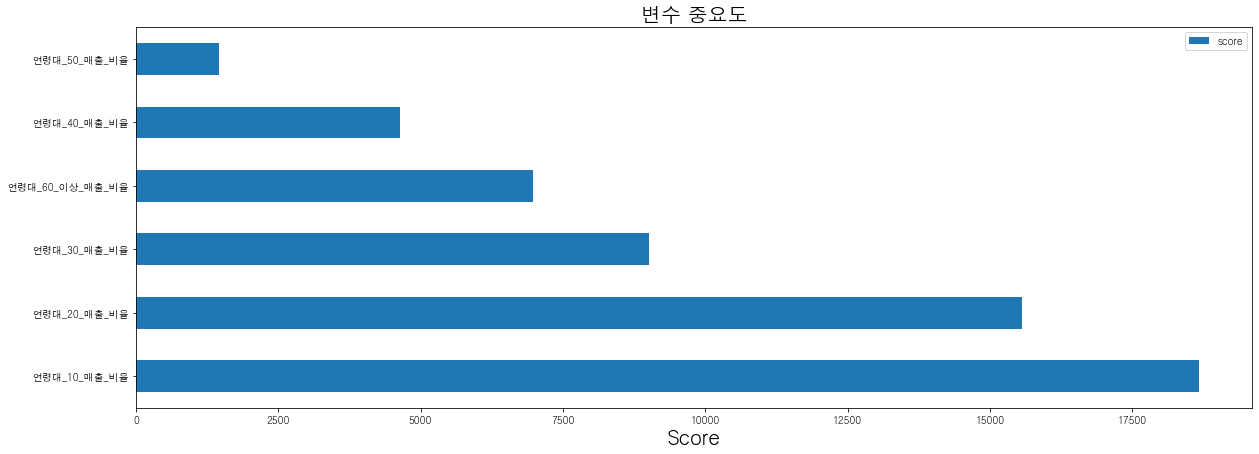

In [28]:
# 중요도 시각화

feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

fig, ax = plt.pyplot.subplots(figsize=(20,7))
data_50 = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_50[:10].plot(kind='barh', ax = ax, label = '')
ax.set_title('변수 중요도', size = 20)
ax.set_xlabel('Score', size = 20)

## 4. 모델링 - 요일별
### (1) 전처리

In [29]:
df.columns

Index(['Unnamed: 0', '기준_년_코드', '기준_분기_코드', '서비스_업종_코드', '점포_수', '유사_업종_점포_수',
       '개업_율', '개업_점포_수', '폐업_률', '폐업_점포_수', '프랜차이즈_점포_수', '당월_매출_금액',
       '당월_매출_건수', '주중_매출_비율', '주말_매출_비율', '월요일_매출_비율', '화요일_매출_비율',
       '수요일_매출_비율', '목요일_매출_비율', '금요일_매출_비율', '토요일_매출_비율', '일요일_매출_비율',
       '시간대_00~06_매출_비율', '시간대_06~11_매출_비율', '시간대_11~14_매출_비율',
       '시간대_14~17_매출_비율', '시간대_17~21_매출_비율', '시간대_21~24_매출_비율', '남성_매출_비율',
       '여성_매출_비율', '연령대_10_매출_비율', '연령대_20_매출_비율', '연령대_30_매출_비율',
       '연령대_40_매출_비율', '연령대_50_매출_비율', '연령대_60_이상_매출_비율', '주중_매출_금액',
       '주말_매출_금액', '월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액',
       '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액', '시간대_00~06_매출_금액',
       '시간대_06~11_매출_금액', '시간대_11~14_매출_금액', '시간대_14~17_매출_금액',
       '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액', '여성_매출_금액',
       '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액',
       '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수', '주말_매출_건수', '월요일_매출_건수',
       '화요일_매

In [30]:
df_new = df[['기준_년_코드', '기준_분기_코드', '서비스_업종_코드', '월요일_매출_비율', '화요일_매출_비율',
       '수요일_매출_비율', '목요일_매출_비율', '금요일_매출_비율', '토요일_매출_비율', '일요일_매출_비율', '폐업_률']]
df_new

,기준_년_코드,기준_분기_코드,서비스_업종_코드,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,목요일_매출_비율,금요일_매출_비율,토요일_매출_비율,일요일_매출_비율,폐업_률
0,2015,1,CS100001,0.33,0.33,0.00,0.00,0.00,0.80,1.00,3
1,2015,2,CS100001,0.00,0.33,0.50,0.00,0.00,0.60,0.75,5
2,2015,3,CS100001,0.00,0.00,1.00,0.00,0.00,0.60,0.75,4
3,2015,4,CS100001,0.00,0.33,0.00,0.50,0.00,0.60,1.00,3
4,2016,1,CS100001,0.00,0.33,0.50,0.50,0.00,0.80,0.75,4
5,2016,2,CS100001,0.33,0.33,0.50,0.00,0.00,0.60,0.75,5
6,2016,3,CS100001,0.33,0.33,0.50,0.00,1.00,0.40,0.75,6
7,2016,4,CS100001,0.00,0.33,0.50,0.00,0.00,1.00,0.75,2
8,2017,1,CS100001,0.33,0.67,0.50,0.50,0.00,0.40,0.75,2
9,2017,2,CS100001,0.33,0.33,0.50,0.50,0.00,0.60,0.75,4


In [31]:
# dataframe 행 순서 조정

a = df_new.iloc[20]
df_new = df_new.drop(20)
df_new = df_new.append(a)
df_new = df_new.reset_index(drop = True)
df_new

,기준_년_코드,기준_분기_코드,서비스_업종_코드,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,목요일_매출_비율,금요일_매출_비율,토요일_매출_비율,일요일_매출_비율,폐업_률
0,2015,1,CS100001,0.33,0.33,0.00,0.00,0.00,0.80,1.00,3
1,2015,2,CS100001,0.00,0.33,0.50,0.00,0.00,0.60,0.75,5
2,2015,3,CS100001,0.00,0.00,1.00,0.00,0.00,0.60,0.75,4
3,2015,4,CS100001,0.00,0.33,0.00,0.50,0.00,0.60,1.00,3
4,2016,1,CS100001,0.00,0.33,0.50,0.50,0.00,0.80,0.75,4
5,2016,2,CS100001,0.33,0.33,0.50,0.00,0.00,0.60,0.75,5
6,2016,3,CS100001,0.33,0.33,0.50,0.00,1.00,0.40,0.75,6
7,2016,4,CS100001,0.00,0.33,0.50,0.00,0.00,1.00,0.75,2
8,2017,1,CS100001,0.33,0.67,0.50,0.50,0.00,0.40,0.75,2
9,2017,2,CS100001,0.33,0.33,0.50,0.50,0.00,0.60,0.75,4


In [32]:
# 2020-3분기 예측에 사용되는 'X_predict' 데이터 추출

x_predict = pd.DataFrame(columns = df_new.columns)
x_predict = x_predict.append(df_new.iloc[21,:])
x_predict = x_predict.drop(['기준_년_코드', '기준_분기_코드', '서비스_업종_코드', '폐업_률'], axis = 1)
x_predict

,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,목요일_매출_비율,금요일_매출_비율,토요일_매출_비율,일요일_매출_비율
21,0.67,0.67,1.00,1.00,1.00,0.00,0.00


In [33]:
# 인풋 데이터 추출

x = df_new.drop('폐업_률', axis = 1).drop(21).reset_index(drop = True)
x

,기준_년_코드,기준_분기_코드,서비스_업종_코드,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,목요일_매출_비율,금요일_매출_비율,토요일_매출_비율,일요일_매출_비율
0,2015,1,CS100001,0.33,0.33,0.00,0.00,0.00,0.80,1.00
1,2015,2,CS100001,0.00,0.33,0.50,0.00,0.00,0.60,0.75
2,2015,3,CS100001,0.00,0.00,1.00,0.00,0.00,0.60,0.75
3,2015,4,CS100001,0.00,0.33,0.00,0.50,0.00,0.60,1.00
4,2016,1,CS100001,0.00,0.33,0.50,0.50,0.00,0.80,0.75
5,2016,2,CS100001,0.33,0.33,0.50,0.00,0.00,0.60,0.75
6,2016,3,CS100001,0.33,0.33,0.50,0.00,1.00,0.40,0.75
7,2016,4,CS100001,0.00,0.33,0.50,0.00,0.00,1.00,0.75
8,2017,1,CS100001,0.33,0.67,0.50,0.50,0.00,0.40,0.75
9,2017,2,CS100001,0.33,0.33,0.50,0.50,0.00,0.60,0.75


In [34]:
# x와 y를 하나로 merge

xy_train = pd.merge(x, y_new, how = 'left', on = ['기준_년_코드', '기준_분기_코드'])
xy_train

,기준_년_코드,기준_분기_코드,서비스_업종_코드,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,목요일_매출_비율,금요일_매출_비율,토요일_매출_비율,일요일_매출_비율,폐업_률
0,2015,1,CS100001,0.33,0.33,0.00,0.00,0.00,0.80,1.00,5
1,2015,2,CS100001,0.00,0.33,0.50,0.00,0.00,0.60,0.75,4
2,2015,3,CS100001,0.00,0.00,1.00,0.00,0.00,0.60,0.75,3
3,2015,4,CS100001,0.00,0.33,0.00,0.50,0.00,0.60,1.00,4
4,2016,1,CS100001,0.00,0.33,0.50,0.50,0.00,0.80,0.75,5
5,2016,2,CS100001,0.33,0.33,0.50,0.00,0.00,0.60,0.75,6
6,2016,3,CS100001,0.33,0.33,0.50,0.00,1.00,0.40,0.75,2
7,2016,4,CS100001,0.00,0.33,0.50,0.00,0.00,1.00,0.75,2
8,2017,1,CS100001,0.33,0.67,0.50,0.50,0.00,0.40,0.75,4
9,2017,2,CS100001,0.33,0.33,0.50,0.50,0.00,0.60,0.75,3


In [35]:
# 불필요한 column 삭제

xy_train_new = xy_train.drop(['기준_년_코드', '기준_분기_코드', '서비스_업종_코드'], axis = 1)
xy_train_new

,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,목요일_매출_비율,금요일_매출_비율,토요일_매출_비율,일요일_매출_비율,폐업_률
0,0.33,0.33,0.00,0.00,0.00,0.80,1.00,5
1,0.00,0.33,0.50,0.00,0.00,0.60,0.75,4
2,0.00,0.00,1.00,0.00,0.00,0.60,0.75,3
3,0.00,0.33,0.00,0.50,0.00,0.60,1.00,4
4,0.00,0.33,0.50,0.50,0.00,0.80,0.75,5
5,0.33,0.33,0.50,0.00,0.00,0.60,0.75,6
6,0.33,0.33,0.50,0.00,1.00,0.40,0.75,2
7,0.00,0.33,0.50,0.00,0.00,1.00,0.75,2
8,0.33,0.67,0.50,0.50,0.00,0.40,0.75,4
9,0.33,0.33,0.50,0.50,0.00,0.60,0.75,3


### (2) 모델링

In [36]:
start = time.time()  # 시작 시간 저장

x_in = xy_train_new.drop('폐업_률', axis = 1)
x_out = xy_train_new['폐업_률']

# 생존율로 변환
total = 100
x_out = total - x_out

# train, test 데이터 
X_train, X_test, y_train, y_test= train_test_split(x_in, x_out, test_size=0.2, random_state=42)

In [37]:
# xgboost 학습

model = XGBRegressor(booster="gbtree", objective ='reg:squarederror', n_estimators=12000, learning_rate=0.001 ,
                      max_depth=12, n_jobs = -1,subsample=0.75, reg_lambda=1, colsample_bytree=1, gamma=0, )

eval_set = [(X_test, y_test)]

model.fit(X_train,y_train, eval_set=eval_set, verbose=True)

pred_y = model.predict(X_test)

#predictions = [round(value) for value in xgb_5000_명동_pred ]
# evaluate predictions

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

[0]	validation_0-rmse:95.41333
[1]	validation_0-rmse:95.32425
[2]	validation_0-rmse:95.23433
[3]	validation_0-rmse:95.14635
[4]	validation_0-rmse:95.05764
[5]	validation_0-rmse:94.96960
[6]	validation_0-rmse:94.88163
[7]	validation_0-rmse:94.79261
[8]	validation_0-rmse:94.70481
[9]	validation_0-rmse:94.61733
[10]	validation_0-rmse:94.52843
[11]	validation_0-rmse:94.44160
[12]	validation_0-rmse:94.35287
[13]	validation_0-rmse:94.26580
[14]	validation_0-rmse:94.17675
[15]	validation_0-rmse:94.08759
[16]	validation_0-rmse:94.00330
[17]	validation_0-rmse:93.91869
[18]	validation_0-rmse:93.83185
[19]	validation_0-rmse:93.74526
[20]	validation_0-rmse:93.65803
[21]	validation_0-rmse:93.56967
[22]	validation_0-rmse:93.48299
[23]	validation_0-rmse:93.39593
[24]	validation_0-rmse:93.30871
[25]	validation_0-rmse:93.22276
[26]	validation_0-rmse:93.13528
[27]	validation_0-rmse:93.04817
[28]	validation_0-rmse:92.96413
[29]	validation_0-rmse:92.87724
[30]	validation_0-rmse:92.79022
[31]	validation_0-

[252]	validation_0-rmse:75.53378
[253]	validation_0-rmse:75.46500
[254]	validation_0-rmse:75.39438
[255]	validation_0-rmse:75.32368
[256]	validation_0-rmse:75.25472
[257]	validation_0-rmse:75.18604
[258]	validation_0-rmse:75.11733
[259]	validation_0-rmse:75.04695
[260]	validation_0-rmse:74.97745
[261]	validation_0-rmse:74.90747
[262]	validation_0-rmse:74.83763
[263]	validation_0-rmse:74.76751
[264]	validation_0-rmse:74.69686
[265]	validation_0-rmse:74.62781
[266]	validation_0-rmse:74.55757
[267]	validation_0-rmse:74.48805
[268]	validation_0-rmse:74.41804
[269]	validation_0-rmse:74.34888
[270]	validation_0-rmse:74.27863
[271]	validation_0-rmse:74.20888
[272]	validation_0-rmse:74.14189
[273]	validation_0-rmse:74.07386
[274]	validation_0-rmse:74.00398
[275]	validation_0-rmse:73.93459
[276]	validation_0-rmse:73.86665
[277]	validation_0-rmse:73.79793
[278]	validation_0-rmse:73.72890
[279]	validation_0-rmse:73.65975
[280]	validation_0-rmse:73.59140
[281]	validation_0-rmse:73.52438
[282]	vali

[501]	validation_0-rmse:59.92656
[502]	validation_0-rmse:59.87048
[503]	validation_0-rmse:59.81387
[504]	validation_0-rmse:59.75868
[505]	validation_0-rmse:59.70409
[506]	validation_0-rmse:59.64784
[507]	validation_0-rmse:59.59210
[508]	validation_0-rmse:59.53679
[509]	validation_0-rmse:59.48122
[510]	validation_0-rmse:59.42578
[511]	validation_0-rmse:59.37132
[512]	validation_0-rmse:59.31648
[513]	validation_0-rmse:59.26056
[514]	validation_0-rmse:59.20518
[515]	validation_0-rmse:59.14971
[516]	validation_0-rmse:59.09370
[517]	validation_0-rmse:59.03782
[518]	validation_0-rmse:58.98219
[519]	validation_0-rmse:58.92766
[520]	validation_0-rmse:58.87332
[521]	validation_0-rmse:58.81953
[522]	validation_0-rmse:58.76471
[523]	validation_0-rmse:58.70985
[524]	validation_0-rmse:58.65536
[525]	validation_0-rmse:58.60159
[526]	validation_0-rmse:58.54617
[527]	validation_0-rmse:58.49231
[528]	validation_0-rmse:58.43862
[529]	validation_0-rmse:58.38399
[530]	validation_0-rmse:58.32914
[531]	vali

[750]	validation_0-rmse:47.52972
[751]	validation_0-rmse:47.48460
[752]	validation_0-rmse:47.43956
[753]	validation_0-rmse:47.39508
[754]	validation_0-rmse:47.35051
[755]	validation_0-rmse:47.30612
[756]	validation_0-rmse:47.26154
[757]	validation_0-rmse:47.21744
[758]	validation_0-rmse:47.17408
[759]	validation_0-rmse:47.12965
[760]	validation_0-rmse:47.08506
[761]	validation_0-rmse:47.04183
[762]	validation_0-rmse:46.99825
[763]	validation_0-rmse:46.95373
[764]	validation_0-rmse:46.91019
[765]	validation_0-rmse:46.86589
[766]	validation_0-rmse:46.82179
[767]	validation_0-rmse:46.77741
[768]	validation_0-rmse:46.73342
[769]	validation_0-rmse:46.68992
[770]	validation_0-rmse:46.64705
[771]	validation_0-rmse:46.60292
[772]	validation_0-rmse:46.55930
[773]	validation_0-rmse:46.51604
[774]	validation_0-rmse:46.47265
[775]	validation_0-rmse:46.42995
[776]	validation_0-rmse:46.38685
[777]	validation_0-rmse:46.34365
[778]	validation_0-rmse:46.30060
[779]	validation_0-rmse:46.25702
[780]	vali

[999]	validation_0-rmse:37.65702
[1000]	validation_0-rmse:37.62196
[1001]	validation_0-rmse:37.58625
[1002]	validation_0-rmse:37.55139
[1003]	validation_0-rmse:37.51613
[1004]	validation_0-rmse:37.48179
[1005]	validation_0-rmse:37.44648
[1006]	validation_0-rmse:37.41130
[1007]	validation_0-rmse:37.37765
[1008]	validation_0-rmse:37.34352
[1009]	validation_0-rmse:37.30790
[1010]	validation_0-rmse:37.27261
[1011]	validation_0-rmse:37.23908
[1012]	validation_0-rmse:37.20437
[1013]	validation_0-rmse:37.16953
[1014]	validation_0-rmse:37.13452
[1015]	validation_0-rmse:37.09967
[1016]	validation_0-rmse:37.06472
[1017]	validation_0-rmse:37.02967
[1018]	validation_0-rmse:36.99496
[1019]	validation_0-rmse:36.95998
[1020]	validation_0-rmse:36.92531
[1021]	validation_0-rmse:36.89061
[1022]	validation_0-rmse:36.85600
[1023]	validation_0-rmse:36.82156
[1024]	validation_0-rmse:36.78728
[1025]	validation_0-rmse:36.75230
[1026]	validation_0-rmse:36.71779
[1027]	validation_0-rmse:36.68356
[1028]	validati

[1240]	validation_0-rmse:30.04575
[1241]	validation_0-rmse:30.01763
[1242]	validation_0-rmse:29.98881
[1243]	validation_0-rmse:29.96003
[1244]	validation_0-rmse:29.93208
[1245]	validation_0-rmse:29.90516
[1246]	validation_0-rmse:29.87690
[1247]	validation_0-rmse:29.84919
[1248]	validation_0-rmse:29.82084
[1249]	validation_0-rmse:29.79247
[1250]	validation_0-rmse:29.76451
[1251]	validation_0-rmse:29.73764
[1252]	validation_0-rmse:29.71005
[1253]	validation_0-rmse:29.68260
[1254]	validation_0-rmse:29.65456
[1255]	validation_0-rmse:29.62689
[1256]	validation_0-rmse:29.59925
[1257]	validation_0-rmse:29.57125
[1258]	validation_0-rmse:29.54410
[1259]	validation_0-rmse:29.51645
[1260]	validation_0-rmse:29.48875
[1261]	validation_0-rmse:29.46081
[1262]	validation_0-rmse:29.43441
[1263]	validation_0-rmse:29.40641
[1264]	validation_0-rmse:29.38040
[1265]	validation_0-rmse:29.35298
[1266]	validation_0-rmse:29.32521
[1267]	validation_0-rmse:29.29802
[1268]	validation_0-rmse:29.27107
[1269]	validat

[1481]	validation_0-rmse:23.95690
[1482]	validation_0-rmse:23.93396
[1483]	validation_0-rmse:23.91111
[1484]	validation_0-rmse:23.88849
[1485]	validation_0-rmse:23.86623
[1486]	validation_0-rmse:23.84344
[1487]	validation_0-rmse:23.82110
[1488]	validation_0-rmse:23.79869
[1489]	validation_0-rmse:23.77617
[1490]	validation_0-rmse:23.75494
[1491]	validation_0-rmse:23.73317
[1492]	validation_0-rmse:23.71153
[1493]	validation_0-rmse:23.68953
[1494]	validation_0-rmse:23.66669
[1495]	validation_0-rmse:23.64408
[1496]	validation_0-rmse:23.62178
[1497]	validation_0-rmse:23.59943
[1498]	validation_0-rmse:23.57765
[1499]	validation_0-rmse:23.55506
[1500]	validation_0-rmse:23.53348
[1501]	validation_0-rmse:23.51184
[1502]	validation_0-rmse:23.48989
[1503]	validation_0-rmse:23.46773
[1504]	validation_0-rmse:23.44582
[1505]	validation_0-rmse:23.42366
[1506]	validation_0-rmse:23.40241
[1507]	validation_0-rmse:23.38028
[1508]	validation_0-rmse:23.35837
[1509]	validation_0-rmse:23.33638
[1510]	validat

[1722]	validation_0-rmse:19.07916
[1723]	validation_0-rmse:19.06110
[1724]	validation_0-rmse:19.04307
[1725]	validation_0-rmse:19.02476
[1726]	validation_0-rmse:19.00676
[1727]	validation_0-rmse:18.98869
[1728]	validation_0-rmse:18.97064
[1729]	validation_0-rmse:18.95219
[1730]	validation_0-rmse:18.93458
[1731]	validation_0-rmse:18.91701
[1732]	validation_0-rmse:18.89886
[1733]	validation_0-rmse:18.88040
[1734]	validation_0-rmse:18.86227
[1735]	validation_0-rmse:18.84431
[1736]	validation_0-rmse:18.82614
[1737]	validation_0-rmse:18.80895
[1738]	validation_0-rmse:18.79149
[1739]	validation_0-rmse:18.77327
[1740]	validation_0-rmse:18.75588
[1741]	validation_0-rmse:18.73788
[1742]	validation_0-rmse:18.71971
[1743]	validation_0-rmse:18.70157
[1744]	validation_0-rmse:18.68387
[1745]	validation_0-rmse:18.66618
[1746]	validation_0-rmse:18.64858
[1747]	validation_0-rmse:18.63069
[1748]	validation_0-rmse:18.61313
[1749]	validation_0-rmse:18.59550
[1750]	validation_0-rmse:18.57813
[1751]	validat

[1963]	validation_0-rmse:15.17118
[1964]	validation_0-rmse:15.15633
[1965]	validation_0-rmse:15.14144
[1966]	validation_0-rmse:15.12726
[1967]	validation_0-rmse:15.11281
[1968]	validation_0-rmse:15.09846
[1969]	validation_0-rmse:15.08430
[1970]	validation_0-rmse:15.07009
[1971]	validation_0-rmse:15.05628
[1972]	validation_0-rmse:15.04209
[1973]	validation_0-rmse:15.02772
[1974]	validation_0-rmse:15.01322
[1975]	validation_0-rmse:14.99885
[1976]	validation_0-rmse:14.98445
[1977]	validation_0-rmse:14.97006
[1978]	validation_0-rmse:14.95588
[1979]	validation_0-rmse:14.94159
[1980]	validation_0-rmse:14.92705
[1981]	validation_0-rmse:14.91279
[1982]	validation_0-rmse:14.89835
[1983]	validation_0-rmse:14.88447
[1984]	validation_0-rmse:14.87017
[1985]	validation_0-rmse:14.85601
[1986]	validation_0-rmse:14.84179
[1987]	validation_0-rmse:14.82754
[1988]	validation_0-rmse:14.81322
[1989]	validation_0-rmse:14.79907
[1990]	validation_0-rmse:14.78465
[1991]	validation_0-rmse:14.77054
[1992]	validat

[2204]	validation_0-rmse:12.04729
[2205]	validation_0-rmse:12.03528
[2206]	validation_0-rmse:12.02361
[2207]	validation_0-rmse:12.01162
[2208]	validation_0-rmse:11.99987
[2209]	validation_0-rmse:11.98844
[2210]	validation_0-rmse:11.97679
[2211]	validation_0-rmse:11.96478
[2212]	validation_0-rmse:11.95334
[2213]	validation_0-rmse:11.94182
[2214]	validation_0-rmse:11.93024
[2215]	validation_0-rmse:11.91869
[2216]	validation_0-rmse:11.90764
[2217]	validation_0-rmse:11.89609
[2218]	validation_0-rmse:11.88483
[2219]	validation_0-rmse:11.87368
[2220]	validation_0-rmse:11.86196
[2221]	validation_0-rmse:11.85039
[2222]	validation_0-rmse:11.83892
[2223]	validation_0-rmse:11.82767
[2224]	validation_0-rmse:11.81650
[2225]	validation_0-rmse:11.80553
[2226]	validation_0-rmse:11.79428
[2227]	validation_0-rmse:11.78314
[2228]	validation_0-rmse:11.77176
[2229]	validation_0-rmse:11.76039
[2230]	validation_0-rmse:11.74930
[2231]	validation_0-rmse:11.73793
[2232]	validation_0-rmse:11.72665
[2233]	validat

[2447]	validation_0-rmse:9.52309
[2448]	validation_0-rmse:9.51365
[2449]	validation_0-rmse:9.50421
[2450]	validation_0-rmse:9.49486
[2451]	validation_0-rmse:9.48536
[2452]	validation_0-rmse:9.47615
[2453]	validation_0-rmse:9.46703
[2454]	validation_0-rmse:9.45778
[2455]	validation_0-rmse:9.44848
[2456]	validation_0-rmse:9.43931
[2457]	validation_0-rmse:9.43020
[2458]	validation_0-rmse:9.42098
[2459]	validation_0-rmse:9.41176
[2460]	validation_0-rmse:9.40241
[2461]	validation_0-rmse:9.39308
[2462]	validation_0-rmse:9.38407
[2463]	validation_0-rmse:9.37511
[2464]	validation_0-rmse:9.36614
[2465]	validation_0-rmse:9.35727
[2466]	validation_0-rmse:9.34824
[2467]	validation_0-rmse:9.33919
[2468]	validation_0-rmse:9.33042
[2469]	validation_0-rmse:9.32166
[2470]	validation_0-rmse:9.31255
[2471]	validation_0-rmse:9.30330
[2472]	validation_0-rmse:9.29442
[2473]	validation_0-rmse:9.28519
[2474]	validation_0-rmse:9.27626
[2475]	validation_0-rmse:9.26704
[2476]	validation_0-rmse:9.25826
[2477]	val

[2696]	validation_0-rmse:7.46167
[2697]	validation_0-rmse:7.45428
[2698]	validation_0-rmse:7.44698
[2699]	validation_0-rmse:7.43987
[2700]	validation_0-rmse:7.43386
[2701]	validation_0-rmse:7.42651
[2702]	validation_0-rmse:7.41916
[2703]	validation_0-rmse:7.41137
[2704]	validation_0-rmse:7.40411
[2705]	validation_0-rmse:7.39709
[2706]	validation_0-rmse:7.39003
[2707]	validation_0-rmse:7.38246
[2708]	validation_0-rmse:7.37530
[2709]	validation_0-rmse:7.36800
[2710]	validation_0-rmse:7.36064
[2711]	validation_0-rmse:7.35364
[2712]	validation_0-rmse:7.34652
[2713]	validation_0-rmse:7.33971
[2714]	validation_0-rmse:7.33252
[2715]	validation_0-rmse:7.32526
[2716]	validation_0-rmse:7.31801
[2717]	validation_0-rmse:7.31102
[2718]	validation_0-rmse:7.30371
[2719]	validation_0-rmse:7.29663
[2720]	validation_0-rmse:7.28933
[2721]	validation_0-rmse:7.28240
[2722]	validation_0-rmse:7.27519
[2723]	validation_0-rmse:7.26807
[2724]	validation_0-rmse:7.26133
[2725]	validation_0-rmse:7.25414
[2726]	val

[2945]	validation_0-rmse:5.82921
[2946]	validation_0-rmse:5.82351
[2947]	validation_0-rmse:5.81781
[2948]	validation_0-rmse:5.81253
[2949]	validation_0-rmse:5.80694
[2950]	validation_0-rmse:5.80147
[2951]	validation_0-rmse:5.79544
[2952]	validation_0-rmse:5.78946
[2953]	validation_0-rmse:5.78341
[2954]	validation_0-rmse:5.77775
[2955]	validation_0-rmse:5.77160
[2956]	validation_0-rmse:5.76588
[2957]	validation_0-rmse:5.76035
[2958]	validation_0-rmse:5.75471
[2959]	validation_0-rmse:5.74894
[2960]	validation_0-rmse:5.74331
[2961]	validation_0-rmse:5.73742
[2962]	validation_0-rmse:5.73165
[2963]	validation_0-rmse:5.72632
[2964]	validation_0-rmse:5.72030
[2965]	validation_0-rmse:5.71421
[2966]	validation_0-rmse:5.70847
[2967]	validation_0-rmse:5.70241
[2968]	validation_0-rmse:5.69706
[2969]	validation_0-rmse:5.69126
[2970]	validation_0-rmse:5.68560
[2971]	validation_0-rmse:5.67953
[2972]	validation_0-rmse:5.67412
[2973]	validation_0-rmse:5.66821
[2974]	validation_0-rmse:5.66265
[2975]	val

[3194]	validation_0-rmse:4.52074
[3195]	validation_0-rmse:4.51624
[3196]	validation_0-rmse:4.51131
[3197]	validation_0-rmse:4.50648
[3198]	validation_0-rmse:4.50147
[3199]	validation_0-rmse:4.49674
[3200]	validation_0-rmse:4.49169
[3201]	validation_0-rmse:4.48696
[3202]	validation_0-rmse:4.48216
[3203]	validation_0-rmse:4.47762
[3204]	validation_0-rmse:4.47360
[3205]	validation_0-rmse:4.46946
[3206]	validation_0-rmse:4.46458
[3207]	validation_0-rmse:4.45958
[3208]	validation_0-rmse:4.45464
[3209]	validation_0-rmse:4.45076
[3210]	validation_0-rmse:4.44580
[3211]	validation_0-rmse:4.44121
[3212]	validation_0-rmse:4.43633
[3213]	validation_0-rmse:4.43190
[3214]	validation_0-rmse:4.42710
[3215]	validation_0-rmse:4.42296
[3216]	validation_0-rmse:4.41854
[3217]	validation_0-rmse:4.41467
[3218]	validation_0-rmse:4.40984
[3219]	validation_0-rmse:4.40592
[3220]	validation_0-rmse:4.40149
[3221]	validation_0-rmse:4.39676
[3222]	validation_0-rmse:4.39205
[3223]	validation_0-rmse:4.38731
[3224]	val

[3443]	validation_0-rmse:3.48205
[3444]	validation_0-rmse:3.47821
[3445]	validation_0-rmse:3.47458
[3446]	validation_0-rmse:3.47131
[3447]	validation_0-rmse:3.46792
[3448]	validation_0-rmse:3.46389
[3449]	validation_0-rmse:3.46011
[3450]	validation_0-rmse:3.45583
[3451]	validation_0-rmse:3.45205
[3452]	validation_0-rmse:3.44809
[3453]	validation_0-rmse:3.44399
[3454]	validation_0-rmse:3.44041
[3455]	validation_0-rmse:3.43737
[3456]	validation_0-rmse:3.43386
[3457]	validation_0-rmse:3.42968
[3458]	validation_0-rmse:3.42666
[3459]	validation_0-rmse:3.42271
[3460]	validation_0-rmse:3.41892
[3461]	validation_0-rmse:3.41477
[3462]	validation_0-rmse:3.41076
[3463]	validation_0-rmse:3.40701
[3464]	validation_0-rmse:3.40380
[3465]	validation_0-rmse:3.40007
[3466]	validation_0-rmse:3.39603
[3467]	validation_0-rmse:3.39285
[3468]	validation_0-rmse:3.38932
[3469]	validation_0-rmse:3.38613
[3470]	validation_0-rmse:3.38220
[3471]	validation_0-rmse:3.37890
[3472]	validation_0-rmse:3.37573
[3473]	val

[3692]	validation_0-rmse:2.64467
[3693]	validation_0-rmse:2.64148
[3694]	validation_0-rmse:2.63895
[3695]	validation_0-rmse:2.63572
[3696]	validation_0-rmse:2.63317
[3697]	validation_0-rmse:2.63034
[3698]	validation_0-rmse:2.62729
[3699]	validation_0-rmse:2.62398
[3700]	validation_0-rmse:2.62094
[3701]	validation_0-rmse:2.61744
[3702]	validation_0-rmse:2.61425
[3703]	validation_0-rmse:2.61087
[3704]	validation_0-rmse:2.60775
[3705]	validation_0-rmse:2.60526
[3706]	validation_0-rmse:2.60236
[3707]	validation_0-rmse:2.59964
[3708]	validation_0-rmse:2.59643
[3709]	validation_0-rmse:2.59393
[3710]	validation_0-rmse:2.59127
[3711]	validation_0-rmse:2.58834
[3712]	validation_0-rmse:2.58523
[3713]	validation_0-rmse:2.58256
[3714]	validation_0-rmse:2.58035
[3715]	validation_0-rmse:2.57721
[3716]	validation_0-rmse:2.57408
[3717]	validation_0-rmse:2.57155
[3718]	validation_0-rmse:2.56925
[3719]	validation_0-rmse:2.56657
[3720]	validation_0-rmse:2.56349
[3721]	validation_0-rmse:2.56016
[3722]	val

[3941]	validation_0-rmse:1.98343
[3942]	validation_0-rmse:1.98092
[3943]	validation_0-rmse:1.97898
[3944]	validation_0-rmse:1.97654
[3945]	validation_0-rmse:1.97452
[3946]	validation_0-rmse:1.97257
[3947]	validation_0-rmse:1.97022
[3948]	validation_0-rmse:1.96834
[3949]	validation_0-rmse:1.96599
[3950]	validation_0-rmse:1.96421
[3951]	validation_0-rmse:1.96170
[3952]	validation_0-rmse:1.95931
[3953]	validation_0-rmse:1.95742
[3954]	validation_0-rmse:1.95527
[3955]	validation_0-rmse:1.95311
[3956]	validation_0-rmse:1.95068
[3957]	validation_0-rmse:1.94824
[3958]	validation_0-rmse:1.94552
[3959]	validation_0-rmse:1.94296
[3960]	validation_0-rmse:1.94053
[3961]	validation_0-rmse:1.93873
[3962]	validation_0-rmse:1.93615
[3963]	validation_0-rmse:1.93369
[3964]	validation_0-rmse:1.93144
[3965]	validation_0-rmse:1.92905
[3966]	validation_0-rmse:1.92663
[3967]	validation_0-rmse:1.92447
[3968]	validation_0-rmse:1.92199
[3969]	validation_0-rmse:1.91989
[3970]	validation_0-rmse:1.91826
[3971]	val

[4190]	validation_0-rmse:1.47465
[4191]	validation_0-rmse:1.47326
[4192]	validation_0-rmse:1.47144
[4193]	validation_0-rmse:1.46943
[4194]	validation_0-rmse:1.46748
[4195]	validation_0-rmse:1.46543
[4196]	validation_0-rmse:1.46401
[4197]	validation_0-rmse:1.46225
[4198]	validation_0-rmse:1.46033
[4199]	validation_0-rmse:1.45836
[4200]	validation_0-rmse:1.45700
[4201]	validation_0-rmse:1.45570
[4202]	validation_0-rmse:1.45436
[4203]	validation_0-rmse:1.45236
[4204]	validation_0-rmse:1.45043
[4205]	validation_0-rmse:1.44867
[4206]	validation_0-rmse:1.44735
[4207]	validation_0-rmse:1.44546
[4208]	validation_0-rmse:1.44366
[4209]	validation_0-rmse:1.44169
[4210]	validation_0-rmse:1.43992
[4211]	validation_0-rmse:1.43798
[4212]	validation_0-rmse:1.43614
[4213]	validation_0-rmse:1.43415
[4214]	validation_0-rmse:1.43250
[4215]	validation_0-rmse:1.43067
[4216]	validation_0-rmse:1.42955
[4217]	validation_0-rmse:1.42794
[4218]	validation_0-rmse:1.42666
[4219]	validation_0-rmse:1.42466
[4220]	val

[4439]	validation_0-rmse:1.08561
[4440]	validation_0-rmse:1.08404
[4441]	validation_0-rmse:1.08235
[4442]	validation_0-rmse:1.08068
[4443]	validation_0-rmse:1.07957
[4444]	validation_0-rmse:1.07828
[4445]	validation_0-rmse:1.07659
[4446]	validation_0-rmse:1.07471
[4447]	validation_0-rmse:1.07313
[4448]	validation_0-rmse:1.07181
[4449]	validation_0-rmse:1.07029
[4450]	validation_0-rmse:1.06916
[4451]	validation_0-rmse:1.06849
[4452]	validation_0-rmse:1.06705
[4453]	validation_0-rmse:1.06551
[4454]	validation_0-rmse:1.06417
[4455]	validation_0-rmse:1.06255
[4456]	validation_0-rmse:1.06120
[4457]	validation_0-rmse:1.06014
[4458]	validation_0-rmse:1.06034
[4459]	validation_0-rmse:1.05936
[4460]	validation_0-rmse:1.05793
[4461]	validation_0-rmse:1.05661
[4462]	validation_0-rmse:1.05523
[4463]	validation_0-rmse:1.05430
[4464]	validation_0-rmse:1.05271
[4465]	validation_0-rmse:1.05094
[4466]	validation_0-rmse:1.04958
[4467]	validation_0-rmse:1.04829
[4468]	validation_0-rmse:1.04715
[4469]	val

[4688]	validation_0-rmse:0.78208
[4689]	validation_0-rmse:0.78127
[4690]	validation_0-rmse:0.78014
[4691]	validation_0-rmse:0.77908
[4692]	validation_0-rmse:0.77807
[4693]	validation_0-rmse:0.77665
[4694]	validation_0-rmse:0.77591
[4695]	validation_0-rmse:0.77476
[4696]	validation_0-rmse:0.77436
[4697]	validation_0-rmse:0.77323
[4698]	validation_0-rmse:0.77257
[4699]	validation_0-rmse:0.77153
[4700]	validation_0-rmse:0.77080
[4701]	validation_0-rmse:0.76965
[4702]	validation_0-rmse:0.76852
[4703]	validation_0-rmse:0.76797
[4704]	validation_0-rmse:0.76733
[4705]	validation_0-rmse:0.76606
[4706]	validation_0-rmse:0.76497
[4707]	validation_0-rmse:0.76394
[4708]	validation_0-rmse:0.76323
[4709]	validation_0-rmse:0.76193
[4710]	validation_0-rmse:0.76081
[4711]	validation_0-rmse:0.75971
[4712]	validation_0-rmse:0.75878
[4713]	validation_0-rmse:0.75704
[4714]	validation_0-rmse:0.75594
[4715]	validation_0-rmse:0.75491
[4716]	validation_0-rmse:0.75379
[4717]	validation_0-rmse:0.75260
[4718]	val

[4937]	validation_0-rmse:0.56826
[4938]	validation_0-rmse:0.56783
[4939]	validation_0-rmse:0.56705
[4940]	validation_0-rmse:0.56625
[4941]	validation_0-rmse:0.56637
[4942]	validation_0-rmse:0.56565
[4943]	validation_0-rmse:0.56513
[4944]	validation_0-rmse:0.56467
[4945]	validation_0-rmse:0.56415
[4946]	validation_0-rmse:0.56326
[4947]	validation_0-rmse:0.56282
[4948]	validation_0-rmse:0.56224
[4949]	validation_0-rmse:0.56170
[4950]	validation_0-rmse:0.56079
[4951]	validation_0-rmse:0.56027
[4952]	validation_0-rmse:0.55949
[4953]	validation_0-rmse:0.55893
[4954]	validation_0-rmse:0.55801
[4955]	validation_0-rmse:0.55732
[4956]	validation_0-rmse:0.55642
[4957]	validation_0-rmse:0.55621
[4958]	validation_0-rmse:0.55555
[4959]	validation_0-rmse:0.55481
[4960]	validation_0-rmse:0.55431
[4961]	validation_0-rmse:0.55342
[4962]	validation_0-rmse:0.55300
[4963]	validation_0-rmse:0.55281
[4964]	validation_0-rmse:0.55232
[4965]	validation_0-rmse:0.55174
[4966]	validation_0-rmse:0.55124
[4967]	val

[5186]	validation_0-rmse:0.43138
[5187]	validation_0-rmse:0.43081
[5188]	validation_0-rmse:0.43058
[5189]	validation_0-rmse:0.43003
[5190]	validation_0-rmse:0.42969
[5191]	validation_0-rmse:0.42936
[5192]	validation_0-rmse:0.42871
[5193]	validation_0-rmse:0.42826
[5194]	validation_0-rmse:0.42784
[5195]	validation_0-rmse:0.42713
[5196]	validation_0-rmse:0.42690
[5197]	validation_0-rmse:0.42657
[5198]	validation_0-rmse:0.42641
[5199]	validation_0-rmse:0.42632
[5200]	validation_0-rmse:0.42610
[5201]	validation_0-rmse:0.42593
[5202]	validation_0-rmse:0.42576
[5203]	validation_0-rmse:0.42526
[5204]	validation_0-rmse:0.42540
[5205]	validation_0-rmse:0.42493
[5206]	validation_0-rmse:0.42466
[5207]	validation_0-rmse:0.42439
[5208]	validation_0-rmse:0.42438
[5209]	validation_0-rmse:0.42423
[5210]	validation_0-rmse:0.42397
[5211]	validation_0-rmse:0.42333
[5212]	validation_0-rmse:0.42352
[5213]	validation_0-rmse:0.42338
[5214]	validation_0-rmse:0.42283
[5215]	validation_0-rmse:0.42235
[5216]	val

[5435]	validation_0-rmse:0.37263
[5436]	validation_0-rmse:0.37288
[5437]	validation_0-rmse:0.37307
[5438]	validation_0-rmse:0.37293
[5439]	validation_0-rmse:0.37269
[5440]	validation_0-rmse:0.37301
[5441]	validation_0-rmse:0.37285
[5442]	validation_0-rmse:0.37311
[5443]	validation_0-rmse:0.37320
[5444]	validation_0-rmse:0.37296
[5445]	validation_0-rmse:0.37304
[5446]	validation_0-rmse:0.37316
[5447]	validation_0-rmse:0.37310
[5448]	validation_0-rmse:0.37317
[5449]	validation_0-rmse:0.37301
[5450]	validation_0-rmse:0.37292
[5451]	validation_0-rmse:0.37294
[5452]	validation_0-rmse:0.37303
[5453]	validation_0-rmse:0.37376
[5454]	validation_0-rmse:0.37399
[5455]	validation_0-rmse:0.37402
[5456]	validation_0-rmse:0.37431
[5457]	validation_0-rmse:0.37461
[5458]	validation_0-rmse:0.37471
[5459]	validation_0-rmse:0.37494
[5460]	validation_0-rmse:0.37503
[5461]	validation_0-rmse:0.37470
[5462]	validation_0-rmse:0.37492
[5463]	validation_0-rmse:0.37527
[5464]	validation_0-rmse:0.37511
[5465]	val

[5684]	validation_0-rmse:0.39887
[5685]	validation_0-rmse:0.39920
[5686]	validation_0-rmse:0.39945
[5687]	validation_0-rmse:0.39974
[5688]	validation_0-rmse:0.39978
[5689]	validation_0-rmse:0.40009
[5690]	validation_0-rmse:0.39986
[5691]	validation_0-rmse:0.39990
[5692]	validation_0-rmse:0.40031
[5693]	validation_0-rmse:0.40032
[5694]	validation_0-rmse:0.40057
[5695]	validation_0-rmse:0.40079
[5696]	validation_0-rmse:0.40105
[5697]	validation_0-rmse:0.40171
[5698]	validation_0-rmse:0.40202
[5699]	validation_0-rmse:0.40170
[5700]	validation_0-rmse:0.40158
[5701]	validation_0-rmse:0.40186
[5702]	validation_0-rmse:0.40208
[5703]	validation_0-rmse:0.40265
[5704]	validation_0-rmse:0.40275
[5705]	validation_0-rmse:0.40314
[5706]	validation_0-rmse:0.40325
[5707]	validation_0-rmse:0.40389
[5708]	validation_0-rmse:0.40456
[5709]	validation_0-rmse:0.40436
[5710]	validation_0-rmse:0.40458
[5711]	validation_0-rmse:0.40486
[5712]	validation_0-rmse:0.40514
[5713]	validation_0-rmse:0.40514
[5714]	val

[5933]	validation_0-rmse:0.46923
[5934]	validation_0-rmse:0.46962
[5935]	validation_0-rmse:0.47037
[5936]	validation_0-rmse:0.47093
[5937]	validation_0-rmse:0.47125
[5938]	validation_0-rmse:0.47121
[5939]	validation_0-rmse:0.47154
[5940]	validation_0-rmse:0.47145
[5941]	validation_0-rmse:0.47135
[5942]	validation_0-rmse:0.47187
[5943]	validation_0-rmse:0.47177
[5944]	validation_0-rmse:0.47213
[5945]	validation_0-rmse:0.47210
[5946]	validation_0-rmse:0.47201
[5947]	validation_0-rmse:0.47187
[5948]	validation_0-rmse:0.47174
[5949]	validation_0-rmse:0.47203
[5950]	validation_0-rmse:0.47238
[5951]	validation_0-rmse:0.47225
[5952]	validation_0-rmse:0.47260
[5953]	validation_0-rmse:0.47273
[5954]	validation_0-rmse:0.47288
[5955]	validation_0-rmse:0.47323
[5956]	validation_0-rmse:0.47379
[5957]	validation_0-rmse:0.47436
[5958]	validation_0-rmse:0.47466
[5959]	validation_0-rmse:0.47500
[5960]	validation_0-rmse:0.47513
[5961]	validation_0-rmse:0.47488
[5962]	validation_0-rmse:0.47541
[5963]	val

[6182]	validation_0-rmse:0.54931
[6183]	validation_0-rmse:0.54970
[6184]	validation_0-rmse:0.54978
[6185]	validation_0-rmse:0.55010
[6186]	validation_0-rmse:0.55045
[6187]	validation_0-rmse:0.55087
[6188]	validation_0-rmse:0.55158
[6189]	validation_0-rmse:0.55213
[6190]	validation_0-rmse:0.55290
[6191]	validation_0-rmse:0.55328
[6192]	validation_0-rmse:0.55382
[6193]	validation_0-rmse:0.55422
[6194]	validation_0-rmse:0.55428
[6195]	validation_0-rmse:0.55418
[6196]	validation_0-rmse:0.55425
[6197]	validation_0-rmse:0.55467
[6198]	validation_0-rmse:0.55488
[6199]	validation_0-rmse:0.55564
[6200]	validation_0-rmse:0.55597
[6201]	validation_0-rmse:0.55628
[6202]	validation_0-rmse:0.55687
[6203]	validation_0-rmse:0.55720
[6204]	validation_0-rmse:0.55753
[6205]	validation_0-rmse:0.55790
[6206]	validation_0-rmse:0.55843
[6207]	validation_0-rmse:0.55884
[6208]	validation_0-rmse:0.55926
[6209]	validation_0-rmse:0.55965
[6210]	validation_0-rmse:0.55968
[6211]	validation_0-rmse:0.56003
[6212]	val

[6431]	validation_0-rmse:0.63313
[6432]	validation_0-rmse:0.63305
[6433]	validation_0-rmse:0.63328
[6434]	validation_0-rmse:0.63382
[6435]	validation_0-rmse:0.63453
[6436]	validation_0-rmse:0.63510
[6437]	validation_0-rmse:0.63567
[6438]	validation_0-rmse:0.63574
[6439]	validation_0-rmse:0.63610
[6440]	validation_0-rmse:0.63640
[6441]	validation_0-rmse:0.63674
[6442]	validation_0-rmse:0.63710
[6443]	validation_0-rmse:0.63715
[6444]	validation_0-rmse:0.63738
[6445]	validation_0-rmse:0.63762
[6446]	validation_0-rmse:0.63815
[6447]	validation_0-rmse:0.63886
[6448]	validation_0-rmse:0.63932
[6449]	validation_0-rmse:0.64003
[6450]	validation_0-rmse:0.64055
[6451]	validation_0-rmse:0.64107
[6452]	validation_0-rmse:0.64125
[6453]	validation_0-rmse:0.64151
[6454]	validation_0-rmse:0.64153
[6455]	validation_0-rmse:0.64172
[6456]	validation_0-rmse:0.64188
[6457]	validation_0-rmse:0.64187
[6458]	validation_0-rmse:0.64225
[6459]	validation_0-rmse:0.64247
[6460]	validation_0-rmse:0.64318
[6461]	val

[6680]	validation_0-rmse:0.71437
[6681]	validation_0-rmse:0.71473
[6682]	validation_0-rmse:0.71509
[6683]	validation_0-rmse:0.71559
[6684]	validation_0-rmse:0.71595
[6685]	validation_0-rmse:0.71644
[6686]	validation_0-rmse:0.71679
[6687]	validation_0-rmse:0.71698
[6688]	validation_0-rmse:0.71733
[6689]	validation_0-rmse:0.71776
[6690]	validation_0-rmse:0.71812
[6691]	validation_0-rmse:0.71835
[6692]	validation_0-rmse:0.71868
[6693]	validation_0-rmse:0.71909
[6694]	validation_0-rmse:0.71910
[6695]	validation_0-rmse:0.71948
[6696]	validation_0-rmse:0.71972
[6697]	validation_0-rmse:0.72007
[6698]	validation_0-rmse:0.72042
[6699]	validation_0-rmse:0.72095
[6700]	validation_0-rmse:0.72130
[6701]	validation_0-rmse:0.72197
[6702]	validation_0-rmse:0.72246
[6703]	validation_0-rmse:0.72282
[6704]	validation_0-rmse:0.72317
[6705]	validation_0-rmse:0.72343
[6706]	validation_0-rmse:0.72376
[6707]	validation_0-rmse:0.72411
[6708]	validation_0-rmse:0.72441
[6709]	validation_0-rmse:0.72435
[6710]	val

[6929]	validation_0-rmse:0.79088
[6930]	validation_0-rmse:0.79134
[6931]	validation_0-rmse:0.79167
[6932]	validation_0-rmse:0.79184
[6933]	validation_0-rmse:0.79190
[6934]	validation_0-rmse:0.79214
[6935]	validation_0-rmse:0.79202
[6936]	validation_0-rmse:0.79235
[6937]	validation_0-rmse:0.79254
[6938]	validation_0-rmse:0.79276
[6939]	validation_0-rmse:0.79324
[6940]	validation_0-rmse:0.79368
[6941]	validation_0-rmse:0.79391
[6942]	validation_0-rmse:0.79437
[6943]	validation_0-rmse:0.79466
[6944]	validation_0-rmse:0.79506
[6945]	validation_0-rmse:0.79539
[6946]	validation_0-rmse:0.79572
[6947]	validation_0-rmse:0.79600
[6948]	validation_0-rmse:0.79632
[6949]	validation_0-rmse:0.79665
[6950]	validation_0-rmse:0.79650
[6951]	validation_0-rmse:0.79673
[6952]	validation_0-rmse:0.79717
[6953]	validation_0-rmse:0.79762
[6954]	validation_0-rmse:0.79789
[6955]	validation_0-rmse:0.79790
[6956]	validation_0-rmse:0.79829
[6957]	validation_0-rmse:0.79891
[6958]	validation_0-rmse:0.79954
[6959]	val

[7178]	validation_0-rmse:0.85900
[7179]	validation_0-rmse:0.85940
[7180]	validation_0-rmse:0.85981
[7181]	validation_0-rmse:0.85997
[7182]	validation_0-rmse:0.86021
[7183]	validation_0-rmse:0.86042
[7184]	validation_0-rmse:0.86085
[7185]	validation_0-rmse:0.86122
[7186]	validation_0-rmse:0.86153
[7187]	validation_0-rmse:0.86184
[7188]	validation_0-rmse:0.86203
[7189]	validation_0-rmse:0.86246
[7190]	validation_0-rmse:0.86263
[7191]	validation_0-rmse:0.86286
[7192]	validation_0-rmse:0.86305
[7193]	validation_0-rmse:0.86304
[7194]	validation_0-rmse:0.86340
[7195]	validation_0-rmse:0.86378
[7196]	validation_0-rmse:0.86371
[7197]	validation_0-rmse:0.86392
[7198]	validation_0-rmse:0.86418
[7199]	validation_0-rmse:0.86415
[7200]	validation_0-rmse:0.86430
[7201]	validation_0-rmse:0.86446
[7202]	validation_0-rmse:0.86442
[7203]	validation_0-rmse:0.86482
[7204]	validation_0-rmse:0.86473
[7205]	validation_0-rmse:0.86477
[7206]	validation_0-rmse:0.86515
[7207]	validation_0-rmse:0.86544
[7208]	val

[7427]	validation_0-rmse:0.91810
[7428]	validation_0-rmse:0.91851
[7429]	validation_0-rmse:0.91865
[7430]	validation_0-rmse:0.91909
[7431]	validation_0-rmse:0.91964
[7432]	validation_0-rmse:0.91991
[7433]	validation_0-rmse:0.92012
[7434]	validation_0-rmse:0.92027
[7435]	validation_0-rmse:0.92027
[7436]	validation_0-rmse:0.92082
[7437]	validation_0-rmse:0.92119
[7438]	validation_0-rmse:0.92114
[7439]	validation_0-rmse:0.92141
[7440]	validation_0-rmse:0.92158
[7441]	validation_0-rmse:0.92191
[7442]	validation_0-rmse:0.92206
[7443]	validation_0-rmse:0.92220
[7444]	validation_0-rmse:0.92236
[7445]	validation_0-rmse:0.92265
[7446]	validation_0-rmse:0.92265
[7447]	validation_0-rmse:0.92309
[7448]	validation_0-rmse:0.92310
[7449]	validation_0-rmse:0.92321
[7450]	validation_0-rmse:0.92323
[7451]	validation_0-rmse:0.92313
[7452]	validation_0-rmse:0.92341
[7453]	validation_0-rmse:0.92355
[7454]	validation_0-rmse:0.92368
[7455]	validation_0-rmse:0.92368
[7456]	validation_0-rmse:0.92407
[7457]	val

[7676]	validation_0-rmse:0.97208
[7677]	validation_0-rmse:0.97234
[7678]	validation_0-rmse:0.97243
[7679]	validation_0-rmse:0.97269
[7680]	validation_0-rmse:0.97279
[7681]	validation_0-rmse:0.97301
[7682]	validation_0-rmse:0.97315
[7683]	validation_0-rmse:0.97366
[7684]	validation_0-rmse:0.97374
[7685]	validation_0-rmse:0.97395
[7686]	validation_0-rmse:0.97432
[7687]	validation_0-rmse:0.97424
[7688]	validation_0-rmse:0.97421
[7689]	validation_0-rmse:0.97438
[7690]	validation_0-rmse:0.97461
[7691]	validation_0-rmse:0.97475
[7692]	validation_0-rmse:0.97504
[7693]	validation_0-rmse:0.97505
[7694]	validation_0-rmse:0.97546
[7695]	validation_0-rmse:0.97548
[7696]	validation_0-rmse:0.97547
[7697]	validation_0-rmse:0.97573
[7698]	validation_0-rmse:0.97599
[7699]	validation_0-rmse:0.97618
[7700]	validation_0-rmse:0.97628
[7701]	validation_0-rmse:0.97645
[7702]	validation_0-rmse:0.97663
[7703]	validation_0-rmse:0.97665
[7704]	validation_0-rmse:0.97664
[7705]	validation_0-rmse:0.97666
[7706]	val

[7925]	validation_0-rmse:1.01792
[7926]	validation_0-rmse:1.01794
[7927]	validation_0-rmse:1.01813
[7928]	validation_0-rmse:1.01835
[7929]	validation_0-rmse:1.01869
[7930]	validation_0-rmse:1.01845
[7931]	validation_0-rmse:1.01846
[7932]	validation_0-rmse:1.01866
[7933]	validation_0-rmse:1.01900
[7934]	validation_0-rmse:1.01924
[7935]	validation_0-rmse:1.01934
[7936]	validation_0-rmse:1.01958
[7937]	validation_0-rmse:1.01983
[7938]	validation_0-rmse:1.02012
[7939]	validation_0-rmse:1.02026
[7940]	validation_0-rmse:1.02040
[7941]	validation_0-rmse:1.02065
[7942]	validation_0-rmse:1.02066
[7943]	validation_0-rmse:1.02114
[7944]	validation_0-rmse:1.02109
[7945]	validation_0-rmse:1.02143
[7946]	validation_0-rmse:1.02184
[7947]	validation_0-rmse:1.02191
[7948]	validation_0-rmse:1.02212
[7949]	validation_0-rmse:1.02258
[7950]	validation_0-rmse:1.02258
[7951]	validation_0-rmse:1.02286
[7952]	validation_0-rmse:1.02320
[7953]	validation_0-rmse:1.02339
[7954]	validation_0-rmse:1.02321
[7955]	val

[8174]	validation_0-rmse:1.06663
[8175]	validation_0-rmse:1.06687
[8176]	validation_0-rmse:1.06697
[8177]	validation_0-rmse:1.06738
[8178]	validation_0-rmse:1.06754
[8179]	validation_0-rmse:1.06777
[8180]	validation_0-rmse:1.06785
[8181]	validation_0-rmse:1.06817
[8182]	validation_0-rmse:1.06825
[8183]	validation_0-rmse:1.06818
[8184]	validation_0-rmse:1.06810
[8185]	validation_0-rmse:1.06813
[8186]	validation_0-rmse:1.06824
[8187]	validation_0-rmse:1.06868
[8188]	validation_0-rmse:1.06903
[8189]	validation_0-rmse:1.06915
[8190]	validation_0-rmse:1.06937
[8191]	validation_0-rmse:1.06914
[8192]	validation_0-rmse:1.06932
[8193]	validation_0-rmse:1.06960
[8194]	validation_0-rmse:1.06987
[8195]	validation_0-rmse:1.07014
[8196]	validation_0-rmse:1.07003
[8197]	validation_0-rmse:1.07031
[8198]	validation_0-rmse:1.07030
[8199]	validation_0-rmse:1.07058
[8200]	validation_0-rmse:1.07079
[8201]	validation_0-rmse:1.07097
[8202]	validation_0-rmse:1.07107
[8203]	validation_0-rmse:1.07106
[8204]	val

[8423]	validation_0-rmse:1.10736
[8424]	validation_0-rmse:1.10766
[8425]	validation_0-rmse:1.10771
[8426]	validation_0-rmse:1.10793
[8427]	validation_0-rmse:1.10817
[8428]	validation_0-rmse:1.10818
[8429]	validation_0-rmse:1.10829
[8430]	validation_0-rmse:1.10863
[8431]	validation_0-rmse:1.10860
[8432]	validation_0-rmse:1.10889
[8433]	validation_0-rmse:1.10921
[8434]	validation_0-rmse:1.10943
[8435]	validation_0-rmse:1.10949
[8436]	validation_0-rmse:1.10979
[8437]	validation_0-rmse:1.10985
[8438]	validation_0-rmse:1.11011
[8439]	validation_0-rmse:1.11019
[8440]	validation_0-rmse:1.11060
[8441]	validation_0-rmse:1.11093
[8442]	validation_0-rmse:1.11097
[8443]	validation_0-rmse:1.11088
[8444]	validation_0-rmse:1.11102
[8445]	validation_0-rmse:1.11129
[8446]	validation_0-rmse:1.11160
[8447]	validation_0-rmse:1.11155
[8448]	validation_0-rmse:1.11159
[8449]	validation_0-rmse:1.11201
[8450]	validation_0-rmse:1.11238
[8451]	validation_0-rmse:1.11267
[8452]	validation_0-rmse:1.11271
[8453]	val

[8672]	validation_0-rmse:1.14601
[8673]	validation_0-rmse:1.14614
[8674]	validation_0-rmse:1.14629
[8675]	validation_0-rmse:1.14621
[8676]	validation_0-rmse:1.14620
[8677]	validation_0-rmse:1.14641
[8678]	validation_0-rmse:1.14659
[8679]	validation_0-rmse:1.14688
[8680]	validation_0-rmse:1.14712
[8681]	validation_0-rmse:1.14725
[8682]	validation_0-rmse:1.14722
[8683]	validation_0-rmse:1.14729
[8684]	validation_0-rmse:1.14752
[8685]	validation_0-rmse:1.14783
[8686]	validation_0-rmse:1.14781
[8687]	validation_0-rmse:1.14788
[8688]	validation_0-rmse:1.14804
[8689]	validation_0-rmse:1.14805
[8690]	validation_0-rmse:1.14828
[8691]	validation_0-rmse:1.14823
[8692]	validation_0-rmse:1.14820
[8693]	validation_0-rmse:1.14851
[8694]	validation_0-rmse:1.14853
[8695]	validation_0-rmse:1.14872
[8696]	validation_0-rmse:1.14897
[8697]	validation_0-rmse:1.14931
[8698]	validation_0-rmse:1.14934
[8699]	validation_0-rmse:1.14969
[8700]	validation_0-rmse:1.14973
[8701]	validation_0-rmse:1.14978
[8702]	val

[8921]	validation_0-rmse:1.18170
[8922]	validation_0-rmse:1.18167
[8923]	validation_0-rmse:1.18158
[8924]	validation_0-rmse:1.18191
[8925]	validation_0-rmse:1.18225
[8926]	validation_0-rmse:1.18233
[8927]	validation_0-rmse:1.18224
[8928]	validation_0-rmse:1.18216
[8929]	validation_0-rmse:1.18228
[8930]	validation_0-rmse:1.18248
[8931]	validation_0-rmse:1.18264
[8932]	validation_0-rmse:1.18294
[8933]	validation_0-rmse:1.18311
[8934]	validation_0-rmse:1.18341
[8935]	validation_0-rmse:1.18355
[8936]	validation_0-rmse:1.18368
[8937]	validation_0-rmse:1.18362
[8938]	validation_0-rmse:1.18382
[8939]	validation_0-rmse:1.18402
[8940]	validation_0-rmse:1.18400
[8941]	validation_0-rmse:1.18416
[8942]	validation_0-rmse:1.18442
[8943]	validation_0-rmse:1.18444
[8944]	validation_0-rmse:1.18464
[8945]	validation_0-rmse:1.18484
[8946]	validation_0-rmse:1.18505
[8947]	validation_0-rmse:1.18527
[8948]	validation_0-rmse:1.18526
[8949]	validation_0-rmse:1.18554
[8950]	validation_0-rmse:1.18587
[8951]	val

[9170]	validation_0-rmse:1.21179
[9171]	validation_0-rmse:1.21181
[9172]	validation_0-rmse:1.21182
[9173]	validation_0-rmse:1.21201
[9174]	validation_0-rmse:1.21209
[9175]	validation_0-rmse:1.21217
[9176]	validation_0-rmse:1.21235
[9177]	validation_0-rmse:1.21241
[9178]	validation_0-rmse:1.21227
[9179]	validation_0-rmse:1.21254
[9180]	validation_0-rmse:1.21279
[9181]	validation_0-rmse:1.21284
[9182]	validation_0-rmse:1.21281
[9183]	validation_0-rmse:1.21279
[9184]	validation_0-rmse:1.21292
[9185]	validation_0-rmse:1.21287
[9186]	validation_0-rmse:1.21275
[9187]	validation_0-rmse:1.21273
[9188]	validation_0-rmse:1.21271
[9189]	validation_0-rmse:1.21277
[9190]	validation_0-rmse:1.21302
[9191]	validation_0-rmse:1.21323
[9192]	validation_0-rmse:1.21355
[9193]	validation_0-rmse:1.21364
[9194]	validation_0-rmse:1.21381
[9195]	validation_0-rmse:1.21373
[9196]	validation_0-rmse:1.21382
[9197]	validation_0-rmse:1.21373
[9198]	validation_0-rmse:1.21396
[9199]	validation_0-rmse:1.21407
[9200]	val

[9419]	validation_0-rmse:1.23625
[9420]	validation_0-rmse:1.23645
[9421]	validation_0-rmse:1.23662
[9422]	validation_0-rmse:1.23677
[9423]	validation_0-rmse:1.23695
[9424]	validation_0-rmse:1.23714
[9425]	validation_0-rmse:1.23743
[9426]	validation_0-rmse:1.23765
[9427]	validation_0-rmse:1.23785
[9428]	validation_0-rmse:1.23791
[9429]	validation_0-rmse:1.23814
[9430]	validation_0-rmse:1.23848
[9431]	validation_0-rmse:1.23877
[9432]	validation_0-rmse:1.23902
[9433]	validation_0-rmse:1.23924
[9434]	validation_0-rmse:1.23930
[9435]	validation_0-rmse:1.23942
[9436]	validation_0-rmse:1.23964
[9437]	validation_0-rmse:1.23978
[9438]	validation_0-rmse:1.23979
[9439]	validation_0-rmse:1.23978
[9440]	validation_0-rmse:1.23993
[9441]	validation_0-rmse:1.24011
[9442]	validation_0-rmse:1.24011
[9443]	validation_0-rmse:1.24043
[9444]	validation_0-rmse:1.24069
[9445]	validation_0-rmse:1.24081
[9446]	validation_0-rmse:1.24097
[9447]	validation_0-rmse:1.24123
[9448]	validation_0-rmse:1.24133
[9449]	val

[9668]	validation_0-rmse:1.26380
[9669]	validation_0-rmse:1.26385
[9670]	validation_0-rmse:1.26412
[9671]	validation_0-rmse:1.26416
[9672]	validation_0-rmse:1.26436
[9673]	validation_0-rmse:1.26435
[9674]	validation_0-rmse:1.26451
[9675]	validation_0-rmse:1.26455
[9676]	validation_0-rmse:1.26448
[9677]	validation_0-rmse:1.26439
[9678]	validation_0-rmse:1.26453
[9679]	validation_0-rmse:1.26469
[9680]	validation_0-rmse:1.26471
[9681]	validation_0-rmse:1.26494
[9682]	validation_0-rmse:1.26493
[9683]	validation_0-rmse:1.26504
[9684]	validation_0-rmse:1.26521
[9685]	validation_0-rmse:1.26541
[9686]	validation_0-rmse:1.26552
[9687]	validation_0-rmse:1.26565
[9688]	validation_0-rmse:1.26565
[9689]	validation_0-rmse:1.26593
[9690]	validation_0-rmse:1.26608
[9691]	validation_0-rmse:1.26613
[9692]	validation_0-rmse:1.26606
[9693]	validation_0-rmse:1.26620
[9694]	validation_0-rmse:1.26641
[9695]	validation_0-rmse:1.26656
[9696]	validation_0-rmse:1.26670
[9697]	validation_0-rmse:1.26687
[9698]	val

[9917]	validation_0-rmse:1.28916
[9918]	validation_0-rmse:1.28914
[9919]	validation_0-rmse:1.28906
[9920]	validation_0-rmse:1.28920
[9921]	validation_0-rmse:1.28922
[9922]	validation_0-rmse:1.28946
[9923]	validation_0-rmse:1.28971
[9924]	validation_0-rmse:1.28979
[9925]	validation_0-rmse:1.28983
[9926]	validation_0-rmse:1.28992
[9927]	validation_0-rmse:1.29005
[9928]	validation_0-rmse:1.29009
[9929]	validation_0-rmse:1.29017
[9930]	validation_0-rmse:1.29028
[9931]	validation_0-rmse:1.29041
[9932]	validation_0-rmse:1.29041
[9933]	validation_0-rmse:1.29043
[9934]	validation_0-rmse:1.29043
[9935]	validation_0-rmse:1.29048
[9936]	validation_0-rmse:1.29052
[9937]	validation_0-rmse:1.29049
[9938]	validation_0-rmse:1.29041
[9939]	validation_0-rmse:1.29056
[9940]	validation_0-rmse:1.29069
[9941]	validation_0-rmse:1.29066
[9942]	validation_0-rmse:1.29082
[9943]	validation_0-rmse:1.29094
[9944]	validation_0-rmse:1.29109
[9945]	validation_0-rmse:1.29125
[9946]	validation_0-rmse:1.29128
[9947]	val

[10161]	validation_0-rmse:1.31500
[10162]	validation_0-rmse:1.31504
[10163]	validation_0-rmse:1.31507
[10164]	validation_0-rmse:1.31498
[10165]	validation_0-rmse:1.31516
[10166]	validation_0-rmse:1.31536
[10167]	validation_0-rmse:1.31537
[10168]	validation_0-rmse:1.31553
[10169]	validation_0-rmse:1.31565
[10170]	validation_0-rmse:1.31568
[10171]	validation_0-rmse:1.31571
[10172]	validation_0-rmse:1.31583
[10173]	validation_0-rmse:1.31586
[10174]	validation_0-rmse:1.31612
[10175]	validation_0-rmse:1.31629
[10176]	validation_0-rmse:1.31618
[10177]	validation_0-rmse:1.31637
[10178]	validation_0-rmse:1.31650
[10179]	validation_0-rmse:1.31661
[10180]	validation_0-rmse:1.31661
[10181]	validation_0-rmse:1.31673
[10182]	validation_0-rmse:1.31692
[10183]	validation_0-rmse:1.31701
[10184]	validation_0-rmse:1.31706
[10185]	validation_0-rmse:1.31719
[10186]	validation_0-rmse:1.31718
[10187]	validation_0-rmse:1.31736
[10188]	validation_0-rmse:1.31731
[10189]	validation_0-rmse:1.31743
[10190]	valida

[10402]	validation_0-rmse:1.33478
[10403]	validation_0-rmse:1.33491
[10404]	validation_0-rmse:1.33503
[10405]	validation_0-rmse:1.33529
[10406]	validation_0-rmse:1.33541
[10407]	validation_0-rmse:1.33536
[10408]	validation_0-rmse:1.33553
[10409]	validation_0-rmse:1.33536
[10410]	validation_0-rmse:1.33549
[10411]	validation_0-rmse:1.33557
[10412]	validation_0-rmse:1.33564
[10413]	validation_0-rmse:1.33573
[10414]	validation_0-rmse:1.33577
[10415]	validation_0-rmse:1.33593
[10416]	validation_0-rmse:1.33592
[10417]	validation_0-rmse:1.33596
[10418]	validation_0-rmse:1.33622
[10419]	validation_0-rmse:1.33637
[10420]	validation_0-rmse:1.33650
[10421]	validation_0-rmse:1.33654
[10422]	validation_0-rmse:1.33636
[10423]	validation_0-rmse:1.33644
[10424]	validation_0-rmse:1.33666
[10425]	validation_0-rmse:1.33669
[10426]	validation_0-rmse:1.33682
[10427]	validation_0-rmse:1.33705
[10428]	validation_0-rmse:1.33713
[10429]	validation_0-rmse:1.33714
[10430]	validation_0-rmse:1.33712
[10431]	valida

[10643]	validation_0-rmse:1.35653
[10644]	validation_0-rmse:1.35661
[10645]	validation_0-rmse:1.35667
[10646]	validation_0-rmse:1.35668
[10647]	validation_0-rmse:1.35684
[10648]	validation_0-rmse:1.35686
[10649]	validation_0-rmse:1.35707
[10650]	validation_0-rmse:1.35717
[10651]	validation_0-rmse:1.35724
[10652]	validation_0-rmse:1.35724
[10653]	validation_0-rmse:1.35725
[10654]	validation_0-rmse:1.35743
[10655]	validation_0-rmse:1.35760
[10656]	validation_0-rmse:1.35772
[10657]	validation_0-rmse:1.35787
[10658]	validation_0-rmse:1.35790
[10659]	validation_0-rmse:1.35788
[10660]	validation_0-rmse:1.35797
[10661]	validation_0-rmse:1.35818
[10662]	validation_0-rmse:1.35829
[10663]	validation_0-rmse:1.35851
[10664]	validation_0-rmse:1.35853
[10665]	validation_0-rmse:1.35860
[10666]	validation_0-rmse:1.35869
[10667]	validation_0-rmse:1.35872
[10668]	validation_0-rmse:1.35871
[10669]	validation_0-rmse:1.35890
[10670]	validation_0-rmse:1.35913
[10671]	validation_0-rmse:1.35904
[10672]	valida

[10884]	validation_0-rmse:1.37582
[10885]	validation_0-rmse:1.37585
[10886]	validation_0-rmse:1.37581
[10887]	validation_0-rmse:1.37601
[10888]	validation_0-rmse:1.37620
[10889]	validation_0-rmse:1.37631
[10890]	validation_0-rmse:1.37652
[10891]	validation_0-rmse:1.37652
[10892]	validation_0-rmse:1.37656
[10893]	validation_0-rmse:1.37654
[10894]	validation_0-rmse:1.37650
[10895]	validation_0-rmse:1.37661
[10896]	validation_0-rmse:1.37684
[10897]	validation_0-rmse:1.37705
[10898]	validation_0-rmse:1.37715
[10899]	validation_0-rmse:1.37723
[10900]	validation_0-rmse:1.37734
[10901]	validation_0-rmse:1.37729
[10902]	validation_0-rmse:1.37741
[10903]	validation_0-rmse:1.37741
[10904]	validation_0-rmse:1.37744
[10905]	validation_0-rmse:1.37767
[10906]	validation_0-rmse:1.37787
[10907]	validation_0-rmse:1.37788
[10908]	validation_0-rmse:1.37799
[10909]	validation_0-rmse:1.37810
[10910]	validation_0-rmse:1.37814
[10911]	validation_0-rmse:1.37822
[10912]	validation_0-rmse:1.37829
[10913]	valida

[11125]	validation_0-rmse:1.39540
[11126]	validation_0-rmse:1.39559
[11127]	validation_0-rmse:1.39571
[11128]	validation_0-rmse:1.39568
[11129]	validation_0-rmse:1.39569
[11130]	validation_0-rmse:1.39580
[11131]	validation_0-rmse:1.39582
[11132]	validation_0-rmse:1.39604
[11133]	validation_0-rmse:1.39599
[11134]	validation_0-rmse:1.39594
[11135]	validation_0-rmse:1.39613
[11136]	validation_0-rmse:1.39615
[11137]	validation_0-rmse:1.39624
[11138]	validation_0-rmse:1.39646
[11139]	validation_0-rmse:1.39647
[11140]	validation_0-rmse:1.39661
[11141]	validation_0-rmse:1.39677
[11142]	validation_0-rmse:1.39688
[11143]	validation_0-rmse:1.39706
[11144]	validation_0-rmse:1.39728
[11145]	validation_0-rmse:1.39732
[11146]	validation_0-rmse:1.39737
[11147]	validation_0-rmse:1.39751
[11148]	validation_0-rmse:1.39772
[11149]	validation_0-rmse:1.39783
[11150]	validation_0-rmse:1.39784
[11151]	validation_0-rmse:1.39782
[11152]	validation_0-rmse:1.39790
[11153]	validation_0-rmse:1.39804
[11154]	valida

[11366]	validation_0-rmse:1.41353
[11367]	validation_0-rmse:1.41366
[11368]	validation_0-rmse:1.41375
[11369]	validation_0-rmse:1.41384
[11370]	validation_0-rmse:1.41398
[11371]	validation_0-rmse:1.41395
[11372]	validation_0-rmse:1.41408
[11373]	validation_0-rmse:1.41421
[11374]	validation_0-rmse:1.41431
[11375]	validation_0-rmse:1.41439
[11376]	validation_0-rmse:1.41440
[11377]	validation_0-rmse:1.41440
[11378]	validation_0-rmse:1.41444
[11379]	validation_0-rmse:1.41444
[11380]	validation_0-rmse:1.41445
[11381]	validation_0-rmse:1.41454
[11382]	validation_0-rmse:1.41462
[11383]	validation_0-rmse:1.41451
[11384]	validation_0-rmse:1.41463
[11385]	validation_0-rmse:1.41469
[11386]	validation_0-rmse:1.41482
[11387]	validation_0-rmse:1.41483
[11388]	validation_0-rmse:1.41494
[11389]	validation_0-rmse:1.41510
[11390]	validation_0-rmse:1.41518
[11391]	validation_0-rmse:1.41527
[11392]	validation_0-rmse:1.41518
[11393]	validation_0-rmse:1.41535
[11394]	validation_0-rmse:1.41540
[11395]	valida

[11607]	validation_0-rmse:1.43094
[11608]	validation_0-rmse:1.43114
[11609]	validation_0-rmse:1.43114
[11610]	validation_0-rmse:1.43122
[11611]	validation_0-rmse:1.43138
[11612]	validation_0-rmse:1.43136
[11613]	validation_0-rmse:1.43138
[11614]	validation_0-rmse:1.43140
[11615]	validation_0-rmse:1.43156
[11616]	validation_0-rmse:1.43147
[11617]	validation_0-rmse:1.43136
[11618]	validation_0-rmse:1.43136
[11619]	validation_0-rmse:1.43151
[11620]	validation_0-rmse:1.43153
[11621]	validation_0-rmse:1.43162
[11622]	validation_0-rmse:1.43177
[11623]	validation_0-rmse:1.43183
[11624]	validation_0-rmse:1.43193
[11625]	validation_0-rmse:1.43199
[11626]	validation_0-rmse:1.43200
[11627]	validation_0-rmse:1.43219
[11628]	validation_0-rmse:1.43210
[11629]	validation_0-rmse:1.43219
[11630]	validation_0-rmse:1.43234
[11631]	validation_0-rmse:1.43236
[11632]	validation_0-rmse:1.43251
[11633]	validation_0-rmse:1.43255
[11634]	validation_0-rmse:1.43270
[11635]	validation_0-rmse:1.43289
[11636]	valida

[11848]	validation_0-rmse:1.44664
[11849]	validation_0-rmse:1.44676
[11850]	validation_0-rmse:1.44691
[11851]	validation_0-rmse:1.44698
[11852]	validation_0-rmse:1.44701
[11853]	validation_0-rmse:1.44687
[11854]	validation_0-rmse:1.44702
[11855]	validation_0-rmse:1.44709
[11856]	validation_0-rmse:1.44728
[11857]	validation_0-rmse:1.44746
[11858]	validation_0-rmse:1.44754
[11859]	validation_0-rmse:1.44753
[11860]	validation_0-rmse:1.44768
[11861]	validation_0-rmse:1.44787
[11862]	validation_0-rmse:1.44796
[11863]	validation_0-rmse:1.44814
[11864]	validation_0-rmse:1.44823
[11865]	validation_0-rmse:1.44837
[11866]	validation_0-rmse:1.44838
[11867]	validation_0-rmse:1.44841
[11868]	validation_0-rmse:1.44857
[11869]	validation_0-rmse:1.44863
[11870]	validation_0-rmse:1.44865
[11871]	validation_0-rmse:1.44868
[11872]	validation_0-rmse:1.44871
[11873]	validation_0-rmse:1.44870
[11874]	validation_0-rmse:1.44888
[11875]	validation_0-rmse:1.44886
[11876]	validation_0-rmse:1.44890
[11877]	valida

### (3) Feature Importance

Text(0.5, 0, 'Score')

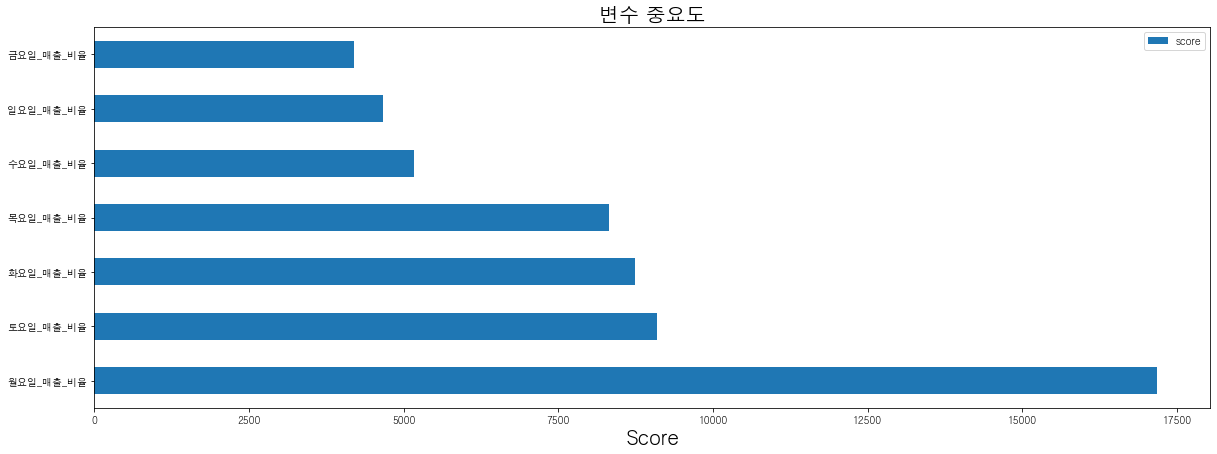

In [38]:
# 중요도 시각화

feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

fig, ax = plt.pyplot.subplots(figsize=(20,7))
data_50 = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_50[:10].plot(kind='barh', ax = ax, label = '')
ax.set_title('변수 중요도', size = 20)
ax.set_xlabel('Score', size = 20)

## 5. 모델링 - 시간대별
### (1) 전처리

In [39]:
df.columns

Index(['Unnamed: 0', '기준_년_코드', '기준_분기_코드', '서비스_업종_코드', '점포_수', '유사_업종_점포_수',
       '개업_율', '개업_점포_수', '폐업_률', '폐업_점포_수', '프랜차이즈_점포_수', '당월_매출_금액',
       '당월_매출_건수', '주중_매출_비율', '주말_매출_비율', '월요일_매출_비율', '화요일_매출_비율',
       '수요일_매출_비율', '목요일_매출_비율', '금요일_매출_비율', '토요일_매출_비율', '일요일_매출_비율',
       '시간대_00~06_매출_비율', '시간대_06~11_매출_비율', '시간대_11~14_매출_비율',
       '시간대_14~17_매출_비율', '시간대_17~21_매출_비율', '시간대_21~24_매출_비율', '남성_매출_비율',
       '여성_매출_비율', '연령대_10_매출_비율', '연령대_20_매출_비율', '연령대_30_매출_비율',
       '연령대_40_매출_비율', '연령대_50_매출_비율', '연령대_60_이상_매출_비율', '주중_매출_금액',
       '주말_매출_금액', '월요일_매출_금액', '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액',
       '금요일_매출_금액', '토요일_매출_금액', '일요일_매출_금액', '시간대_00~06_매출_금액',
       '시간대_06~11_매출_금액', '시간대_11~14_매출_금액', '시간대_14~17_매출_금액',
       '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액', '여성_매출_금액',
       '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액', '연령대_40_매출_금액',
       '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수', '주말_매출_건수', '월요일_매출_건수',
       '화요일_매

In [40]:
df_new = df[['기준_년_코드', '기준_분기_코드', '서비스_업종_코드','시간대_00~06_매출_비율', '시간대_06~11_매출_비율', '시간대_11~14_매출_비율',
       '시간대_14~17_매출_비율', '시간대_17~21_매출_비율', '시간대_21~24_매출_비율', '폐업_률']]
df_new

,기준_년_코드,기준_분기_코드,서비스_업종_코드,시간대_00~06_매출_비율,시간대_06~11_매출_비율,시간대_11~14_매출_비율,시간대_14~17_매출_비율,시간대_17~21_매출_비율,시간대_21~24_매출_비율,폐업_률
0,2015,1,CS100001,1.00,0.00,0.00,1.00,1.00,1.00,3
1,2015,2,CS100001,1.00,0.00,0.17,0.75,0.78,0.75,5
2,2015,3,CS100001,1.00,0.00,0.11,0.75,0.89,0.75,4
3,2015,4,CS100001,1.00,0.00,0.06,0.75,0.89,1.00,3
4,2016,1,CS100001,1.00,0.00,0.11,1.00,0.78,1.00,4
5,2016,2,CS100001,1.00,0.00,0.22,0.75,0.67,1.00,5
6,2016,3,CS100001,1.00,0.00,0.28,0.75,0.67,0.75,6
7,2016,4,CS100001,1.00,0.00,0.17,0.75,0.78,1.00,2
8,2017,1,CS100001,1.00,0.00,0.22,0.50,0.67,1.00,2
9,2017,2,CS100001,1.00,0.00,0.39,0.50,0.56,0.75,4


In [41]:
# dataframe 행 순서 조정

a = df_new.iloc[20]
df_new = df_new.drop(20)
df_new = df_new.append(a)
df_new = df_new.reset_index(drop = True)
df_new

,기준_년_코드,기준_분기_코드,서비스_업종_코드,시간대_00~06_매출_비율,시간대_06~11_매출_비율,시간대_11~14_매출_비율,시간대_14~17_매출_비율,시간대_17~21_매출_비율,시간대_21~24_매출_비율,폐업_률
0,2015,1,CS100001,1.00,0.00,0.00,1.00,1.00,1.00,3
1,2015,2,CS100001,1.00,0.00,0.17,0.75,0.78,0.75,5
2,2015,3,CS100001,1.00,0.00,0.11,0.75,0.89,0.75,4
3,2015,4,CS100001,1.00,0.00,0.06,0.75,0.89,1.00,3
4,2016,1,CS100001,1.00,0.00,0.11,1.00,0.78,1.00,4
5,2016,2,CS100001,1.00,0.00,0.22,0.75,0.67,1.00,5
6,2016,3,CS100001,1.00,0.00,0.28,0.75,0.67,0.75,6
7,2016,4,CS100001,1.00,0.00,0.17,0.75,0.78,1.00,2
8,2017,1,CS100001,1.00,0.00,0.22,0.50,0.67,1.00,2
9,2017,2,CS100001,1.00,0.00,0.39,0.50,0.56,0.75,4


In [42]:
# 2020-3분기 예측에 사용되는 'X_predict' 데이터 추출

x_predict = pd.DataFrame(columns = df_new.columns)
x_predict = x_predict.append(df_new.iloc[21,:])
x_predict = x_predict.drop(['기준_년_코드', '기준_분기_코드', '서비스_업종_코드', '폐업_률'], axis = 1)
x_predict

,시간대_00~06_매출_비율,시간대_06~11_매출_비율,시간대_11~14_매출_비율,시간대_14~17_매출_비율,시간대_17~21_매출_비율,시간대_21~24_매출_비율
21,0.00,0.00,1.00,0.00,0.00,0.00


In [43]:
# 인풋 데이터 추출

x = df_new.drop('폐업_률', axis = 1).drop(21).reset_index(drop = True)
x

,기준_년_코드,기준_분기_코드,서비스_업종_코드,시간대_00~06_매출_비율,시간대_06~11_매출_비율,시간대_11~14_매출_비율,시간대_14~17_매출_비율,시간대_17~21_매출_비율,시간대_21~24_매출_비율
0,2015,1,CS100001,1.00,0.00,0.00,1.00,1.00,1.00
1,2015,2,CS100001,1.00,0.00,0.17,0.75,0.78,0.75
2,2015,3,CS100001,1.00,0.00,0.11,0.75,0.89,0.75
3,2015,4,CS100001,1.00,0.00,0.06,0.75,0.89,1.00
4,2016,1,CS100001,1.00,0.00,0.11,1.00,0.78,1.00
5,2016,2,CS100001,1.00,0.00,0.22,0.75,0.67,1.00
6,2016,3,CS100001,1.00,0.00,0.28,0.75,0.67,0.75
7,2016,4,CS100001,1.00,0.00,0.17,0.75,0.78,1.00
8,2017,1,CS100001,1.00,0.00,0.22,0.50,0.67,1.00
9,2017,2,CS100001,1.00,0.00,0.39,0.50,0.56,0.75


In [44]:
# x와 y를 하나로 merge

xy_train = pd.merge(x, y_new, how = 'left', on = ['기준_년_코드', '기준_분기_코드'])
xy_train

,기준_년_코드,기준_분기_코드,서비스_업종_코드,시간대_00~06_매출_비율,시간대_06~11_매출_비율,시간대_11~14_매출_비율,시간대_14~17_매출_비율,시간대_17~21_매출_비율,시간대_21~24_매출_비율,폐업_률
0,2015,1,CS100001,1.00,0.00,0.00,1.00,1.00,1.00,5
1,2015,2,CS100001,1.00,0.00,0.17,0.75,0.78,0.75,4
2,2015,3,CS100001,1.00,0.00,0.11,0.75,0.89,0.75,3
3,2015,4,CS100001,1.00,0.00,0.06,0.75,0.89,1.00,4
4,2016,1,CS100001,1.00,0.00,0.11,1.00,0.78,1.00,5
5,2016,2,CS100001,1.00,0.00,0.22,0.75,0.67,1.00,6
6,2016,3,CS100001,1.00,0.00,0.28,0.75,0.67,0.75,2
7,2016,4,CS100001,1.00,0.00,0.17,0.75,0.78,1.00,2
8,2017,1,CS100001,1.00,0.00,0.22,0.50,0.67,1.00,4
9,2017,2,CS100001,1.00,0.00,0.39,0.50,0.56,0.75,3


In [45]:
# 불필요한 column 삭제

xy_train_new = xy_train.drop(['기준_년_코드', '기준_분기_코드', '서비스_업종_코드'], axis = 1)
xy_train_new

,시간대_00~06_매출_비율,시간대_06~11_매출_비율,시간대_11~14_매출_비율,시간대_14~17_매출_비율,시간대_17~21_매출_비율,시간대_21~24_매출_비율,폐업_률
0,1.00,0.00,0.00,1.00,1.00,1.00,5
1,1.00,0.00,0.17,0.75,0.78,0.75,4
2,1.00,0.00,0.11,0.75,0.89,0.75,3
3,1.00,0.00,0.06,0.75,0.89,1.00,4
4,1.00,0.00,0.11,1.00,0.78,1.00,5
5,1.00,0.00,0.22,0.75,0.67,1.00,6
6,1.00,0.00,0.28,0.75,0.67,0.75,2
7,1.00,0.00,0.17,0.75,0.78,1.00,2
8,1.00,0.00,0.22,0.50,0.67,1.00,4
9,1.00,0.00,0.39,0.50,0.56,0.75,3


### (2) 모델링

In [46]:
start = time.time()  # 시작 시간 저장

x_in = xy_train_new.drop('폐업_률', axis = 1)
x_out = xy_train_new['폐업_률']

# 생존율로 변환
total = 100
x_out = total - x_out

# train, test 데이터 
X_train, X_test, y_train, y_test= train_test_split(x_in, x_out, test_size=0.2, random_state=42)

In [47]:
# xgboost 학습

model = XGBRegressor(booster="gbtree", objective ='reg:squarederror', n_estimators=12000, learning_rate=0.001 ,
                      max_depth=12, n_jobs = -1,subsample=0.75, reg_lambda=1, colsample_bytree=1, gamma=0, )

eval_set = [(X_test, y_test)]

model.fit(X_train,y_train, eval_set=eval_set, verbose=True)

pred_y = model.predict(X_test)

#predictions = [round(value) for value in xgb_5000_명동_pred ]
# evaluate predictions

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

[0]	validation_0-rmse:95.41333
[1]	validation_0-rmse:95.32425
[2]	validation_0-rmse:95.23433
[3]	validation_0-rmse:95.14635
[4]	validation_0-rmse:95.05764
[5]	validation_0-rmse:94.96960
[6]	validation_0-rmse:94.88163
[7]	validation_0-rmse:94.79261
[8]	validation_0-rmse:94.70481
[9]	validation_0-rmse:94.61733
[10]	validation_0-rmse:94.52843
[11]	validation_0-rmse:94.44160
[12]	validation_0-rmse:94.35287
[13]	validation_0-rmse:94.26580
[14]	validation_0-rmse:94.17675
[15]	validation_0-rmse:94.08759
[16]	validation_0-rmse:94.00330
[17]	validation_0-rmse:93.91869
[18]	validation_0-rmse:93.83185
[19]	validation_0-rmse:93.74526
[20]	validation_0-rmse:93.65803
[21]	validation_0-rmse:93.56967
[22]	validation_0-rmse:93.48299
[23]	validation_0-rmse:93.39593
[24]	validation_0-rmse:93.30871
[25]	validation_0-rmse:93.22276
[26]	validation_0-rmse:93.13528
[27]	validation_0-rmse:93.04817
[28]	validation_0-rmse:92.96413
[29]	validation_0-rmse:92.87724
[30]	validation_0-rmse:92.79022
[31]	validation_0-

[252]	validation_0-rmse:75.53378
[253]	validation_0-rmse:75.46500
[254]	validation_0-rmse:75.39438
[255]	validation_0-rmse:75.32368
[256]	validation_0-rmse:75.25472
[257]	validation_0-rmse:75.18604
[258]	validation_0-rmse:75.11733
[259]	validation_0-rmse:75.04695
[260]	validation_0-rmse:74.97745
[261]	validation_0-rmse:74.90747
[262]	validation_0-rmse:74.83763
[263]	validation_0-rmse:74.76751
[264]	validation_0-rmse:74.69686
[265]	validation_0-rmse:74.62781
[266]	validation_0-rmse:74.55757
[267]	validation_0-rmse:74.48805
[268]	validation_0-rmse:74.41804
[269]	validation_0-rmse:74.34888
[270]	validation_0-rmse:74.27863
[271]	validation_0-rmse:74.20888
[272]	validation_0-rmse:74.14189
[273]	validation_0-rmse:74.07386
[274]	validation_0-rmse:74.00398
[275]	validation_0-rmse:73.93459
[276]	validation_0-rmse:73.86665
[277]	validation_0-rmse:73.79793
[278]	validation_0-rmse:73.72890
[279]	validation_0-rmse:73.65975
[280]	validation_0-rmse:73.59140
[281]	validation_0-rmse:73.52438
[282]	vali

[501]	validation_0-rmse:59.92656
[502]	validation_0-rmse:59.87048
[503]	validation_0-rmse:59.81387
[504]	validation_0-rmse:59.75868
[505]	validation_0-rmse:59.70409
[506]	validation_0-rmse:59.64784
[507]	validation_0-rmse:59.59210
[508]	validation_0-rmse:59.53679
[509]	validation_0-rmse:59.48122
[510]	validation_0-rmse:59.42578
[511]	validation_0-rmse:59.37132
[512]	validation_0-rmse:59.31648
[513]	validation_0-rmse:59.26056
[514]	validation_0-rmse:59.20518
[515]	validation_0-rmse:59.14971
[516]	validation_0-rmse:59.09370
[517]	validation_0-rmse:59.03782
[518]	validation_0-rmse:58.98219
[519]	validation_0-rmse:58.92766
[520]	validation_0-rmse:58.87332
[521]	validation_0-rmse:58.81953
[522]	validation_0-rmse:58.76471
[523]	validation_0-rmse:58.70985
[524]	validation_0-rmse:58.65536
[525]	validation_0-rmse:58.60159
[526]	validation_0-rmse:58.54617
[527]	validation_0-rmse:58.49231
[528]	validation_0-rmse:58.43862
[529]	validation_0-rmse:58.38399
[530]	validation_0-rmse:58.32914
[531]	vali

[750]	validation_0-rmse:47.52972
[751]	validation_0-rmse:47.48460
[752]	validation_0-rmse:47.43956
[753]	validation_0-rmse:47.39508
[754]	validation_0-rmse:47.35051
[755]	validation_0-rmse:47.30612
[756]	validation_0-rmse:47.26154
[757]	validation_0-rmse:47.21744
[758]	validation_0-rmse:47.17408
[759]	validation_0-rmse:47.12965
[760]	validation_0-rmse:47.08506
[761]	validation_0-rmse:47.04183
[762]	validation_0-rmse:46.99825
[763]	validation_0-rmse:46.95373
[764]	validation_0-rmse:46.91019
[765]	validation_0-rmse:46.86589
[766]	validation_0-rmse:46.82179
[767]	validation_0-rmse:46.77741
[768]	validation_0-rmse:46.73342
[769]	validation_0-rmse:46.68992
[770]	validation_0-rmse:46.64705
[771]	validation_0-rmse:46.60292
[772]	validation_0-rmse:46.55930
[773]	validation_0-rmse:46.51604
[774]	validation_0-rmse:46.47265
[775]	validation_0-rmse:46.42995
[776]	validation_0-rmse:46.38685
[777]	validation_0-rmse:46.34365
[778]	validation_0-rmse:46.30060
[779]	validation_0-rmse:46.25702
[780]	vali

[999]	validation_0-rmse:37.65702
[1000]	validation_0-rmse:37.62196
[1001]	validation_0-rmse:37.58625
[1002]	validation_0-rmse:37.55139
[1003]	validation_0-rmse:37.51613
[1004]	validation_0-rmse:37.48179
[1005]	validation_0-rmse:37.44648
[1006]	validation_0-rmse:37.41130
[1007]	validation_0-rmse:37.37765
[1008]	validation_0-rmse:37.34352
[1009]	validation_0-rmse:37.30790
[1010]	validation_0-rmse:37.27261
[1011]	validation_0-rmse:37.23908
[1012]	validation_0-rmse:37.20437
[1013]	validation_0-rmse:37.16953
[1014]	validation_0-rmse:37.13452
[1015]	validation_0-rmse:37.09967
[1016]	validation_0-rmse:37.06472
[1017]	validation_0-rmse:37.02967
[1018]	validation_0-rmse:36.99496
[1019]	validation_0-rmse:36.95998
[1020]	validation_0-rmse:36.92531
[1021]	validation_0-rmse:36.89061
[1022]	validation_0-rmse:36.85600
[1023]	validation_0-rmse:36.82156
[1024]	validation_0-rmse:36.78728
[1025]	validation_0-rmse:36.75230
[1026]	validation_0-rmse:36.71779
[1027]	validation_0-rmse:36.68356
[1028]	validati

[1240]	validation_0-rmse:30.04575
[1241]	validation_0-rmse:30.01763
[1242]	validation_0-rmse:29.98881
[1243]	validation_0-rmse:29.96003
[1244]	validation_0-rmse:29.93208
[1245]	validation_0-rmse:29.90516
[1246]	validation_0-rmse:29.87690
[1247]	validation_0-rmse:29.84919
[1248]	validation_0-rmse:29.82084
[1249]	validation_0-rmse:29.79247
[1250]	validation_0-rmse:29.76451
[1251]	validation_0-rmse:29.73764
[1252]	validation_0-rmse:29.71005
[1253]	validation_0-rmse:29.68260
[1254]	validation_0-rmse:29.65456
[1255]	validation_0-rmse:29.62689
[1256]	validation_0-rmse:29.59925
[1257]	validation_0-rmse:29.57125
[1258]	validation_0-rmse:29.54410
[1259]	validation_0-rmse:29.51645
[1260]	validation_0-rmse:29.48875
[1261]	validation_0-rmse:29.46081
[1262]	validation_0-rmse:29.43441
[1263]	validation_0-rmse:29.40641
[1264]	validation_0-rmse:29.38040
[1265]	validation_0-rmse:29.35298
[1266]	validation_0-rmse:29.32521
[1267]	validation_0-rmse:29.29802
[1268]	validation_0-rmse:29.27107
[1269]	validat

[1481]	validation_0-rmse:23.95690
[1482]	validation_0-rmse:23.93396
[1483]	validation_0-rmse:23.91111
[1484]	validation_0-rmse:23.88849
[1485]	validation_0-rmse:23.86623
[1486]	validation_0-rmse:23.84344
[1487]	validation_0-rmse:23.82110
[1488]	validation_0-rmse:23.79869
[1489]	validation_0-rmse:23.77617
[1490]	validation_0-rmse:23.75494
[1491]	validation_0-rmse:23.73317
[1492]	validation_0-rmse:23.71153
[1493]	validation_0-rmse:23.68953
[1494]	validation_0-rmse:23.66669
[1495]	validation_0-rmse:23.64408
[1496]	validation_0-rmse:23.62178
[1497]	validation_0-rmse:23.59943
[1498]	validation_0-rmse:23.57765
[1499]	validation_0-rmse:23.55506
[1500]	validation_0-rmse:23.53348
[1501]	validation_0-rmse:23.51184
[1502]	validation_0-rmse:23.48989
[1503]	validation_0-rmse:23.46773
[1504]	validation_0-rmse:23.44582
[1505]	validation_0-rmse:23.42366
[1506]	validation_0-rmse:23.40241
[1507]	validation_0-rmse:23.38028
[1508]	validation_0-rmse:23.35837
[1509]	validation_0-rmse:23.33638
[1510]	validat

[1722]	validation_0-rmse:19.07916
[1723]	validation_0-rmse:19.06110
[1724]	validation_0-rmse:19.04307
[1725]	validation_0-rmse:19.02476
[1726]	validation_0-rmse:19.00676
[1727]	validation_0-rmse:18.98869
[1728]	validation_0-rmse:18.97064
[1729]	validation_0-rmse:18.95219
[1730]	validation_0-rmse:18.93458
[1731]	validation_0-rmse:18.91701
[1732]	validation_0-rmse:18.89886
[1733]	validation_0-rmse:18.88040
[1734]	validation_0-rmse:18.86227
[1735]	validation_0-rmse:18.84431
[1736]	validation_0-rmse:18.82614
[1737]	validation_0-rmse:18.80895
[1738]	validation_0-rmse:18.79149
[1739]	validation_0-rmse:18.77327
[1740]	validation_0-rmse:18.75588
[1741]	validation_0-rmse:18.73788
[1742]	validation_0-rmse:18.71971
[1743]	validation_0-rmse:18.70157
[1744]	validation_0-rmse:18.68387
[1745]	validation_0-rmse:18.66618
[1746]	validation_0-rmse:18.64858
[1747]	validation_0-rmse:18.63069
[1748]	validation_0-rmse:18.61313
[1749]	validation_0-rmse:18.59550
[1750]	validation_0-rmse:18.57813
[1751]	validat

[1963]	validation_0-rmse:15.17118
[1964]	validation_0-rmse:15.15633
[1965]	validation_0-rmse:15.14144
[1966]	validation_0-rmse:15.12726
[1967]	validation_0-rmse:15.11281
[1968]	validation_0-rmse:15.09846
[1969]	validation_0-rmse:15.08430
[1970]	validation_0-rmse:15.07009
[1971]	validation_0-rmse:15.05628
[1972]	validation_0-rmse:15.04209
[1973]	validation_0-rmse:15.02772
[1974]	validation_0-rmse:15.01322
[1975]	validation_0-rmse:14.99885
[1976]	validation_0-rmse:14.98445
[1977]	validation_0-rmse:14.97006
[1978]	validation_0-rmse:14.95588
[1979]	validation_0-rmse:14.94159
[1980]	validation_0-rmse:14.92705
[1981]	validation_0-rmse:14.91279
[1982]	validation_0-rmse:14.89835
[1983]	validation_0-rmse:14.88447
[1984]	validation_0-rmse:14.87017
[1985]	validation_0-rmse:14.85601
[1986]	validation_0-rmse:14.84179
[1987]	validation_0-rmse:14.82754
[1988]	validation_0-rmse:14.81322
[1989]	validation_0-rmse:14.79907
[1990]	validation_0-rmse:14.78465
[1991]	validation_0-rmse:14.77054
[1992]	validat

[2204]	validation_0-rmse:12.04729
[2205]	validation_0-rmse:12.03528
[2206]	validation_0-rmse:12.02361
[2207]	validation_0-rmse:12.01162
[2208]	validation_0-rmse:11.99987
[2209]	validation_0-rmse:11.98844
[2210]	validation_0-rmse:11.97679
[2211]	validation_0-rmse:11.96478
[2212]	validation_0-rmse:11.95334
[2213]	validation_0-rmse:11.94182
[2214]	validation_0-rmse:11.93024
[2215]	validation_0-rmse:11.91869
[2216]	validation_0-rmse:11.90764
[2217]	validation_0-rmse:11.89609
[2218]	validation_0-rmse:11.88483
[2219]	validation_0-rmse:11.87368
[2220]	validation_0-rmse:11.86196
[2221]	validation_0-rmse:11.85039
[2222]	validation_0-rmse:11.83892
[2223]	validation_0-rmse:11.82767
[2224]	validation_0-rmse:11.81650
[2225]	validation_0-rmse:11.80553
[2226]	validation_0-rmse:11.79428
[2227]	validation_0-rmse:11.78314
[2228]	validation_0-rmse:11.77176
[2229]	validation_0-rmse:11.76039
[2230]	validation_0-rmse:11.74930
[2231]	validation_0-rmse:11.73793
[2232]	validation_0-rmse:11.72665
[2233]	validat

[2447]	validation_0-rmse:9.52309
[2448]	validation_0-rmse:9.51365
[2449]	validation_0-rmse:9.50421
[2450]	validation_0-rmse:9.49486
[2451]	validation_0-rmse:9.48536
[2452]	validation_0-rmse:9.47615
[2453]	validation_0-rmse:9.46703
[2454]	validation_0-rmse:9.45778
[2455]	validation_0-rmse:9.44848
[2456]	validation_0-rmse:9.43931
[2457]	validation_0-rmse:9.43020
[2458]	validation_0-rmse:9.42098
[2459]	validation_0-rmse:9.41176
[2460]	validation_0-rmse:9.40241
[2461]	validation_0-rmse:9.39308
[2462]	validation_0-rmse:9.38407
[2463]	validation_0-rmse:9.37511
[2464]	validation_0-rmse:9.36614
[2465]	validation_0-rmse:9.35727
[2466]	validation_0-rmse:9.34824
[2467]	validation_0-rmse:9.33919
[2468]	validation_0-rmse:9.33042
[2469]	validation_0-rmse:9.32166
[2470]	validation_0-rmse:9.31255
[2471]	validation_0-rmse:9.30330
[2472]	validation_0-rmse:9.29442
[2473]	validation_0-rmse:9.28519
[2474]	validation_0-rmse:9.27626
[2475]	validation_0-rmse:9.26704
[2476]	validation_0-rmse:9.25826
[2477]	val

[2696]	validation_0-rmse:7.46167
[2697]	validation_0-rmse:7.45428
[2698]	validation_0-rmse:7.44698
[2699]	validation_0-rmse:7.43987
[2700]	validation_0-rmse:7.43386
[2701]	validation_0-rmse:7.42651
[2702]	validation_0-rmse:7.41916
[2703]	validation_0-rmse:7.41137
[2704]	validation_0-rmse:7.40411
[2705]	validation_0-rmse:7.39709
[2706]	validation_0-rmse:7.39003
[2707]	validation_0-rmse:7.38246
[2708]	validation_0-rmse:7.37530
[2709]	validation_0-rmse:7.36800
[2710]	validation_0-rmse:7.36064
[2711]	validation_0-rmse:7.35364
[2712]	validation_0-rmse:7.34652
[2713]	validation_0-rmse:7.33971
[2714]	validation_0-rmse:7.33252
[2715]	validation_0-rmse:7.32526
[2716]	validation_0-rmse:7.31801
[2717]	validation_0-rmse:7.31102
[2718]	validation_0-rmse:7.30371
[2719]	validation_0-rmse:7.29663
[2720]	validation_0-rmse:7.28933
[2721]	validation_0-rmse:7.28240
[2722]	validation_0-rmse:7.27519
[2723]	validation_0-rmse:7.26807
[2724]	validation_0-rmse:7.26133
[2725]	validation_0-rmse:7.25414
[2726]	val

[2945]	validation_0-rmse:5.83037
[2946]	validation_0-rmse:5.82467
[2947]	validation_0-rmse:5.81897
[2948]	validation_0-rmse:5.81370
[2949]	validation_0-rmse:5.80811
[2950]	validation_0-rmse:5.80264
[2951]	validation_0-rmse:5.79662
[2952]	validation_0-rmse:5.79064
[2953]	validation_0-rmse:5.78460
[2954]	validation_0-rmse:5.77893
[2955]	validation_0-rmse:5.77313
[2956]	validation_0-rmse:5.76740
[2957]	validation_0-rmse:5.76187
[2958]	validation_0-rmse:5.75624
[2959]	validation_0-rmse:5.75047
[2960]	validation_0-rmse:5.74485
[2961]	validation_0-rmse:5.73896
[2962]	validation_0-rmse:5.73319
[2963]	validation_0-rmse:5.72786
[2964]	validation_0-rmse:5.72184
[2965]	validation_0-rmse:5.71609
[2966]	validation_0-rmse:5.71035
[2967]	validation_0-rmse:5.70429
[2968]	validation_0-rmse:5.69894
[2969]	validation_0-rmse:5.69315
[2970]	validation_0-rmse:5.68750
[2971]	validation_0-rmse:5.68143
[2972]	validation_0-rmse:5.67602
[2973]	validation_0-rmse:5.67012
[2974]	validation_0-rmse:5.66456
[2975]	val

[3194]	validation_0-rmse:4.52288
[3195]	validation_0-rmse:4.51820
[3196]	validation_0-rmse:4.51347
[3197]	validation_0-rmse:4.50884
[3198]	validation_0-rmse:4.50383
[3199]	validation_0-rmse:4.49944
[3200]	validation_0-rmse:4.49438
[3201]	validation_0-rmse:4.49009
[3202]	validation_0-rmse:4.48549
[3203]	validation_0-rmse:4.48084
[3204]	validation_0-rmse:4.47653
[3205]	validation_0-rmse:4.47172
[3206]	validation_0-rmse:4.46701
[3207]	validation_0-rmse:4.46221
[3208]	validation_0-rmse:4.45755
[3209]	validation_0-rmse:4.45369
[3210]	validation_0-rmse:4.44895
[3211]	validation_0-rmse:4.44437
[3212]	validation_0-rmse:4.44003
[3213]	validation_0-rmse:4.43550
[3214]	validation_0-rmse:4.43072
[3215]	validation_0-rmse:4.42588
[3216]	validation_0-rmse:4.42135
[3217]	validation_0-rmse:4.41730
[3218]	validation_0-rmse:4.41247
[3219]	validation_0-rmse:4.40832
[3220]	validation_0-rmse:4.40377
[3221]	validation_0-rmse:4.39924
[3222]	validation_0-rmse:4.39471
[3223]	validation_0-rmse:4.39000
[3224]	val

[3443]	validation_0-rmse:3.49058
[3444]	validation_0-rmse:3.48728
[3445]	validation_0-rmse:3.48359
[3446]	validation_0-rmse:3.47999
[3447]	validation_0-rmse:3.47600
[3448]	validation_0-rmse:3.47222
[3449]	validation_0-rmse:3.46849
[3450]	validation_0-rmse:3.46471
[3451]	validation_0-rmse:3.46097
[3452]	validation_0-rmse:3.45774
[3453]	validation_0-rmse:3.45391
[3454]	validation_0-rmse:3.45015
[3455]	validation_0-rmse:3.44695
[3456]	validation_0-rmse:3.44312
[3457]	validation_0-rmse:3.43912
[3458]	validation_0-rmse:3.43592
[3459]	validation_0-rmse:3.43216
[3460]	validation_0-rmse:3.42840
[3461]	validation_0-rmse:3.42455
[3462]	validation_0-rmse:3.42060
[3463]	validation_0-rmse:3.41688
[3464]	validation_0-rmse:3.41348
[3465]	validation_0-rmse:3.41036
[3466]	validation_0-rmse:3.40632
[3467]	validation_0-rmse:3.40293
[3468]	validation_0-rmse:3.39935
[3469]	validation_0-rmse:3.39619
[3470]	validation_0-rmse:3.39244
[3471]	validation_0-rmse:3.38854
[3472]	validation_0-rmse:3.38503
[3473]	val

[3692]	validation_0-rmse:2.68161
[3693]	validation_0-rmse:2.67877
[3694]	validation_0-rmse:2.67593
[3695]	validation_0-rmse:2.67267
[3696]	validation_0-rmse:2.67156
[3697]	validation_0-rmse:2.66860
[3698]	validation_0-rmse:2.66571
[3699]	validation_0-rmse:2.66279
[3700]	validation_0-rmse:2.65986
[3701]	validation_0-rmse:2.65680
[3702]	validation_0-rmse:2.65446
[3703]	validation_0-rmse:2.65141
[3704]	validation_0-rmse:2.64854
[3705]	validation_0-rmse:2.64575
[3706]	validation_0-rmse:2.64299
[3707]	validation_0-rmse:2.64031
[3708]	validation_0-rmse:2.63725
[3709]	validation_0-rmse:2.63445
[3710]	validation_0-rmse:2.63143
[3711]	validation_0-rmse:2.62852
[3712]	validation_0-rmse:2.62545
[3713]	validation_0-rmse:2.62270
[3714]	validation_0-rmse:2.62032
[3715]	validation_0-rmse:2.61756
[3716]	validation_0-rmse:2.61479
[3717]	validation_0-rmse:2.61250
[3718]	validation_0-rmse:2.61007
[3719]	validation_0-rmse:2.60729
[3720]	validation_0-rmse:2.60454
[3721]	validation_0-rmse:2.60144
[3722]	val

[3941]	validation_0-rmse:2.06695
[3942]	validation_0-rmse:2.06472
[3943]	validation_0-rmse:2.06301
[3944]	validation_0-rmse:2.06085
[3945]	validation_0-rmse:2.05849
[3946]	validation_0-rmse:2.05745
[3947]	validation_0-rmse:2.05588
[3948]	validation_0-rmse:2.05383
[3949]	validation_0-rmse:2.05165
[3950]	validation_0-rmse:2.05003
[3951]	validation_0-rmse:2.04778
[3952]	validation_0-rmse:2.04547
[3953]	validation_0-rmse:2.04345
[3954]	validation_0-rmse:2.04165
[3955]	validation_0-rmse:2.03991
[3956]	validation_0-rmse:2.03742
[3957]	validation_0-rmse:2.03581
[3958]	validation_0-rmse:2.03329
[3959]	validation_0-rmse:2.03103
[3960]	validation_0-rmse:2.02880
[3961]	validation_0-rmse:2.02671
[3962]	validation_0-rmse:2.02437
[3963]	validation_0-rmse:2.02204
[3964]	validation_0-rmse:2.01998
[3965]	validation_0-rmse:2.01768
[3966]	validation_0-rmse:2.01548
[3967]	validation_0-rmse:2.01334
[3968]	validation_0-rmse:2.01081
[3969]	validation_0-rmse:2.00842
[3970]	validation_0-rmse:2.00685
[3971]	val

[4190]	validation_0-rmse:1.61449
[4191]	validation_0-rmse:1.61286
[4192]	validation_0-rmse:1.61100
[4193]	validation_0-rmse:1.60990
[4194]	validation_0-rmse:1.60829
[4195]	validation_0-rmse:1.60628
[4196]	validation_0-rmse:1.60471
[4197]	validation_0-rmse:1.60375
[4198]	validation_0-rmse:1.60194
[4199]	validation_0-rmse:1.60012
[4200]	validation_0-rmse:1.59910
[4201]	validation_0-rmse:1.59799
[4202]	validation_0-rmse:1.59698
[4203]	validation_0-rmse:1.59530
[4204]	validation_0-rmse:1.59388
[4205]	validation_0-rmse:1.59279
[4206]	validation_0-rmse:1.59136
[4207]	validation_0-rmse:1.58966
[4208]	validation_0-rmse:1.58798
[4209]	validation_0-rmse:1.58603
[4210]	validation_0-rmse:1.58504
[4211]	validation_0-rmse:1.58335
[4212]	validation_0-rmse:1.58173
[4213]	validation_0-rmse:1.57981
[4214]	validation_0-rmse:1.57831
[4215]	validation_0-rmse:1.57641
[4216]	validation_0-rmse:1.57543
[4217]	validation_0-rmse:1.57387
[4218]	validation_0-rmse:1.57318
[4219]	validation_0-rmse:1.57167
[4220]	val

[4439]	validation_0-rmse:1.30466
[4440]	validation_0-rmse:1.30332
[4441]	validation_0-rmse:1.30217
[4442]	validation_0-rmse:1.30113
[4443]	validation_0-rmse:1.29987
[4444]	validation_0-rmse:1.29909
[4445]	validation_0-rmse:1.29798
[4446]	validation_0-rmse:1.29682
[4447]	validation_0-rmse:1.29574
[4448]	validation_0-rmse:1.29441
[4449]	validation_0-rmse:1.29309
[4450]	validation_0-rmse:1.29198
[4451]	validation_0-rmse:1.29154
[4452]	validation_0-rmse:1.29025
[4453]	validation_0-rmse:1.28893
[4454]	validation_0-rmse:1.28761
[4455]	validation_0-rmse:1.28639
[4456]	validation_0-rmse:1.28496
[4457]	validation_0-rmse:1.28381
[4458]	validation_0-rmse:1.28336
[4459]	validation_0-rmse:1.28281
[4460]	validation_0-rmse:1.28222
[4461]	validation_0-rmse:1.28143
[4462]	validation_0-rmse:1.28114
[4463]	validation_0-rmse:1.28077
[4464]	validation_0-rmse:1.27970
[4465]	validation_0-rmse:1.27824
[4466]	validation_0-rmse:1.27753
[4467]	validation_0-rmse:1.27663
[4468]	validation_0-rmse:1.27539
[4469]	val

[4688]	validation_0-rmse:1.10729
[4689]	validation_0-rmse:1.10695
[4690]	validation_0-rmse:1.10650
[4691]	validation_0-rmse:1.10606
[4692]	validation_0-rmse:1.10554
[4693]	validation_0-rmse:1.10458
[4694]	validation_0-rmse:1.10424
[4695]	validation_0-rmse:1.10368
[4696]	validation_0-rmse:1.10349
[4697]	validation_0-rmse:1.10306
[4698]	validation_0-rmse:1.10268
[4699]	validation_0-rmse:1.10226
[4700]	validation_0-rmse:1.10203
[4701]	validation_0-rmse:1.10166
[4702]	validation_0-rmse:1.10069
[4703]	validation_0-rmse:1.10019
[4704]	validation_0-rmse:1.09985
[4705]	validation_0-rmse:1.09909
[4706]	validation_0-rmse:1.09884
[4707]	validation_0-rmse:1.09832
[4708]	validation_0-rmse:1.09716
[4709]	validation_0-rmse:1.09625
[4710]	validation_0-rmse:1.09551
[4711]	validation_0-rmse:1.09518
[4712]	validation_0-rmse:1.09413
[4713]	validation_0-rmse:1.09330
[4714]	validation_0-rmse:1.09289
[4715]	validation_0-rmse:1.09249
[4716]	validation_0-rmse:1.09211
[4717]	validation_0-rmse:1.09179
[4718]	val

[4937]	validation_0-rmse:0.99632
[4938]	validation_0-rmse:0.99581
[4939]	validation_0-rmse:0.99572
[4940]	validation_0-rmse:0.99571
[4941]	validation_0-rmse:0.99510
[4942]	validation_0-rmse:0.99499
[4943]	validation_0-rmse:0.99490
[4944]	validation_0-rmse:0.99433
[4945]	validation_0-rmse:0.99357
[4946]	validation_0-rmse:0.99342
[4947]	validation_0-rmse:0.99336
[4948]	validation_0-rmse:0.99319
[4949]	validation_0-rmse:0.99276
[4950]	validation_0-rmse:0.99261
[4951]	validation_0-rmse:0.99257
[4952]	validation_0-rmse:0.99245
[4953]	validation_0-rmse:0.99207
[4954]	validation_0-rmse:0.99156
[4955]	validation_0-rmse:0.99108
[4956]	validation_0-rmse:0.99097
[4957]	validation_0-rmse:0.99087
[4958]	validation_0-rmse:0.99034
[4959]	validation_0-rmse:0.98977
[4960]	validation_0-rmse:0.98934
[4961]	validation_0-rmse:0.98921
[4962]	validation_0-rmse:0.98911
[4963]	validation_0-rmse:0.98899
[4964]	validation_0-rmse:0.98821
[4965]	validation_0-rmse:0.98800
[4966]	validation_0-rmse:0.98721
[4967]	val

[5186]	validation_0-rmse:0.93987
[5187]	validation_0-rmse:0.94003
[5188]	validation_0-rmse:0.94010
[5189]	validation_0-rmse:0.94007
[5190]	validation_0-rmse:0.93973
[5191]	validation_0-rmse:0.93932
[5192]	validation_0-rmse:0.93891
[5193]	validation_0-rmse:0.93889
[5194]	validation_0-rmse:0.93897
[5195]	validation_0-rmse:0.93869
[5196]	validation_0-rmse:0.93843
[5197]	validation_0-rmse:0.93807
[5198]	validation_0-rmse:0.93814
[5199]	validation_0-rmse:0.93822
[5200]	validation_0-rmse:0.93835
[5201]	validation_0-rmse:0.93845
[5202]	validation_0-rmse:0.93832
[5203]	validation_0-rmse:0.93794
[5204]	validation_0-rmse:0.93799
[5205]	validation_0-rmse:0.93756
[5206]	validation_0-rmse:0.93757
[5207]	validation_0-rmse:0.93758
[5208]	validation_0-rmse:0.93769
[5209]	validation_0-rmse:0.93776
[5210]	validation_0-rmse:0.93735
[5211]	validation_0-rmse:0.93700
[5212]	validation_0-rmse:0.93701
[5213]	validation_0-rmse:0.93730
[5214]	validation_0-rmse:0.93745
[5215]	validation_0-rmse:0.93685
[5216]	val

[5435]	validation_0-rmse:0.92761
[5436]	validation_0-rmse:0.92748
[5437]	validation_0-rmse:0.92771
[5438]	validation_0-rmse:0.92790
[5439]	validation_0-rmse:0.92796
[5440]	validation_0-rmse:0.92793
[5441]	validation_0-rmse:0.92804
[5442]	validation_0-rmse:0.92793
[5443]	validation_0-rmse:0.92784
[5444]	validation_0-rmse:0.92824
[5445]	validation_0-rmse:0.92844
[5446]	validation_0-rmse:0.92835
[5447]	validation_0-rmse:0.92862
[5448]	validation_0-rmse:0.92848
[5449]	validation_0-rmse:0.92874
[5450]	validation_0-rmse:0.92862
[5451]	validation_0-rmse:0.92836
[5452]	validation_0-rmse:0.92823
[5453]	validation_0-rmse:0.92793
[5454]	validation_0-rmse:0.92779
[5455]	validation_0-rmse:0.92807
[5456]	validation_0-rmse:0.92847
[5457]	validation_0-rmse:0.92846
[5458]	validation_0-rmse:0.92847
[5459]	validation_0-rmse:0.92833
[5460]	validation_0-rmse:0.92871
[5461]	validation_0-rmse:0.92909
[5462]	validation_0-rmse:0.92924
[5463]	validation_0-rmse:0.92933
[5464]	validation_0-rmse:0.92930
[5465]	val

[5684]	validation_0-rmse:0.95301
[5685]	validation_0-rmse:0.95290
[5686]	validation_0-rmse:0.95326
[5687]	validation_0-rmse:0.95331
[5688]	validation_0-rmse:0.95375
[5689]	validation_0-rmse:0.95372
[5690]	validation_0-rmse:0.95381
[5691]	validation_0-rmse:0.95352
[5692]	validation_0-rmse:0.95359
[5693]	validation_0-rmse:0.95380
[5694]	validation_0-rmse:0.95419
[5695]	validation_0-rmse:0.95420
[5696]	validation_0-rmse:0.95450
[5697]	validation_0-rmse:0.95500
[5698]	validation_0-rmse:0.95512
[5699]	validation_0-rmse:0.95500
[5700]	validation_0-rmse:0.95513
[5701]	validation_0-rmse:0.95550
[5702]	validation_0-rmse:0.95577
[5703]	validation_0-rmse:0.95626
[5704]	validation_0-rmse:0.95666
[5705]	validation_0-rmse:0.95703
[5706]	validation_0-rmse:0.95704
[5707]	validation_0-rmse:0.95751
[5708]	validation_0-rmse:0.95749
[5709]	validation_0-rmse:0.95796
[5710]	validation_0-rmse:0.95830
[5711]	validation_0-rmse:0.95835
[5712]	validation_0-rmse:0.95841
[5713]	validation_0-rmse:0.95879
[5714]	val

[5933]	validation_0-rmse:1.00063
[5934]	validation_0-rmse:1.00101
[5935]	validation_0-rmse:1.00142
[5936]	validation_0-rmse:1.00194
[5937]	validation_0-rmse:1.00173
[5938]	validation_0-rmse:1.00165
[5939]	validation_0-rmse:1.00144
[5940]	validation_0-rmse:1.00154
[5941]	validation_0-rmse:1.00171
[5942]	validation_0-rmse:1.00189
[5943]	validation_0-rmse:1.00205
[5944]	validation_0-rmse:1.00229
[5945]	validation_0-rmse:1.00229
[5946]	validation_0-rmse:1.00192
[5947]	validation_0-rmse:1.00202
[5948]	validation_0-rmse:1.00210
[5949]	validation_0-rmse:1.00224
[5950]	validation_0-rmse:1.00211
[5951]	validation_0-rmse:1.00231
[5952]	validation_0-rmse:1.00270
[5953]	validation_0-rmse:1.00284
[5954]	validation_0-rmse:1.00266
[5955]	validation_0-rmse:1.00309
[5956]	validation_0-rmse:1.00327
[5957]	validation_0-rmse:1.00378
[5958]	validation_0-rmse:1.00423
[5959]	validation_0-rmse:1.00445
[5960]	validation_0-rmse:1.00448
[5961]	validation_0-rmse:1.00460
[5962]	validation_0-rmse:1.00456
[5963]	val

[6182]	validation_0-rmse:1.05261
[6183]	validation_0-rmse:1.05306
[6184]	validation_0-rmse:1.05289
[6185]	validation_0-rmse:1.05301
[6186]	validation_0-rmse:1.05294
[6187]	validation_0-rmse:1.05298
[6188]	validation_0-rmse:1.05341
[6189]	validation_0-rmse:1.05383
[6190]	validation_0-rmse:1.05377
[6191]	validation_0-rmse:1.05422
[6192]	validation_0-rmse:1.05463
[6193]	validation_0-rmse:1.05504
[6194]	validation_0-rmse:1.05557
[6195]	validation_0-rmse:1.05578
[6196]	validation_0-rmse:1.05585
[6197]	validation_0-rmse:1.05604
[6198]	validation_0-rmse:1.05614
[6199]	validation_0-rmse:1.05635
[6200]	validation_0-rmse:1.05676
[6201]	validation_0-rmse:1.05721
[6202]	validation_0-rmse:1.05743
[6203]	validation_0-rmse:1.05763
[6204]	validation_0-rmse:1.05783
[6205]	validation_0-rmse:1.05792
[6206]	validation_0-rmse:1.05835
[6207]	validation_0-rmse:1.05880
[6208]	validation_0-rmse:1.05922
[6209]	validation_0-rmse:1.05962
[6210]	validation_0-rmse:1.06003
[6211]	validation_0-rmse:1.06002
[6212]	val

[6431]	validation_0-rmse:1.10194
[6432]	validation_0-rmse:1.10195
[6433]	validation_0-rmse:1.10235
[6434]	validation_0-rmse:1.10251
[6435]	validation_0-rmse:1.10261
[6436]	validation_0-rmse:1.10318
[6437]	validation_0-rmse:1.10324
[6438]	validation_0-rmse:1.10345
[6439]	validation_0-rmse:1.10389
[6440]	validation_0-rmse:1.10396
[6441]	validation_0-rmse:1.10424
[6442]	validation_0-rmse:1.10428
[6443]	validation_0-rmse:1.10424
[6444]	validation_0-rmse:1.10441
[6445]	validation_0-rmse:1.10436
[6446]	validation_0-rmse:1.10475
[6447]	validation_0-rmse:1.10481
[6448]	validation_0-rmse:1.10498
[6449]	validation_0-rmse:1.10526
[6450]	validation_0-rmse:1.10542
[6451]	validation_0-rmse:1.10574
[6452]	validation_0-rmse:1.10604
[6453]	validation_0-rmse:1.10608
[6454]	validation_0-rmse:1.10607
[6455]	validation_0-rmse:1.10603
[6456]	validation_0-rmse:1.10601
[6457]	validation_0-rmse:1.10626
[6458]	validation_0-rmse:1.10655
[6459]	validation_0-rmse:1.10683
[6460]	validation_0-rmse:1.10741
[6461]	val

[6680]	validation_0-rmse:1.15037
[6681]	validation_0-rmse:1.15068
[6682]	validation_0-rmse:1.15094
[6683]	validation_0-rmse:1.15135
[6684]	validation_0-rmse:1.15162
[6685]	validation_0-rmse:1.15162
[6686]	validation_0-rmse:1.15162
[6687]	validation_0-rmse:1.15178
[6688]	validation_0-rmse:1.15197
[6689]	validation_0-rmse:1.15216
[6690]	validation_0-rmse:1.15222
[6691]	validation_0-rmse:1.15238
[6692]	validation_0-rmse:1.15278
[6693]	validation_0-rmse:1.15323
[6694]	validation_0-rmse:1.15337
[6695]	validation_0-rmse:1.15377
[6696]	validation_0-rmse:1.15424
[6697]	validation_0-rmse:1.15451
[6698]	validation_0-rmse:1.15498
[6699]	validation_0-rmse:1.15542
[6700]	validation_0-rmse:1.15583
[6701]	validation_0-rmse:1.15599
[6702]	validation_0-rmse:1.15617
[6703]	validation_0-rmse:1.15644
[6704]	validation_0-rmse:1.15684
[6705]	validation_0-rmse:1.15691
[6706]	validation_0-rmse:1.15702
[6707]	validation_0-rmse:1.15742
[6708]	validation_0-rmse:1.15749
[6709]	validation_0-rmse:1.15761
[6710]	val

[6929]	validation_0-rmse:1.19534
[6930]	validation_0-rmse:1.19535
[6931]	validation_0-rmse:1.19554
[6932]	validation_0-rmse:1.19556
[6933]	validation_0-rmse:1.19569
[6934]	validation_0-rmse:1.19594
[6935]	validation_0-rmse:1.19632
[6936]	validation_0-rmse:1.19661
[6937]	validation_0-rmse:1.19663
[6938]	validation_0-rmse:1.19664
[6939]	validation_0-rmse:1.19703
[6940]	validation_0-rmse:1.19707
[6941]	validation_0-rmse:1.19713
[6942]	validation_0-rmse:1.19738
[6943]	validation_0-rmse:1.19746
[6944]	validation_0-rmse:1.19761
[6945]	validation_0-rmse:1.19763
[6946]	validation_0-rmse:1.19771
[6947]	validation_0-rmse:1.19787
[6948]	validation_0-rmse:1.19824
[6949]	validation_0-rmse:1.19849
[6950]	validation_0-rmse:1.19862
[6951]	validation_0-rmse:1.19859
[6952]	validation_0-rmse:1.19884
[6953]	validation_0-rmse:1.19899
[6954]	validation_0-rmse:1.19909
[6955]	validation_0-rmse:1.19929
[6956]	validation_0-rmse:1.19942
[6957]	validation_0-rmse:1.19970
[6958]	validation_0-rmse:1.19983
[6959]	val

[7178]	validation_0-rmse:1.23612
[7179]	validation_0-rmse:1.23629
[7180]	validation_0-rmse:1.23664
[7181]	validation_0-rmse:1.23673
[7182]	validation_0-rmse:1.23688
[7183]	validation_0-rmse:1.23696
[7184]	validation_0-rmse:1.23723
[7185]	validation_0-rmse:1.23738
[7186]	validation_0-rmse:1.23762
[7187]	validation_0-rmse:1.23788
[7188]	validation_0-rmse:1.23833
[7189]	validation_0-rmse:1.23856
[7190]	validation_0-rmse:1.23902
[7191]	validation_0-rmse:1.23915
[7192]	validation_0-rmse:1.23920
[7193]	validation_0-rmse:1.23928
[7194]	validation_0-rmse:1.23965
[7195]	validation_0-rmse:1.23973
[7196]	validation_0-rmse:1.23965
[7197]	validation_0-rmse:1.23985
[7198]	validation_0-rmse:1.23993
[7199]	validation_0-rmse:1.24016
[7200]	validation_0-rmse:1.24011
[7201]	validation_0-rmse:1.24008
[7202]	validation_0-rmse:1.24004
[7203]	validation_0-rmse:1.24039
[7204]	validation_0-rmse:1.24026
[7205]	validation_0-rmse:1.24030
[7206]	validation_0-rmse:1.24053
[7207]	validation_0-rmse:1.24070
[7208]	val

[7427]	validation_0-rmse:1.27316
[7428]	validation_0-rmse:1.27328
[7429]	validation_0-rmse:1.27379
[7430]	validation_0-rmse:1.27396
[7431]	validation_0-rmse:1.27401
[7432]	validation_0-rmse:1.27423
[7433]	validation_0-rmse:1.27431
[7434]	validation_0-rmse:1.27444
[7435]	validation_0-rmse:1.27450
[7436]	validation_0-rmse:1.27475
[7437]	validation_0-rmse:1.27477
[7438]	validation_0-rmse:1.27480
[7439]	validation_0-rmse:1.27493
[7440]	validation_0-rmse:1.27501
[7441]	validation_0-rmse:1.27514
[7442]	validation_0-rmse:1.27528
[7443]	validation_0-rmse:1.27523
[7444]	validation_0-rmse:1.27536
[7445]	validation_0-rmse:1.27558
[7446]	validation_0-rmse:1.27571
[7447]	validation_0-rmse:1.27585
[7448]	validation_0-rmse:1.27597
[7449]	validation_0-rmse:1.27585
[7450]	validation_0-rmse:1.27597
[7451]	validation_0-rmse:1.27612
[7452]	validation_0-rmse:1.27625
[7453]	validation_0-rmse:1.27638
[7454]	validation_0-rmse:1.27659
[7455]	validation_0-rmse:1.27662
[7456]	validation_0-rmse:1.27677
[7457]	val

[7676]	validation_0-rmse:1.30894
[7677]	validation_0-rmse:1.30902
[7678]	validation_0-rmse:1.30899
[7679]	validation_0-rmse:1.30909
[7680]	validation_0-rmse:1.30920
[7681]	validation_0-rmse:1.30950
[7682]	validation_0-rmse:1.30963
[7683]	validation_0-rmse:1.30993
[7684]	validation_0-rmse:1.31003
[7685]	validation_0-rmse:1.31006
[7686]	validation_0-rmse:1.31017
[7687]	validation_0-rmse:1.31033
[7688]	validation_0-rmse:1.31044
[7689]	validation_0-rmse:1.31087
[7690]	validation_0-rmse:1.31106
[7691]	validation_0-rmse:1.31113
[7692]	validation_0-rmse:1.31099
[7693]	validation_0-rmse:1.31113
[7694]	validation_0-rmse:1.31124
[7695]	validation_0-rmse:1.31121
[7696]	validation_0-rmse:1.31128
[7697]	validation_0-rmse:1.31149
[7698]	validation_0-rmse:1.31161
[7699]	validation_0-rmse:1.31164
[7700]	validation_0-rmse:1.31179
[7701]	validation_0-rmse:1.31191
[7702]	validation_0-rmse:1.31188
[7703]	validation_0-rmse:1.31193
[7704]	validation_0-rmse:1.31199
[7705]	validation_0-rmse:1.31212
[7706]	val

[7925]	validation_0-rmse:1.34142
[7926]	validation_0-rmse:1.34150
[7927]	validation_0-rmse:1.34164
[7928]	validation_0-rmse:1.34167
[7929]	validation_0-rmse:1.34188
[7930]	validation_0-rmse:1.34205
[7931]	validation_0-rmse:1.34208
[7932]	validation_0-rmse:1.34221
[7933]	validation_0-rmse:1.34230
[7934]	validation_0-rmse:1.34240
[7935]	validation_0-rmse:1.34236
[7936]	validation_0-rmse:1.34256
[7937]	validation_0-rmse:1.34275
[7938]	validation_0-rmse:1.34294
[7939]	validation_0-rmse:1.34296
[7940]	validation_0-rmse:1.34278
[7941]	validation_0-rmse:1.34284
[7942]	validation_0-rmse:1.34281
[7943]	validation_0-rmse:1.34299
[7944]	validation_0-rmse:1.34304
[7945]	validation_0-rmse:1.34327
[7946]	validation_0-rmse:1.34320
[7947]	validation_0-rmse:1.34349
[7948]	validation_0-rmse:1.34361
[7949]	validation_0-rmse:1.34373
[7950]	validation_0-rmse:1.34386
[7951]	validation_0-rmse:1.34395
[7952]	validation_0-rmse:1.34409
[7953]	validation_0-rmse:1.34425
[7954]	validation_0-rmse:1.34436
[7955]	val

[8174]	validation_0-rmse:1.37015
[8175]	validation_0-rmse:1.37012
[8176]	validation_0-rmse:1.37015
[8177]	validation_0-rmse:1.37034
[8178]	validation_0-rmse:1.37038
[8179]	validation_0-rmse:1.37057
[8180]	validation_0-rmse:1.37075
[8181]	validation_0-rmse:1.37086
[8182]	validation_0-rmse:1.37088
[8183]	validation_0-rmse:1.37103
[8184]	validation_0-rmse:1.37116
[8185]	validation_0-rmse:1.37126
[8186]	validation_0-rmse:1.37132
[8187]	validation_0-rmse:1.37141
[8188]	validation_0-rmse:1.37151
[8189]	validation_0-rmse:1.37177
[8190]	validation_0-rmse:1.37186
[8191]	validation_0-rmse:1.37196
[8192]	validation_0-rmse:1.37221
[8193]	validation_0-rmse:1.37233
[8194]	validation_0-rmse:1.37250
[8195]	validation_0-rmse:1.37252
[8196]	validation_0-rmse:1.37252
[8197]	validation_0-rmse:1.37249
[8198]	validation_0-rmse:1.37232
[8199]	validation_0-rmse:1.37223
[8200]	validation_0-rmse:1.37236
[8201]	validation_0-rmse:1.37245
[8202]	validation_0-rmse:1.37259
[8203]	validation_0-rmse:1.37271
[8204]	val

[8423]	validation_0-rmse:1.39758
[8424]	validation_0-rmse:1.39768
[8425]	validation_0-rmse:1.39782
[8426]	validation_0-rmse:1.39797
[8427]	validation_0-rmse:1.39812
[8428]	validation_0-rmse:1.39817
[8429]	validation_0-rmse:1.39823
[8430]	validation_0-rmse:1.39836
[8431]	validation_0-rmse:1.39847
[8432]	validation_0-rmse:1.39871
[8433]	validation_0-rmse:1.39882
[8434]	validation_0-rmse:1.39887
[8435]	validation_0-rmse:1.39906
[8436]	validation_0-rmse:1.39922
[8437]	validation_0-rmse:1.39933
[8438]	validation_0-rmse:1.39943
[8439]	validation_0-rmse:1.39941
[8440]	validation_0-rmse:1.39952
[8441]	validation_0-rmse:1.39972
[8442]	validation_0-rmse:1.39983
[8443]	validation_0-rmse:1.39996
[8444]	validation_0-rmse:1.40003
[8445]	validation_0-rmse:1.40011
[8446]	validation_0-rmse:1.40020
[8447]	validation_0-rmse:1.40032
[8448]	validation_0-rmse:1.40042
[8449]	validation_0-rmse:1.40053
[8450]	validation_0-rmse:1.40072
[8451]	validation_0-rmse:1.40086
[8452]	validation_0-rmse:1.40083
[8453]	val

[8672]	validation_0-rmse:1.42397
[8673]	validation_0-rmse:1.42415
[8674]	validation_0-rmse:1.42423
[8675]	validation_0-rmse:1.42437
[8676]	validation_0-rmse:1.42450
[8677]	validation_0-rmse:1.42466
[8678]	validation_0-rmse:1.42473
[8679]	validation_0-rmse:1.42496
[8680]	validation_0-rmse:1.42506
[8681]	validation_0-rmse:1.42516
[8682]	validation_0-rmse:1.42521
[8683]	validation_0-rmse:1.42531
[8684]	validation_0-rmse:1.42547
[8685]	validation_0-rmse:1.42557
[8686]	validation_0-rmse:1.42559
[8687]	validation_0-rmse:1.42570
[8688]	validation_0-rmse:1.42567
[8689]	validation_0-rmse:1.42572
[8690]	validation_0-rmse:1.42586
[8691]	validation_0-rmse:1.42587
[8692]	validation_0-rmse:1.42598
[8693]	validation_0-rmse:1.42616
[8694]	validation_0-rmse:1.42618
[8695]	validation_0-rmse:1.42634
[8696]	validation_0-rmse:1.42656
[8697]	validation_0-rmse:1.42678
[8698]	validation_0-rmse:1.42688
[8699]	validation_0-rmse:1.42696
[8700]	validation_0-rmse:1.42706
[8701]	validation_0-rmse:1.42717
[8702]	val

[8921]	validation_0-rmse:1.44776
[8922]	validation_0-rmse:1.44786
[8923]	validation_0-rmse:1.44802
[8924]	validation_0-rmse:1.44812
[8925]	validation_0-rmse:1.44826
[8926]	validation_0-rmse:1.44813
[8927]	validation_0-rmse:1.44824
[8928]	validation_0-rmse:1.44829
[8929]	validation_0-rmse:1.44817
[8930]	validation_0-rmse:1.44822
[8931]	validation_0-rmse:1.44823
[8932]	validation_0-rmse:1.44833
[8933]	validation_0-rmse:1.44825
[8934]	validation_0-rmse:1.44826
[8935]	validation_0-rmse:1.44836
[8936]	validation_0-rmse:1.44858
[8937]	validation_0-rmse:1.44867
[8938]	validation_0-rmse:1.44881
[8939]	validation_0-rmse:1.44896
[8940]	validation_0-rmse:1.44906
[8941]	validation_0-rmse:1.44893
[8942]	validation_0-rmse:1.44903
[8943]	validation_0-rmse:1.44913
[8944]	validation_0-rmse:1.44922
[8945]	validation_0-rmse:1.44933
[8946]	validation_0-rmse:1.44942
[8947]	validation_0-rmse:1.44951
[8948]	validation_0-rmse:1.44957
[8949]	validation_0-rmse:1.44976
[8950]	validation_0-rmse:1.44991
[8951]	val

[9170]	validation_0-rmse:1.46835
[9171]	validation_0-rmse:1.46845
[9172]	validation_0-rmse:1.46855
[9173]	validation_0-rmse:1.46863
[9174]	validation_0-rmse:1.46872
[9175]	validation_0-rmse:1.46881
[9176]	validation_0-rmse:1.46887
[9177]	validation_0-rmse:1.46891
[9178]	validation_0-rmse:1.46908
[9179]	validation_0-rmse:1.46923
[9180]	validation_0-rmse:1.46936
[9181]	validation_0-rmse:1.46946
[9182]	validation_0-rmse:1.46955
[9183]	validation_0-rmse:1.46943
[9184]	validation_0-rmse:1.46944
[9185]	validation_0-rmse:1.46954
[9186]	validation_0-rmse:1.46957
[9187]	validation_0-rmse:1.46966
[9188]	validation_0-rmse:1.46959
[9189]	validation_0-rmse:1.46955
[9190]	validation_0-rmse:1.46959
[9191]	validation_0-rmse:1.46968
[9192]	validation_0-rmse:1.46981
[9193]	validation_0-rmse:1.46970
[9194]	validation_0-rmse:1.46977
[9195]	validation_0-rmse:1.46988
[9196]	validation_0-rmse:1.46998
[9197]	validation_0-rmse:1.47007
[9198]	validation_0-rmse:1.47022
[9199]	validation_0-rmse:1.47031
[9200]	val

[9419]	validation_0-rmse:1.48950
[9420]	validation_0-rmse:1.48958
[9421]	validation_0-rmse:1.48971
[9422]	validation_0-rmse:1.48979
[9423]	validation_0-rmse:1.48992
[9424]	validation_0-rmse:1.49001
[9425]	validation_0-rmse:1.49013
[9426]	validation_0-rmse:1.49022
[9427]	validation_0-rmse:1.49034
[9428]	validation_0-rmse:1.49043
[9429]	validation_0-rmse:1.49043
[9430]	validation_0-rmse:1.49061
[9431]	validation_0-rmse:1.49072
[9432]	validation_0-rmse:1.49082
[9433]	validation_0-rmse:1.49090
[9434]	validation_0-rmse:1.49097
[9435]	validation_0-rmse:1.49103
[9436]	validation_0-rmse:1.49109
[9437]	validation_0-rmse:1.49101
[9438]	validation_0-rmse:1.49110
[9439]	validation_0-rmse:1.49115
[9440]	validation_0-rmse:1.49131
[9441]	validation_0-rmse:1.49140
[9442]	validation_0-rmse:1.49148
[9443]	validation_0-rmse:1.49149
[9444]	validation_0-rmse:1.49142
[9445]	validation_0-rmse:1.49182
[9446]	validation_0-rmse:1.49201
[9447]	validation_0-rmse:1.49202
[9448]	validation_0-rmse:1.49214
[9449]	val

[9668]	validation_0-rmse:1.50805
[9669]	validation_0-rmse:1.50813
[9670]	validation_0-rmse:1.50814
[9671]	validation_0-rmse:1.50812
[9672]	validation_0-rmse:1.50821
[9673]	validation_0-rmse:1.50824
[9674]	validation_0-rmse:1.50840
[9675]	validation_0-rmse:1.50854
[9676]	validation_0-rmse:1.50865
[9677]	validation_0-rmse:1.50872
[9678]	validation_0-rmse:1.50882
[9679]	validation_0-rmse:1.50888
[9680]	validation_0-rmse:1.50896
[9681]	validation_0-rmse:1.50908
[9682]	validation_0-rmse:1.50916
[9683]	validation_0-rmse:1.50924
[9684]	validation_0-rmse:1.50935
[9685]	validation_0-rmse:1.50945
[9686]	validation_0-rmse:1.50954
[9687]	validation_0-rmse:1.50963
[9688]	validation_0-rmse:1.50966
[9689]	validation_0-rmse:1.50973
[9690]	validation_0-rmse:1.50987
[9691]	validation_0-rmse:1.50995
[9692]	validation_0-rmse:1.51005
[9693]	validation_0-rmse:1.51010
[9694]	validation_0-rmse:1.51018
[9695]	validation_0-rmse:1.51029
[9696]	validation_0-rmse:1.51041
[9697]	validation_0-rmse:1.51055
[9698]	val

[9917]	validation_0-rmse:1.52624
[9918]	validation_0-rmse:1.52633
[9919]	validation_0-rmse:1.52632
[9920]	validation_0-rmse:1.52642
[9921]	validation_0-rmse:1.52652
[9922]	validation_0-rmse:1.52663
[9923]	validation_0-rmse:1.52657
[9924]	validation_0-rmse:1.52669
[9925]	validation_0-rmse:1.52680
[9926]	validation_0-rmse:1.52691
[9927]	validation_0-rmse:1.52699
[9928]	validation_0-rmse:1.52712
[9929]	validation_0-rmse:1.52719
[9930]	validation_0-rmse:1.52723
[9931]	validation_0-rmse:1.52727
[9932]	validation_0-rmse:1.52732
[9933]	validation_0-rmse:1.52739
[9934]	validation_0-rmse:1.52733
[9935]	validation_0-rmse:1.52727
[9936]	validation_0-rmse:1.52743
[9937]	validation_0-rmse:1.52744
[9938]	validation_0-rmse:1.52751
[9939]	validation_0-rmse:1.52756
[9940]	validation_0-rmse:1.52757
[9941]	validation_0-rmse:1.52753
[9942]	validation_0-rmse:1.52763
[9943]	validation_0-rmse:1.52772
[9944]	validation_0-rmse:1.52768
[9945]	validation_0-rmse:1.52772
[9946]	validation_0-rmse:1.52780
[9947]	val

[10161]	validation_0-rmse:1.54209
[10162]	validation_0-rmse:1.54216
[10163]	validation_0-rmse:1.54220
[10164]	validation_0-rmse:1.54227
[10165]	validation_0-rmse:1.54222
[10166]	validation_0-rmse:1.54230
[10167]	validation_0-rmse:1.54236
[10168]	validation_0-rmse:1.54244
[10169]	validation_0-rmse:1.54251
[10170]	validation_0-rmse:1.54253
[10171]	validation_0-rmse:1.54260
[10172]	validation_0-rmse:1.54270
[10173]	validation_0-rmse:1.54276
[10174]	validation_0-rmse:1.54286
[10175]	validation_0-rmse:1.54293
[10176]	validation_0-rmse:1.54297
[10177]	validation_0-rmse:1.54305
[10178]	validation_0-rmse:1.54312
[10179]	validation_0-rmse:1.54318
[10180]	validation_0-rmse:1.54323
[10181]	validation_0-rmse:1.54329
[10182]	validation_0-rmse:1.54346
[10183]	validation_0-rmse:1.54340
[10184]	validation_0-rmse:1.54347
[10185]	validation_0-rmse:1.54346
[10186]	validation_0-rmse:1.54353
[10187]	validation_0-rmse:1.54360
[10188]	validation_0-rmse:1.54368
[10189]	validation_0-rmse:1.54378
[10190]	valida

[10402]	validation_0-rmse:1.55736
[10403]	validation_0-rmse:1.55739
[10404]	validation_0-rmse:1.55745
[10405]	validation_0-rmse:1.55752
[10406]	validation_0-rmse:1.55756
[10407]	validation_0-rmse:1.55764
[10408]	validation_0-rmse:1.55776
[10409]	validation_0-rmse:1.55782
[10410]	validation_0-rmse:1.55785
[10411]	validation_0-rmse:1.55788
[10412]	validation_0-rmse:1.55789
[10413]	validation_0-rmse:1.55795
[10414]	validation_0-rmse:1.55807
[10415]	validation_0-rmse:1.55816
[10416]	validation_0-rmse:1.55823
[10417]	validation_0-rmse:1.55827
[10418]	validation_0-rmse:1.55839
[10419]	validation_0-rmse:1.55843
[10420]	validation_0-rmse:1.55852
[10421]	validation_0-rmse:1.55856
[10422]	validation_0-rmse:1.55864
[10423]	validation_0-rmse:1.55870
[10424]	validation_0-rmse:1.55875
[10425]	validation_0-rmse:1.55883
[10426]	validation_0-rmse:1.55886
[10427]	validation_0-rmse:1.55896
[10428]	validation_0-rmse:1.55894
[10429]	validation_0-rmse:1.55899
[10430]	validation_0-rmse:1.55905
[10431]	valida

[10643]	validation_0-rmse:1.57273
[10644]	validation_0-rmse:1.57269
[10645]	validation_0-rmse:1.57275
[10646]	validation_0-rmse:1.57283
[10647]	validation_0-rmse:1.57289
[10648]	validation_0-rmse:1.57294
[10649]	validation_0-rmse:1.57304
[10650]	validation_0-rmse:1.57309
[10651]	validation_0-rmse:1.57312
[10652]	validation_0-rmse:1.57318
[10653]	validation_0-rmse:1.57325
[10654]	validation_0-rmse:1.57331
[10655]	validation_0-rmse:1.57338
[10656]	validation_0-rmse:1.57343
[10657]	validation_0-rmse:1.57355
[10658]	validation_0-rmse:1.57361
[10659]	validation_0-rmse:1.57362
[10660]	validation_0-rmse:1.57373
[10661]	validation_0-rmse:1.57375
[10662]	validation_0-rmse:1.57381
[10663]	validation_0-rmse:1.57384
[10664]	validation_0-rmse:1.57391
[10665]	validation_0-rmse:1.57396
[10666]	validation_0-rmse:1.57402
[10667]	validation_0-rmse:1.57403
[10668]	validation_0-rmse:1.57409
[10669]	validation_0-rmse:1.57420
[10670]	validation_0-rmse:1.57432
[10671]	validation_0-rmse:1.57432
[10672]	valida

[10884]	validation_0-rmse:1.58581
[10885]	validation_0-rmse:1.58584
[10886]	validation_0-rmse:1.58592
[10887]	validation_0-rmse:1.58593
[10888]	validation_0-rmse:1.58599
[10889]	validation_0-rmse:1.58609
[10890]	validation_0-rmse:1.58611
[10891]	validation_0-rmse:1.58622
[10892]	validation_0-rmse:1.58625
[10893]	validation_0-rmse:1.58631
[10894]	validation_0-rmse:1.58636
[10895]	validation_0-rmse:1.58640
[10896]	validation_0-rmse:1.58651
[10897]	validation_0-rmse:1.58657
[10898]	validation_0-rmse:1.58658
[10899]	validation_0-rmse:1.58664
[10900]	validation_0-rmse:1.58671
[10901]	validation_0-rmse:1.58677
[10902]	validation_0-rmse:1.58683
[10903]	validation_0-rmse:1.58689
[10904]	validation_0-rmse:1.58692
[10905]	validation_0-rmse:1.58694
[10906]	validation_0-rmse:1.58700
[10907]	validation_0-rmse:1.58705
[10908]	validation_0-rmse:1.58701
[10909]	validation_0-rmse:1.58703
[10910]	validation_0-rmse:1.58711
[10911]	validation_0-rmse:1.58715
[10912]	validation_0-rmse:1.58710
[10913]	valida

[11125]	validation_0-rmse:1.59833
[11126]	validation_0-rmse:1.59841
[11127]	validation_0-rmse:1.59837
[11128]	validation_0-rmse:1.59842
[11129]	validation_0-rmse:1.59846
[11130]	validation_0-rmse:1.59851
[11131]	validation_0-rmse:1.59856
[11132]	validation_0-rmse:1.59862
[11133]	validation_0-rmse:1.59867
[11134]	validation_0-rmse:1.59874
[11135]	validation_0-rmse:1.59879
[11136]	validation_0-rmse:1.59884
[11137]	validation_0-rmse:1.59892
[11138]	validation_0-rmse:1.59902
[11139]	validation_0-rmse:1.59901
[11140]	validation_0-rmse:1.59904
[11141]	validation_0-rmse:1.59913
[11142]	validation_0-rmse:1.59919
[11143]	validation_0-rmse:1.59928
[11144]	validation_0-rmse:1.59933
[11145]	validation_0-rmse:1.59938
[11146]	validation_0-rmse:1.59941
[11147]	validation_0-rmse:1.59946
[11148]	validation_0-rmse:1.59949
[11149]	validation_0-rmse:1.59957
[11150]	validation_0-rmse:1.59965
[11151]	validation_0-rmse:1.59970
[11152]	validation_0-rmse:1.59975
[11153]	validation_0-rmse:1.59980
[11154]	valida

[11366]	validation_0-rmse:1.60919
[11367]	validation_0-rmse:1.60924
[11368]	validation_0-rmse:1.60929
[11369]	validation_0-rmse:1.60935
[11370]	validation_0-rmse:1.60941
[11371]	validation_0-rmse:1.60942
[11372]	validation_0-rmse:1.60947
[11373]	validation_0-rmse:1.60952
[11374]	validation_0-rmse:1.60948
[11375]	validation_0-rmse:1.60952
[11376]	validation_0-rmse:1.60956
[11377]	validation_0-rmse:1.60965
[11378]	validation_0-rmse:1.60969
[11379]	validation_0-rmse:1.60972
[11380]	validation_0-rmse:1.60977
[11381]	validation_0-rmse:1.60982
[11382]	validation_0-rmse:1.60987
[11383]	validation_0-rmse:1.60990
[11384]	validation_0-rmse:1.60996
[11385]	validation_0-rmse:1.61001
[11386]	validation_0-rmse:1.61003
[11387]	validation_0-rmse:1.61008
[11388]	validation_0-rmse:1.61013
[11389]	validation_0-rmse:1.61020
[11390]	validation_0-rmse:1.61024
[11391]	validation_0-rmse:1.61029
[11392]	validation_0-rmse:1.61033
[11393]	validation_0-rmse:1.61038
[11394]	validation_0-rmse:1.61040
[11395]	valida

[11607]	validation_0-rmse:1.61880
[11608]	validation_0-rmse:1.61886
[11609]	validation_0-rmse:1.61891
[11610]	validation_0-rmse:1.61895
[11611]	validation_0-rmse:1.61900
[11612]	validation_0-rmse:1.61901
[11613]	validation_0-rmse:1.61902
[11614]	validation_0-rmse:1.61905
[11615]	validation_0-rmse:1.61909
[11616]	validation_0-rmse:1.61914
[11617]	validation_0-rmse:1.61917
[11618]	validation_0-rmse:1.61921
[11619]	validation_0-rmse:1.61926
[11620]	validation_0-rmse:1.61930
[11621]	validation_0-rmse:1.61935
[11622]	validation_0-rmse:1.61940
[11623]	validation_0-rmse:1.61935
[11624]	validation_0-rmse:1.61943
[11625]	validation_0-rmse:1.61946
[11626]	validation_0-rmse:1.61951
[11627]	validation_0-rmse:1.61946
[11628]	validation_0-rmse:1.61950
[11629]	validation_0-rmse:1.61955
[11630]	validation_0-rmse:1.61957
[11631]	validation_0-rmse:1.61962
[11632]	validation_0-rmse:1.61966
[11633]	validation_0-rmse:1.61976
[11634]	validation_0-rmse:1.61980
[11635]	validation_0-rmse:1.61985
[11636]	valida

[11848]	validation_0-rmse:1.62777
[11849]	validation_0-rmse:1.62783
[11850]	validation_0-rmse:1.62788
[11851]	validation_0-rmse:1.62793
[11852]	validation_0-rmse:1.62797
[11853]	validation_0-rmse:1.62802
[11854]	validation_0-rmse:1.62804
[11855]	validation_0-rmse:1.62807
[11856]	validation_0-rmse:1.62809
[11857]	validation_0-rmse:1.62817
[11858]	validation_0-rmse:1.62820
[11859]	validation_0-rmse:1.62823
[11860]	validation_0-rmse:1.62825
[11861]	validation_0-rmse:1.62830
[11862]	validation_0-rmse:1.62829
[11863]	validation_0-rmse:1.62835
[11864]	validation_0-rmse:1.62838
[11865]	validation_0-rmse:1.62837
[11866]	validation_0-rmse:1.62846
[11867]	validation_0-rmse:1.62851
[11868]	validation_0-rmse:1.62855
[11869]	validation_0-rmse:1.62853
[11870]	validation_0-rmse:1.62855
[11871]	validation_0-rmse:1.62856
[11872]	validation_0-rmse:1.62860
[11873]	validation_0-rmse:1.62865
[11874]	validation_0-rmse:1.62871
[11875]	validation_0-rmse:1.62870
[11876]	validation_0-rmse:1.62877
[11877]	valida

### (3) Feature Importance

Text(0.5, 0, 'Score')

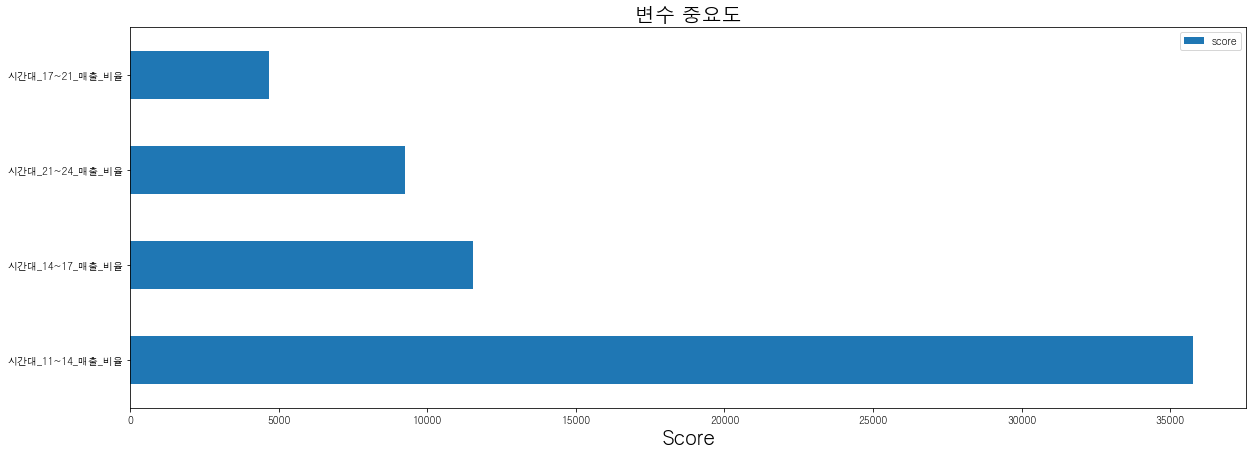

In [48]:
# 중요도 시각화

feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

fig, ax = plt.pyplot.subplots(figsize=(20,7))
data_50 = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_50[:10].plot(kind='barh', ax = ax, label = '')
ax.set_title('변수 중요도', size = 20)
ax.set_xlabel('Score', size = 20)